# Exploratory Data Analysis (EDA) Part I

The purpose of this notebook is to analyze single variable relationships based on domain knowledge and observations of the data. In other words, this is equivalent to the **EXPLORE** step in the Green Cloud Model. In addition, we will narrow down the variables of interest by removing any variables with existing transformations or variables that are repetitive. For ease, we will create copies of the tables in the MySQL database so we may drop columns (variables) that we do not plan to use and make any necessary transformations or new variables as needed, later on. 

In [1]:
%matplotlib inline

In [2]:
import pymysql
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import statsmodels.api as sm
import eda

sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<a id="NC"></a>
### Notebook Contents

1. [Create Table Copies](#0)
2. [Domain Knowledge](#1)
3. [Single Variable Exploration](#2)


<a id="0"></a>
### Create Table Copies

[Back to Contents](#NC)

In addition to creating copies of the National, State, and County tables, we will also drop any columns that have existing transformations or repetitive data. Although our goal is to build a forecasting model, multicollinearity can still pose an issue if we use any regression models. 

In [3]:
conn = pymysql.connect(
    host= 'MySQL_1',
    port=3306,
    user="Sarah",
    passwd='password',
    db="db",
    charset='utf8mb4')

In [4]:
curs = conn.cursor()

If we recall from the ETL notebook, we can view all the variables and decide which ones to keep, since the variables are the same for each table. This is especially helpful when dealing with the County table, since the large table size can quickly be reduced by using the National table to narrow down variables. 

In [5]:
curs.execute("SHOW columns FROM National")
national_headers = [column[0] for column in curs.fetchall()]

curs.execute("SELECT * FROM National")
national = pd.DataFrame(curs.fetchall(), columns=national_headers)

national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364 entries, 0 to 1363
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1364 non-null   int64  
 1   period_begin                    1364 non-null   object 
 2   period_end                      1364 non-null   object 
 3   period_duration                 1364 non-null   int64  
 4   region_type                     1364 non-null   object 
 5   region_type_id                  1364 non-null   int64  
 6   table_id                        1364 non-null   int64  
 7   is_seasonally_adjusted          1364 non-null   object 
 8   region                          1364 non-null   object 
 9   city                            1364 non-null   object 
 10  state                           1364 non-null   object 
 11  state_code                      1364 non-null   object 
 12  property_type                   13

First, we can drop any month to month or year to year percentages, since this is based on the raw data in other columns. Second, we can drop `is_seasonally_adjusted`, `property_type_id`, `region_type_id`, `parent_metro_region`, and `parent_metro_region_metro_code`, since these variables do not serve a purpose in our new database or were used only for retrieving the data from Redfin. We can also drop `city`, since this is blank n two of the tables and is only one possible value for the third. We can depend on dates, `table_id`, `property_type`, `region` and `state_code`/`state` if we need to look at any relational elements. 

In [6]:
curs.execute('DROP TABLE IF EXISTS National_analysis;');

curs.execute('CREATE TABLE National_analysis AS SELECT \
                 id, period_begin, period_end, period_duration, region_type, \
                 table_id, region, state, state_code, property_type, \
                 median_sale_price, median_list_price, median_ppsf, median_list_ppsf, \
                 homes_sold, pending_sales, new_listings, inventory, months_of_supply, \
                 median_dom, avg_sale_to_list, price_drops, off_market_in_two_weeks \
             FROM National;');

curs.execute('ALTER TABLE National_analysis ADD PRIMARY KEY(id);')
curs.execute('ALTER TABLE National_analysis ADD FOREIGN KEY (id) REFERENCES National(id);');

The variables are the same for each table, so we can do the same for state and county tables as follows:

In [7]:
curs.execute('DROP TABLE IF EXISTS State_analysis;');

curs.execute('CREATE TABLE State_analysis AS SELECT \
                 id, period_begin, period_end, period_duration, region_type, \
                 table_id, region, state, state_code, property_type, \
                 median_sale_price, median_list_price, median_ppsf, median_list_ppsf, \
                 homes_sold, pending_sales, new_listings, inventory, months_of_supply, \
                 median_dom, avg_sale_to_list, price_drops, off_market_in_two_weeks \
             FROM State;');

curs.execute('ALTER TABLE State_analysis ADD PRIMARY KEY(id);')
curs.execute('ALTER TABLE State_analysis ADD FOREIGN KEY (id) REFERENCES State(id);');

In [8]:
curs.execute('DROP TABLE IF EXISTS County_analysis;');

curs.execute('CREATE TABLE County_analysis AS SELECT \
                 id, period_begin, period_end, period_duration, region_type, \
                 table_id, region, state, state_code, property_type, \
                 median_sale_price, median_list_price, median_ppsf, median_list_ppsf, \
                 homes_sold, pending_sales, new_listings, inventory, months_of_supply, \
                 median_dom, avg_sale_to_list, price_drops, off_market_in_two_weeks \
             FROM County;');

curs.execute('ALTER TABLE County_analysis ADD PRIMARY KEY(id);')
curs.execute('ALTER TABLE County_analysis ADD FOREIGN KEY (id) REFERENCES County(id);');

In [9]:
conn.commit()

For reference, we can view the variables and general info for our new analysis table for the National data, as well as generate the other tables in pandas if needed later on:

In [10]:
# National table in pandas
curs.execute("SHOW columns FROM National_analysis")
national_analysis_headers = [column[0] for column in curs.fetchall()]

curs.execute("SELECT * FROM National_analysis")
national_analysis = pd.DataFrame(curs.fetchall(), columns=national_analysis_headers)

# State table in pandas
curs.execute("SHOW columns FROM State_analysis")
state_analysis_headers = [column[0] for column in curs.fetchall()]

curs.execute("SELECT * FROM State_analysis")
state_analysis = pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

# County table in pandas
curs.execute("SHOW columns FROM County_analysis")
county_analysis_headers = [column[0] for column in curs.fetchall()]

curs.execute("SELECT * FROM County_analysis")
county_analysis = pd.DataFrame(curs.fetchall(), columns=county_analysis_headers)



national_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364 entries, 0 to 1363
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1364 non-null   int64  
 1   period_begin             1364 non-null   object 
 2   period_end               1364 non-null   object 
 3   period_duration          1364 non-null   int64  
 4   region_type              1364 non-null   object 
 5   table_id                 1364 non-null   int64  
 6   region                   1364 non-null   object 
 7   state                    1364 non-null   object 
 8   state_code               1364 non-null   object 
 9   property_type            1364 non-null   object 
 10  median_sale_price        1364 non-null   float64
 11  median_list_price        1364 non-null   float64
 12  median_ppsf              1364 non-null   float64
 13  median_list_ppsf         1364 non-null   float64
 14  homes_sold              

We are now ready to begin discussing how each of these variables will influence the data based on domain knowledge and begin exploration of the data. 

<a id="1"></a>
### Domain Knowledge

[Back to Contents](#NC)

There are 23 features, or variables, that we have for each table. We can summarize their data type, their definitions, and their projected influence on housing prices based on domain knowledge as follows:

1. **id**: Identifier. This is a unique key for each entry in the table. For the analysis tables, it also serves as a foriegn key to each matching entry in the original tables.

2. **period_begin**: Ordered. This is the start date for each 30 duration. For any time series analysis, we can generate predicitions based on either period_begin or period_end as the current time point. We expect properties during major recessions to sell for under listing price and take longer to sell. We also expect the inventory to be lower during recessions.

3. **period_end**: Ordered. This is the end date for each 30 duration. This is the end date for each 30 duration. For any time series analysis, we can generate predicitions based on either period_begin or period_end as the current time point. Same prediction applies as period_begins.

4. **period_duration**: Numerical. This represents the total number of days between period_begin and period_end, though in our case, this value is always 30 days.

5. **region_type**: Categorical. This variable varies depending on the table. For National, this variable is always National. For State, this variable is always state. For County, this variable is always county. 

6. **table_id**: Identifier or Categorical. This is a unique identifier that is unique to each region, likely representing the region table that the data is related to in Redfins database. I kept this variable in case it has other use cases for us. For National, this variable is always the same code. For State, this variable is a different code for each state. For County, this variable is different for each County.  

7. **region**: Categorical. This consists of the region of each entry. For National, this is always National. For State, this is the state (not abbreviated). For County, this is the county and state (abbreviated). We expect homes on the east and west coasts to sell for higher and faster compared to homes in the south or midwest. 

8. **state**: Categorical. For National, this variable is always U.S. For State and County, this variable is the non-abbreviated state. The prediction is the same concept as the prediction for the region variable.

9. **state_code**: Categorical. For National, this variable is always US. For State and County, this variable is the abbreviated state. 

10. **property_type**: Categorical. This variable indicates the type of property (Townhouse, Condo, Single Family, etc) for each entry. Overall, residential properties like single family homes and townhouses are the most popular property type [[1]](#http://advantageproperty.com.au/blog/post/different-property-types-explained). Over time, apartments and condos have increased in popularity, so we expect a shift as the years go on.

11. **median_sale_price**: Numerical. This consists of the median sale price of a property in the region, which depends on which table is referenced. We expect median sale price to increase with inflation over time, with the east and west coast harboring the highest sale prices that exceed the list price more often than other regions.

12. **median_list_price**: Numerical. This refers to the median listing price of a property in a region, which depends on which table is referenced. We expect the median list prices to increase with inflation over time, where properties on the east and west coast are listed higher than other regions.

13. **median_ppsf**: Numerical. This variable is the median price per square foot of a property in a region. This is the actual price per square foot that sold. The prediction is the same as the median sale price.

14. **median_list_ppsf**: Numerical. This is the median listing price per square foot. In other words, the originally listed price per square foot. The prediction is the same as median list price.

15. **homes_sold**: Numerical. This is the number of homes sold during each 30 day duration for the relevant region. We expect less homes to be sold during recessions or inventory shortages like during the peak of the Covid-19 pandemic.

16. **pending_sales**: Numerical. This is the number of homes that are pending contract or sale during each 30 day duration for the relevant region. We expect this variable to behave similarly to homes_sold.  

17. **new_listings**: Numerical. This is the number of homes that are new listings during each 30 day duration for the relevant region. We expect this variable to behave similarly to homes_sold.  

18. **inventory**: Numerical. This is the total number of homes on the market during each 30 day duration for the relevant region. We expect this variable to behave similarly to homes_sold.  

19. **months_of_supply**: Numerical. This is the expected months of supply based on the inventory during each 30 day duration for the relevant region. This may have a synonymous trend with the inventory variable, which risks multicollinearity, but we will keep the variable for now. We expect the months of supply to increase during recessions and decrease during inventory shortages. In addition, a buyers market would mean greater months of supply and a sellers market would mean lower months of supply.

20. **median_dom**: Numerical. This variable is the median number of days on the market during each 30 day duration for a property from the relevant region. We expect this variable to behave similarly to months_of_supply.

21. **avg_sale_to_list**: Numerical. This is a ratio consisting of the final sale price (what a buyer pays for the home) divided by the last list price expressed as a percentage.

22. **price_drops**: Numerical. This is the percent of properties during each duration that dropped the listing price. We expect more price drops during recessions, buyers markets, etc. 

23. **off_market_in_two_weeks**: Numerical. This is the percent of properties that were sold or taken off the market within two weeks of listing.  We expect more properties to sell within two weeks when the economy is stable, interest rates are low, or for regions in popular areas like cities on the east and west coast.   

Now that we have went through each variable and evaluated are predictions for how each variable may influence property price, we can begin single variable exploration. 

<a id="2"></a>
### Single Variable Exploration

[Back to Contents](#NC)

We will evaluate each variable of interest individually in order to look for trends, unique characteristics, and any other necessary exploratory findings that can help us better understand the data for model building.


1. [period_begin and period_end](#a)
2. [region](#b)
3. [state and state_code](#d)
4. [property_type](#e)
5. [median_sale_price](#f)
6. [median_list_price](#g)
7. [median_ppsf](#h)
8. [median_list_ppsf](#i)
9. [homes_sold](#j)
10. [pending_sales](#k)
11. [new_listings](#l)
12. [inventory](#m)
13. [months_of_supply](#n)
14. [median_dom](#o)
15. [avg_sale_to_list](#p)
16. [price_drops](#q)
17. [off_market_in_two_weeks](#r)

*Any rows we plan to drop will be removed from the MySQL database first, and then all rows we removed will be applied to the pandas dataframe before analysis. This is to save memory and prevent the kernel from dying due to the size of some of the tables.*

<a id="a"></a>
#### period_begin and period_end

[Back to Contents](#NC)

For all entries in National, State, and County, the variables are based on medians during 30 day durations. Therefore, we can plan to use *either* variable when we build the forcasting model but not both at the same time. Besides this fact, there isn't much to look at yet when it comes to the dates. 

We can check to see how many entries there are per 30 day duration for each table. Let's start with National:

In [11]:
curs.execute("SHOW columns FROM National_analysis")
headers = [column[0] for column in curs.fetchall()]

curs.execute('SELECT * FROM National_analysis WHERE period_begin LIKE "2012-01-01";')
result = pd.DataFrame(curs.fetchall(), columns=headers)

result

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,239,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Townhouse,168489.00,166315.00,107.77,109.82,30950.90,20680.60,42944.60,166213,5.58,80.28,0.97,0.07,0.31
1,316,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Single Units Only,159294.00,183051.00,90.00,102.00,269013.00,182971.00,465225.00,2004046,7.45,97.00,0.96,0.07,0.27
2,424,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Condo/Co-op,142656.00,156307.00,119.60,132.84,48306.10,31210.50,63952.50,275258,5.97,84.90,0.96,0.08,0.24
3,641,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Multi-Family (2-4 Unit),147971.00,163776.00,71.00,79.00,6747.00,4841.00,12468.00,58952,8.74,87.00,0.93,0.06,0.28
4,677,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Townhouse,154461.00,163081.00,102.00,107.00,21245.00,15765.00,36897.00,152996,7.20,94.00,0.96,0.06,0.30
5,683,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,All Residential,158958.00,182228.00,90.00,102.00,275760.00,187813.00,477693.00,2062998,7.48,97.00,0.96,0.07,0.27
6,692,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,All Residential,170969.00,185613.00,94.43,103.06,400893.00,266892.00,557115.00,2249755,5.81,85.75,0.96,0.06,0.27
7,1204,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Condo/Co-op,133360.00,155640.00,115.00,131.00,33549.00,22671.00,60885.00,261145,7.78,102.00,0.95,0.07,0.26
8,1231,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Single Units Only,171911.00,186208.00,95.23,103.09,396832.00,260566.00,533923.00,2186381,5.75,84.74,0.96,0.06,0.27
9,1250,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Single Family Residential,164937.00,189941.00,87.00,99.00,214217.00,144535.00,367441.00,1589904,7.42,96.00,0.96,0.06,0.26


For the National table, we have an entry for every 30 day interval for every property type. In other words, we have 11 entries for 2012-01-01 since there are several property types with different median sale prices and other price data. This could vary slightly for each duration since some property types may have not been sold in certain months. It's also interesting to note that there are only 6 unique property types listed, but there seems to be double entries. These entries are not the same, so it is purposeful and may have to do with where the data/calculations came from.

Let's look at the State table:

In [12]:
curs.execute("SHOW columns FROM State_analysis")
headers = [column[0] for column in curs.fetchall()]

curs.execute('SELECT * FROM State_analysis WHERE period_begin LIKE "2012-01-01";')
result = pd.DataFrame(curs.fetchall(), columns=headers)

len(result)

223

In [13]:
result.head()

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,132,2012-01-01,2012-01-31,30,state,26,Pennsylvania,Pennsylvania,PA,Townhouse,127100.00,163200.00,86.00,106.00,1219.00,733.00,2595.00,12146,10.00,104.00,0.93,0.00,0.27
1,169,2012-01-01,2012-01-31,30,state,33,Iowa,Iowa,IA,Multi-Family (2-4 Unit),88000.00,135000.00,54.00,106.00,2.00,1.00,9.00,43,21.50,95.00,0.94,0.00,0.00
2,241,2012-01-01,2012-01-31,30,state,13,Connecticut,Connecticut,CT,Condo/Co-op,129700.00,211200.00,113.00,133.00,154.00,41.00,350.00,2112,13.70,149.00,0.94,0.00,0.10
3,313,2012-01-01,2012-01-31,30,state,15,Delaware,Delaware,DE,Single Family Residential,203300.00,188400.00,106.00,105.00,279.00,221.00,566.00,2490,8.90,86.00,0.95,0.00,0.29
4,422,2012-01-01,2012-01-31,30,state,28,Rhode Island,Rhode Island,RI,All Residential,168800.00,201500.00,107.00,122.00,612.00,365.00,1131.00,5879,9.60,97.00,0.94,0.00,0.29


There are 223 entries for the 30 day duration starting with 2012-01-01. For ease of viewing, it may be easier to look for unique values in some of the other variables, since there are so many entries for each duration, in order to determine what all of the entries are for. 

Let's look at the state and property_type variables:

In [14]:
curs.execute('SELECT DISTINCT(property_type) FROM State_analysis WHERE period_begin LIKE "2012-01-01";')
property_unq = curs.fetchall()

curs.execute('SELECT COUNT(DISTINCT(state)) FROM State_analysis WHERE period_begin LIKE "2012-01-01";')
state_count = curs.fetchone()

for prop in property_unq:
    print(prop[0])

print(f"\nUnique States: {state_count[0]}")

Townhouse
Multi-Family (2-4 Unit)
Condo/Co-op
Single Family Residential
All Residential

Unique States: 48


For the 30 day duration starting with 2012-01-01, there are entries for five property types and 48 states. Interestingly, the State table does not include data for "Single Units Only". Does the State table have the dupilicate property type issue we noted in the National table?

In [15]:
curs.execute('SELECT state, property_type, COUNT(property_type) AS a \
              FROM (SELECT * FROM State_analysis WHERE period_begin LIKE "2012-01-01") as b \
              GROUP BY property_type, state;')

result = pd.DataFrame(curs.fetchall())
result[2].any() > 1

False

The state table does not contain any duplicates for the property types. Let's look at the County table in a similar manner:

In [16]:
curs.execute("SHOW columns FROM County_analysis")
headers = [column[0] for column in curs.fetchall()]

curs.execute('SELECT * FROM County_analysis WHERE period_begin LIKE "2012-01-01";')
result = pd.DataFrame(curs.fetchall(), columns=headers)

len(result)

4118

In [17]:
result.head()

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,180,2012-01-01,2012-01-31,30,county,2230,"Ross County, OH",Ohio,OH,All Residential,45000.00,78450.00,42.20,72.54,6.00,4.00,6.00,26,4.30,54.00,0.85,0.00,0.00
1,264,2012-01-01,2012-01-31,30,county,1134,"Clark County, KY",Kentucky,KY,Single Family Residential,146000.00,126950.00,73.00,82.22,9.00,4.00,43.00,206,22.90,112.00,0.96,0.00,0.25
2,398,2012-01-01,2012-01-31,30,county,551,"Douglas County, GA",Georgia,GA,All Residential,60949.50,74700.00,33.80,38.04,136.00,84.00,201.00,843,6.20,84.00,0.94,0.22,0.21
3,487,2012-01-01,2012-01-31,30,county,644,"Troup County, GA",Georgia,GA,All Residential,65675.00,126500.00,36.28,61.23,24.00,20.00,60.00,359,15.00,73.00,0.94,0.19,0.15
4,631,2012-01-01,2012-01-31,30,county,2922,"Weber County, UT",Utah,UT,Condo/Co-op,110000.00,140000.00,59.60,77.86,12.00,3.00,26.00,142,11.80,180.00,0.93,0.00,0.33


There are 4,118 entries for the 30 day duration beginning with 2012-01-01, where we can expect most durations to be around the same number of entries. Once again, this is likely due to the number of counties evaluated and the different property types:

In [18]:
curs.execute('SELECT DISTINCT(property_type) FROM County_analysis WHERE period_begin LIKE "2012-01-01";')
property_unq = curs.fetchall()

curs.execute('SELECT COUNT(DISTINCT(region)) FROM County_analysis WHERE period_begin LIKE "2012-01-01";')
county_count = curs.fetchone()

for prop in property_unq:
    print(prop[0])

print(f"\nUnique Counties: {county_count[0]}")

All Residential
Single Family Residential
Condo/Co-op
Multi-Family (2-4 Unit)
Townhouse

Unique Counties: 1399


Same as with the State table, let's check if there are any double entries for the property types in the County table:

In [19]:
curs.execute('SELECT region, property_type, COUNT(property_type) AS a \
              FROM (SELECT * FROM County_analysis WHERE period_begin LIKE "2012-01-01") as b \
              GROUP BY property_type, region;')

result = pd.DataFrame(curs.fetchall())
result[2].any() > 1

False

The State and County tables reference the same five property types with no double entries, while the National Table includes an extra type and the double entry for each property type. 

This gives us a good understanding of what each 30 day duration consists of, and what the median prices in other variables are based on. 

<a id="b"></a>
#### region

[Back to Contents](#NC)

As stated before, the region variable varies depending on which table we reference. Therefore, *we only need to look at the State and County tables*, since there is only one possible value for this variable in the National table. 

Let's start with the State table:

In [20]:
curs.execute('SELECT region, COUNT(region) as a FROM State_analysis \
              GROUP BY region ORDER BY a DESC;')
region_counts_st = pd.DataFrame(curs.fetchall(), columns = ['State', 'Count'])

region_counts_st

,State,Count
0,Georgia,620
1,New Jersey,620
2,California,620
3,Utah,620
4,Idaho,620
5,Kentucky,620
6,Oklahoma,620
7,Texas,620
8,Colorado,620
9,Maryland,620


We can see the 48 states, but I am curious which two states are not included in the data. Let's check:

In [21]:
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

x = list(states.values())
y = list(region_counts_st.iloc[:, 0])
not_included_states = []

for i in range(len(x)):
    if x[i] in y:
        pass
    else:
        not_included_states.append(x[i])

print(not_included_states)

['Montana', 'North Dakota', 'Wyoming']


Interestingly, we do not have data from three states which is worthy to note, but we do have data on D.C. Let's look at some of the basic descriptive statistics:

In [22]:
region_counts_st.describe()

,Count
count,48.00
mean,598.73
std,44.75
min,415.00
25%,604.75
50%,620.00
75%,620.00
max,620.00


Most states are included in the 620 period durations, but we do note that the minimum instances for a state is 415. This could be by chance, where some states did not have any sales of a specific property type during several months, so we will leave this as it is. Next, we will look at the region variable in the County table:

In [23]:
curs.execute('SELECT region, COUNT(region) as a FROM County_analysis \
              GROUP BY region ORDER BY a DESC;')
region_counts_co = pd.DataFrame(curs.fetchall(), columns = ['County', 'Count'])

region_counts_co.head()

,County,Count
0,"Ada County, ID",620
1,"Alameda County, CA",620
2,"Allegheny County, PA",620
3,"Atlantic County, NJ",620
4,"Baltimore City County, MD",620


Due to the sheer number of entries, I only displayed the first few rows. Once again, we are seeing some counties with all 620 period durations, as expected. However, we can expect a greater number of counties that did not have all 620 since it seems unlikey that a county would sell all five property types every month for a decade. Let's confirm this:

In [24]:
print(f"Total regions: {len(region_counts_co)}")

print(f"Regions with under 620 instances: {len(region_counts_co[region_counts_co.iloc[:, 1] < 620])}")

Total regions: 2079
Regions with under 620 instances: 1984


Interestingly, **most** counties did not have 620 instances. We can look at the descriptive statistics to get an idea of the distribution: 

In [25]:
region_counts_co.describe()

,Count
count,2079.00
mean,308.30
std,177.94
min,2.00
25%,185.50
50%,284.00
75%,443.50
max,620.00


It seems like the number of instances is actually distibuted normally, since the 2nd quartile and the mean are close which indicates a slight right skew. The fact that some states and counties do not have an instance for each period in the data is not troublesome for forecasting since it is logical, but it's good to note if we decide to use these variables for any regression models. 

<a id="d"></a>
#### state and state_code

[Back to Contents](#NC)

The two categorical variables, state and state_code, are the relevant state names written out or abbreviated, so they are redundant and won't both be necessary in analysis. Most of the details regarding the state variable was covered when we looked into the period duration's and what each entry consisted of. 

Beyond the number of instances for each state in both the State and County tables, this variable is self explanatory.

<a id="e"></a>
#### property type

[Back to Contents](#NC)

The property type is a categorical variable that is consistent in the State and County tables, with five possible property types. In the National table, there are six total property types since there is an additional "Single Units Only" type. Let's look at the counts for each property type overall in each table:

In [26]:
curs.execute('SELECT property_type, \
                     COUNT(*) AS prop_count, \
                     COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS prop_percent \
                     FROM National_analysis GROUP BY property_type;')

national_counts = pd.DataFrame(curs.fetchall(), columns = ['property type', 'count', 'freq'])

national_counts

,property type,count,freq
0,Condo/Co-op,248,18.18182
1,Single Units Only,248,18.18182
2,Multi-Family (2-4 Unit),124,9.09091
3,All Residential,248,18.18182
4,Single Family Residential,248,18.18182
5,Townhouse,248,18.18182


For National, the distribution of property types is evenly split, besides the multi-family type, which has half the frequency of the other types. This seems a bit "too perfect". Let's look at the State table:

In [27]:
curs.execute('SELECT property_type, \
                     COUNT(*) AS prop_count, \
                     COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS prop_percent \
                     FROM State_analysis GROUP BY property_type;')

state_counts = pd.DataFrame(curs.fetchall(), columns = ['property type', 'count', 'freq'])

state_counts

,property type,count,freq
0,Townhouse,5323,18.52187
1,Multi-Family (2-4 Unit),5700,19.83368
2,Single Family Residential,5950,20.70357
3,All Residential,5950,20.70357
4,Condo/Co-op,5816,20.23731


The split between each type is once again, more evenly split. However, it's not exact, which is reassuring. Multi-family is the least common property type, but not by a significant amount. Finally, let's look at the County table:

In [28]:
curs.execute('SELECT property_type, \
                     COUNT(*) AS prop_count, \
                     COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS prop_percent \
                     FROM County_analysis GROUP BY property_type;')

county_counts = pd.DataFrame(curs.fetchall(), columns = ['property type', 'count', 'freq'])

county_counts

,property type,count,freq
0,Multi-Family (2-4 Unit),77693,12.12141
1,Condo/Co-op,82779,12.91491
2,All Residential,206422,32.20528
3,Single Family Residential,206126,32.15910
4,Townhouse,67937,10.59931


In the County table, All Residential and Single Family Residential are the most common property types, which makes sense logically. It's interesting that the dispersion of property type frequencies varies between the tables, since this means that certain counties lean towards certain property types that isn't evident on the state or national level. 

<a id="f"></a>
####  median_sale_price

[Back to Contents](#NC)

The median_sale_price would be a viable target variable if we wanted to form predictions about future home sales. We would expect to see a skewed distribution since there may be a few expensive homes, but most homes owned by the middle class will be much lower in price, by comparison. 

We will start with the National table and look at some basic descriptive statistics:

In [29]:
national_analysis.median_sale_price.describe()

count     1364.00
mean    254865.95
std      59447.57
min     128691.00
25%     210968.75
50%     246444.00
75%     288636.75
max     447445.00
Name: median_sale_price, dtype: float64

The median sale price ranged from \\$128,691.00 to \\$447,445.00, with a mean of \\$254,865.95. Since these are national medians, we see a tighter distribution that is slightly right skewed. In addition to the statistics, let's generate a box plot for this distribution:

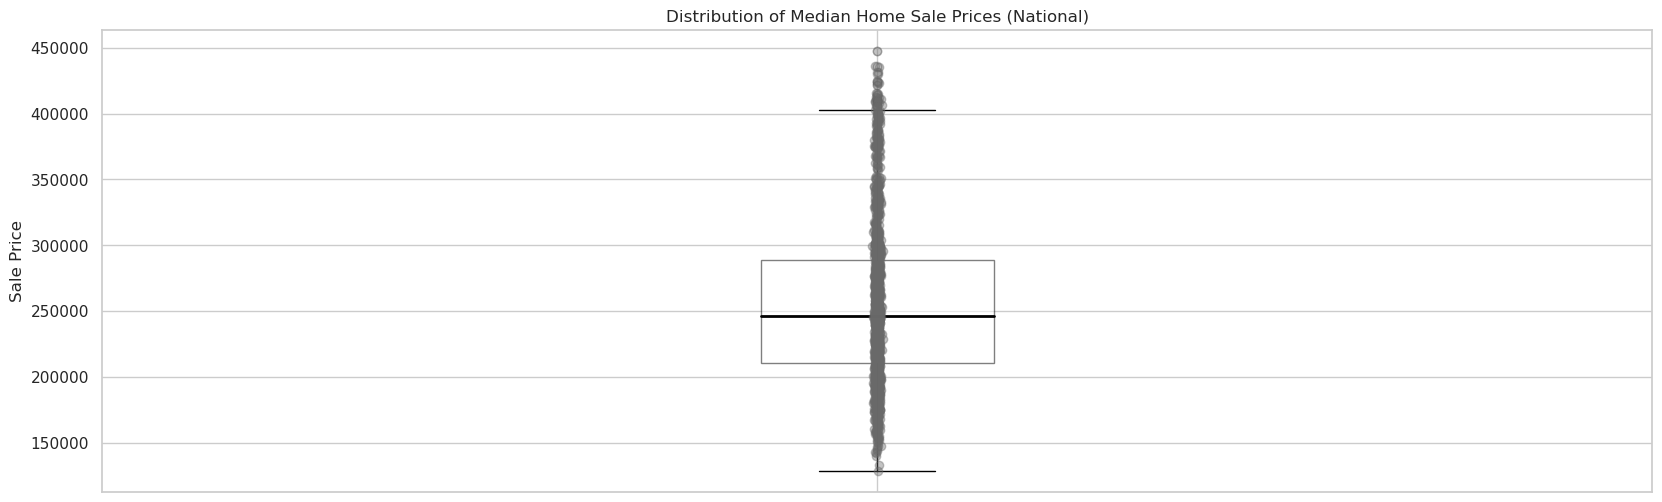

In [30]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.median_sale_price, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Home Sale Prices (National)")
axes.set_ylabel("Sale Price")
x = np.random.normal(1, 0.001, size=len(national_analysis.median_sale_price))
axes.plot(x, national_analysis.median_sale_price, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Most homes over the ten years sold for a median price around \\$254,865.95, but the values ranged from \\$128,691.00 to \\$447,445.00. Since these are national medians, it makes sense that we don't see major outliers. We can also try looking at the histogram to confirm the positive skew in the distribution:

In [31]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int(np.ceil( h))

Freeman Diaconis:  14017


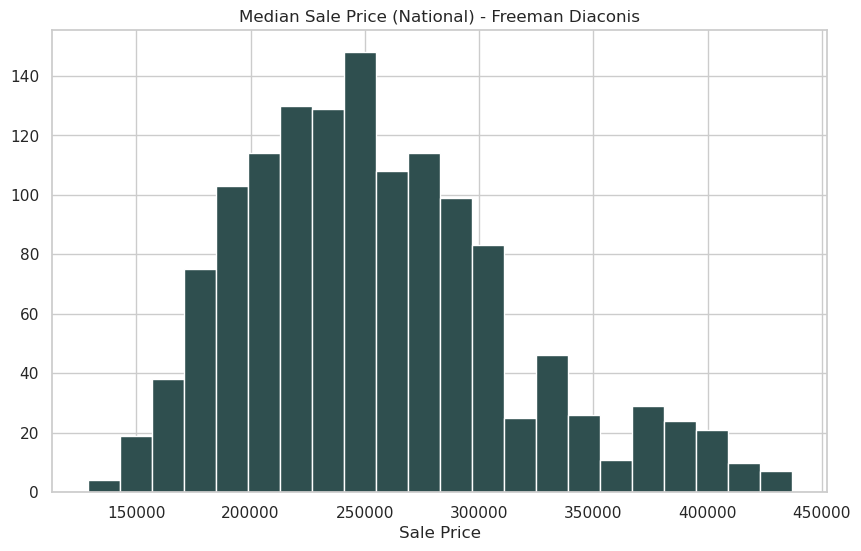

In [32]:
h = freeman_diaconis(national_analysis.median_sale_price)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.median_sale_price.min())
mx = int(national_analysis.median_sale_price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.median_sale_price,bins=bins, color="darkslategray")
axes.set_title("Median Sale Price (National) - Freeman Diaconis")
axes.set_xlabel("Sale Price")

plt.show()
plt.close()

Although we see the expected right skew to the distribution, there seems to be a smaller cohort that forms its own group at higher values. Let's look at the state and county table for similar trends, starting with the state descriptive statistics:

In [33]:
state_analysis.median_sale_price.describe()

count     28739.00
mean     245986.65
std      143947.05
min       10900.00
25%      157500.00
50%      208000.00
75%      288650.00
max     2920000.00
Name: median_sale_price, dtype: float64

The median sale price on a state level ranges from \\$10,900.00 to \\$2,920,000.00, which is a wider range than the National scale, with a mean of \\$245,986.65. This makes sense since we can start to see the higher end home prices in expensive states. In addition, we can expect a right skew to the distribution since the mean is greater than the median and the mean sits closer to the minimum value. Let's plot the box plot and histogram to visualize this:

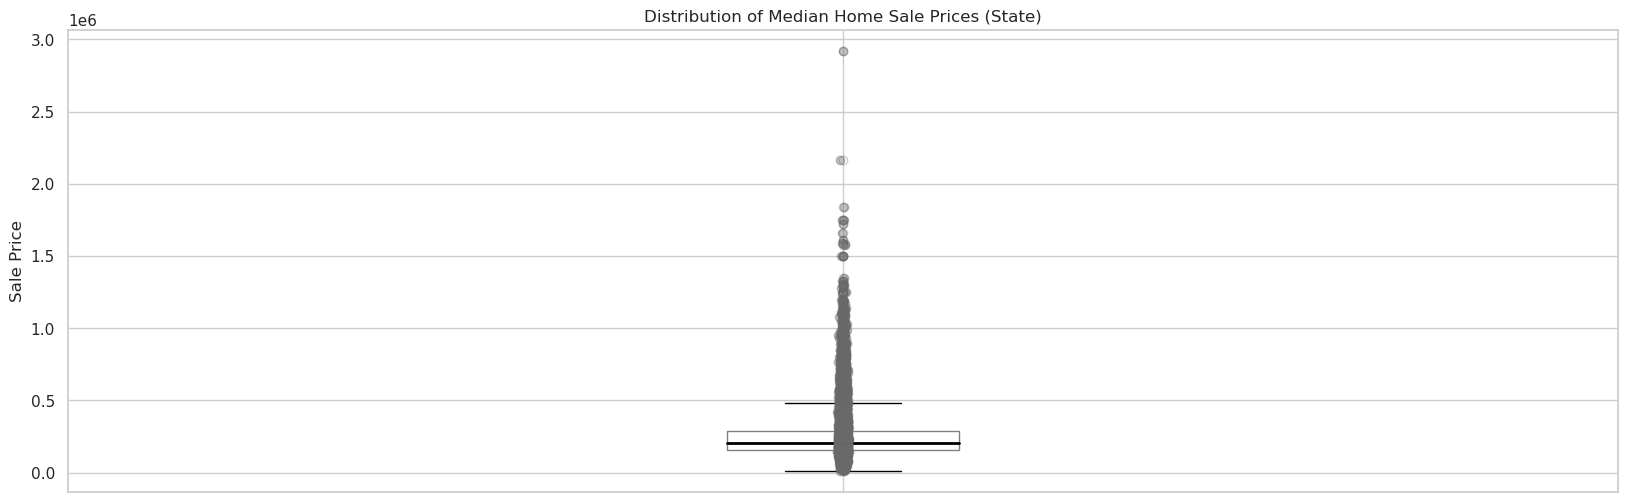

In [34]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.median_sale_price, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Home Sale Prices (State)")
axes.set_ylabel("Sale Price")
x = np.random.normal(1, 0.001, size=len(state_analysis.median_sale_price))
axes.plot(x, state_analysis.median_sale_price, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The right skew in the distribution is evident based on the box plot, since many values are sitting beyond the upper whisker. 

Freeman Diaconis:  8566


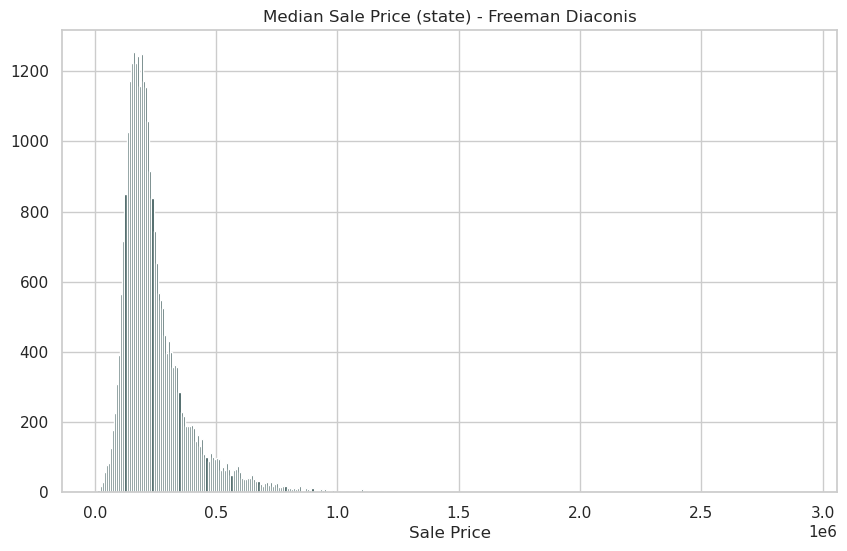

In [35]:
h = freeman_diaconis(state_analysis.median_sale_price)
print("Freeman Diaconis: ", h)
mn = int(state_analysis.median_sale_price.min())
mx = int(state_analysis.median_sale_price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_analysis.median_sale_price,bins=bins, color="darkslategray")
axes.set_title("Median Sale Price (state) - Freeman Diaconis")
axes.set_xlabel("Sale Price")

plt.show()
plt.close()

Based on both charts, we can see an obvious positive skew to the distributions, as discussed earlier. The cohort we noticed in the national data is not evident in the state data, so it may not be of significance. Let's continue to the county data:

In [36]:
county_analysis.median_sale_price.describe()

count       640957.00
mean        204743.22
std        1413653.56
min              0.00
25%         114165.00
50%         163500.00
75%         239500.00
max     1000000000.00
Name: median_sale_price, dtype: float64

The median sale price on a state level ranges from \\$0.00 to \\$1,000,000,000.00, with a mean of \\$204,743.22, although the max value seems unrealistic. Homes at zero dollars could be donations or giveaways of some kind and the high end of the range is the expensive homes in the U.S., which is more evident when we can see medians for individual counties. Once again, we expect the distribution of median sale prices for counties to be positively skewed. 

Before plotting the data, let's check on the max value to see if it seems possible:

In [37]:
curs.execute('SELECT * FROM County_analysis \
              WHERE median_list_price > 999999999;')

pd.DataFrame(curs.fetchall(), columns=county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,47809,2021-02-01,2021-02-28,30,county,1868,"Esmeralda County, NV",Nevada,NV,All Residential,292500.00,1000000000.00,48.11,1000000000.00,2.00,0.00,1.00,1,0.50,484.00,0.88,0.00,0.00
1,78882,2021-02-01,2021-02-28,30,county,1868,"Esmeralda County, NV",Nevada,NV,Single Family Residential,292500.00,1000000000.00,48.11,1000000000.00,2.00,0.00,1.00,1,0.50,484.00,0.88,0.00,0.00


The median sale price is very low compared to the median list price, which makes this high value seem unlikely. In addition, the median list price per square foot is the same, which does not make logical sense. Therefore, we may drop these two rows.

In [38]:
curs.execute('DELETE FROM County_analysis \
              WHERE median_list_price > 999999999;');

Let's plot the box plot and histogram to visualize the distribution:

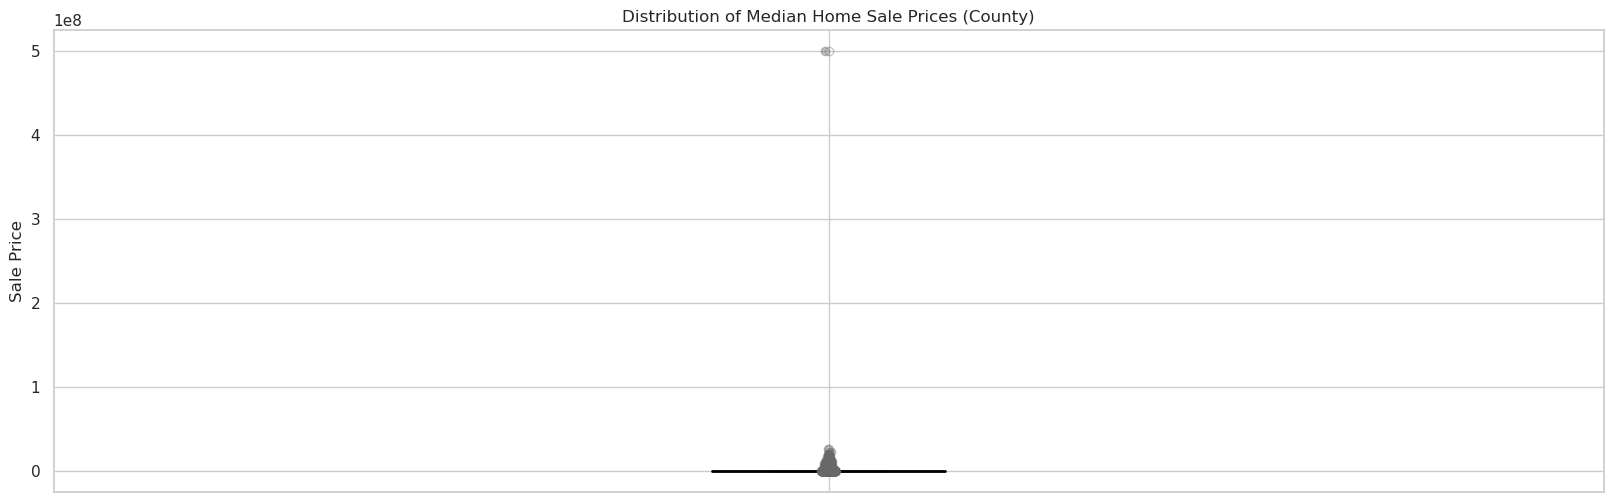

In [39]:
county_median_sale = county_analysis.median_sale_price[county_analysis.median_sale_price < 999999999]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_median_sale, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Home Sale Prices (County)")
axes.set_ylabel("Sale Price")
x = np.random.normal(1, 0.001, size=len(county_median_sale))
axes.plot(x, county_median_sale, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Due to the outliers in the box plot, we will cap the sale price for the histogram at one million, so it is easier to visualize the distribution:

Freeman Diaconis:  2865


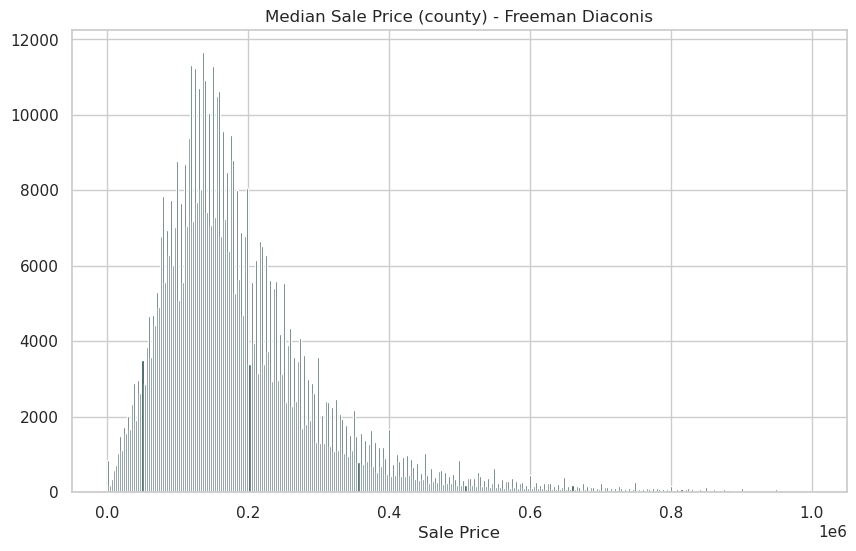

In [40]:
county_median_sale = county_analysis.median_sale_price[county_analysis.median_sale_price < 1000000]

h = freeman_diaconis(county_median_sale)
print("Freeman Diaconis: ", h)
mn = int(county_median_sale.min())
mx = int(county_median_sale.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_median_sale,bins=bins, color="darkslategray")
axes.set_title("Median Sale Price (county) - Freeman Diaconis")
axes.set_xlabel("Sale Price")

plt.show()
plt.close()

The distribution is very similar to the state data, where the second cohort we saw in the national data is not present. Overall, most homes sold for around \\$200,000 to \\$300,000 over the last decade, with some large outliers on occasion in expensive states or counties.

<a id="g"></a>
#### median_list_price

[Back to Contents](#NC)

We expect the median list price to be very similar to the median sale price data. The main difference is which value is higher at different points of time; we can predict that the median list price is lower than the median sale price during a sellers market and vice versa during a buyers market. Let's begin with the national data:

In [41]:
national_analysis.median_list_price.describe()

count     1364.00
mean    266670.72
std      60128.39
min     147474.00
25%     221120.50
50%     261288.00
75%     302478.75
max     467006.00
Name: median_list_price, dtype: float64

The median list price on a national level ranges from \\$147,474.00 to \\$467,006.00. For reference, the median sale price ranged from \\$128,691.00 to \\$447,445.00, so we see a narrower range of values in the list prices overall. The mean list price is slightly greater at \\$266,670.72, compared to the mean sale price of \\$254,865.95. Again, we will note a right skewed distribution since the mean is greater than the median, but the amount of skew is less than what we saw with the median sale prices. Let's plot the box plot and histogram to visualize this:

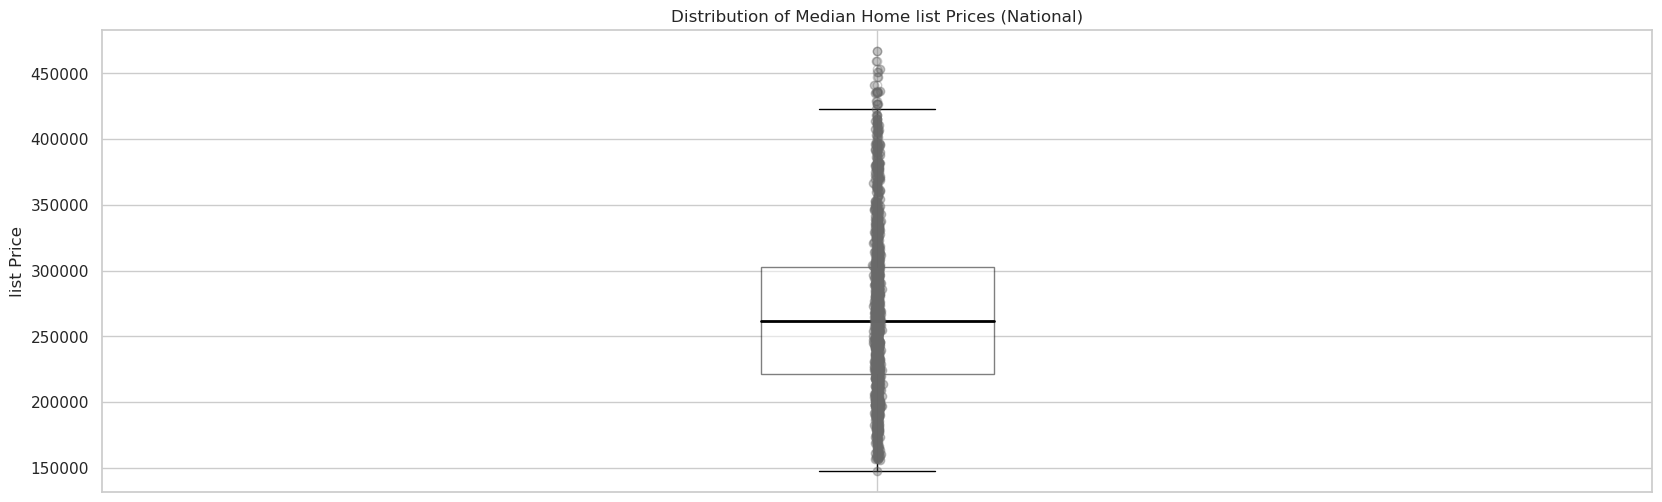

In [42]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.median_list_price, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Home list Prices (National)")
axes.set_ylabel("list Price")
x = np.random.normal(1, 0.001, size=len(national_analysis.median_list_price))
axes.plot(x, national_analysis.median_list_price, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The distribution appears relatively normal, although there are values sitting beyond the upper whisker indicating a positively skewed distribution. 

Freeman Diaconis:  14706


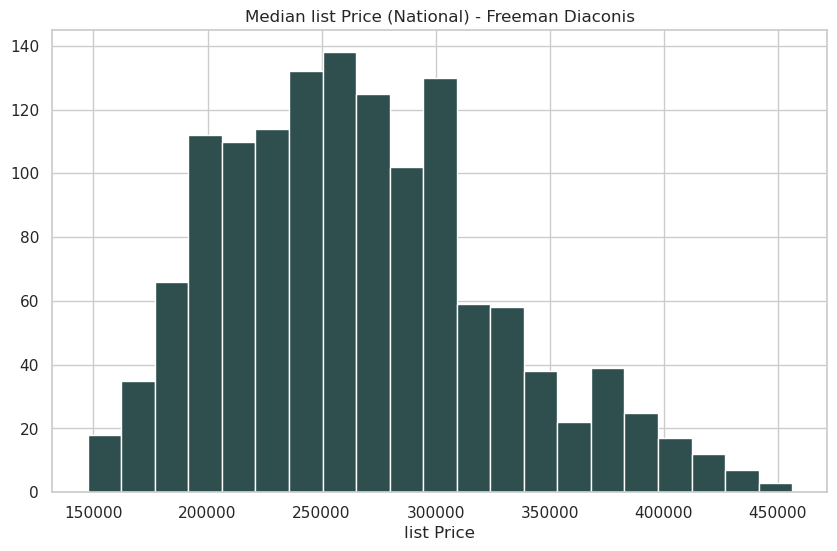

In [43]:
h = freeman_diaconis(national_analysis.median_list_price)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.median_list_price.min())
mx = int(national_analysis.median_list_price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.median_list_price,bins=bins, color="darkslategray")
axes.set_title("Median list Price (National) - Freeman Diaconis")
axes.set_xlabel("list Price")

plt.show()
plt.close()

The list prices and sale prices are distributed similarly, at least on a national level, with a slight positive skew since more homes are lower in value. Let's move on to the state data:

In [44]:
state_analysis.median_list_price.describe()

count     28739.00
mean     272214.76
std      126186.56
min           0.00
25%      187600.00
50%      239500.00
75%      318550.00
max     1113600.00
Name: median_list_price, dtype: float64

The median list price ranged from \\$0.00 to \\$1,113,600.00, with a mean of \\$272,214.76. For reference, the median sale price on a state level ranges from \\$10,900.00 to \\$2,920,000.00, with a mean of \\$245,986.65. We can note two things:

1. Most of the last decade has possibly been a *sellers market*, since most homes sold for more than the original list price, based on the range of list vs sale prices. 
2. The mean sale price is overall higher than the mean list price, on a state level, indicating a sellers market between 2012-2022. 

We have to consider how much of this is due to the **elevated home prices during the pandemic**, which will be evident when we look at pairwise relationships between time and prices later on. 

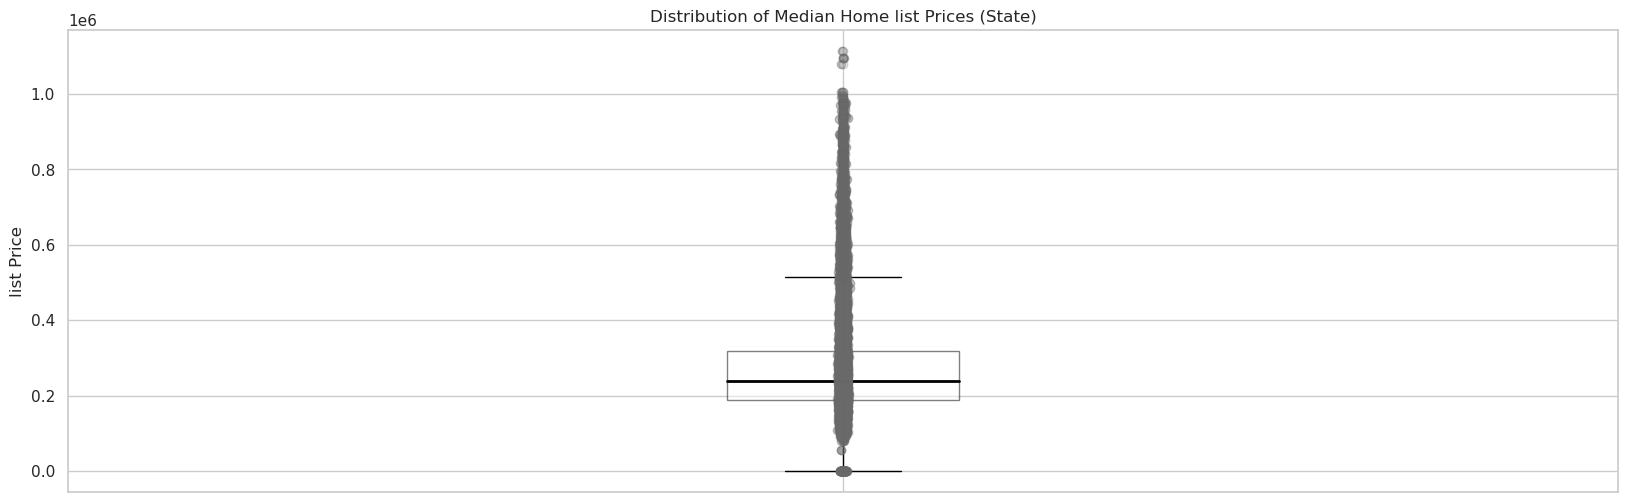

In [45]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.median_list_price, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Home list Prices (State)")
axes.set_ylabel("list Price")
x = np.random.normal(1, 0.001, size=len(state_analysis.median_list_price))
axes.plot(x, state_analysis.median_list_price, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

As expected, we see a positively skewed distribution for median list prices on the state level.

Freeman Diaconis:  8553


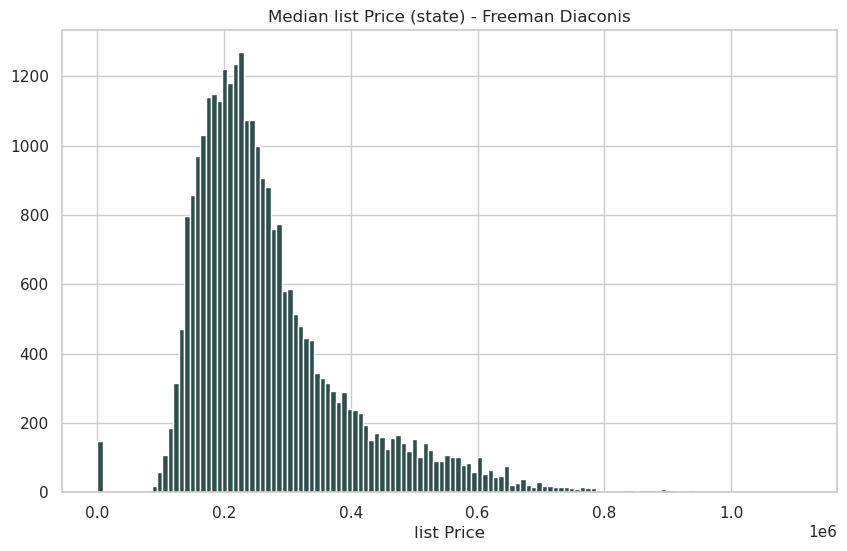

In [46]:
h = freeman_diaconis(state_analysis.median_list_price)
print("Freeman Diaconis: ", h)
mn = int(state_analysis.median_list_price.min())
mx = int(state_analysis.median_list_price.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_analysis.median_list_price,bins=bins, color="darkslategray")
axes.set_title("Median list Price (state) - Freeman Diaconis")
axes.set_xlabel("list Price")

plt.show()
plt.close()

Again, we see a right skewed distribution. We have to be mindful of the cohort of homes priced at \\$0.00, since it's not evident whether those homes were some kind of donation, giveaway, etc or they are just missing data points. We may opt to remove these values if it is evident they are from rows with missing data. Finally, we can look at the county data:

In [47]:
county_analysis.median_list_price.describe()

count       640957.00
mean        213373.24
std        1775066.56
min              0.00
25%         124900.00
50%         179900.00
75%         261400.00
max     1000000000.00
Name: median_list_price, dtype: float64

The range of values is the same as the median sale price, where we see an abnormally high maximum. In addition, the mean list price of \\$213,373.24 is actually higher than the mean sale price of \\$204,743.22. This hints at a different overall trend than the state data, where homes on the county level sold for less than they were listed for on average. We still expect a right skewed distribution, which we can visualize as follows:

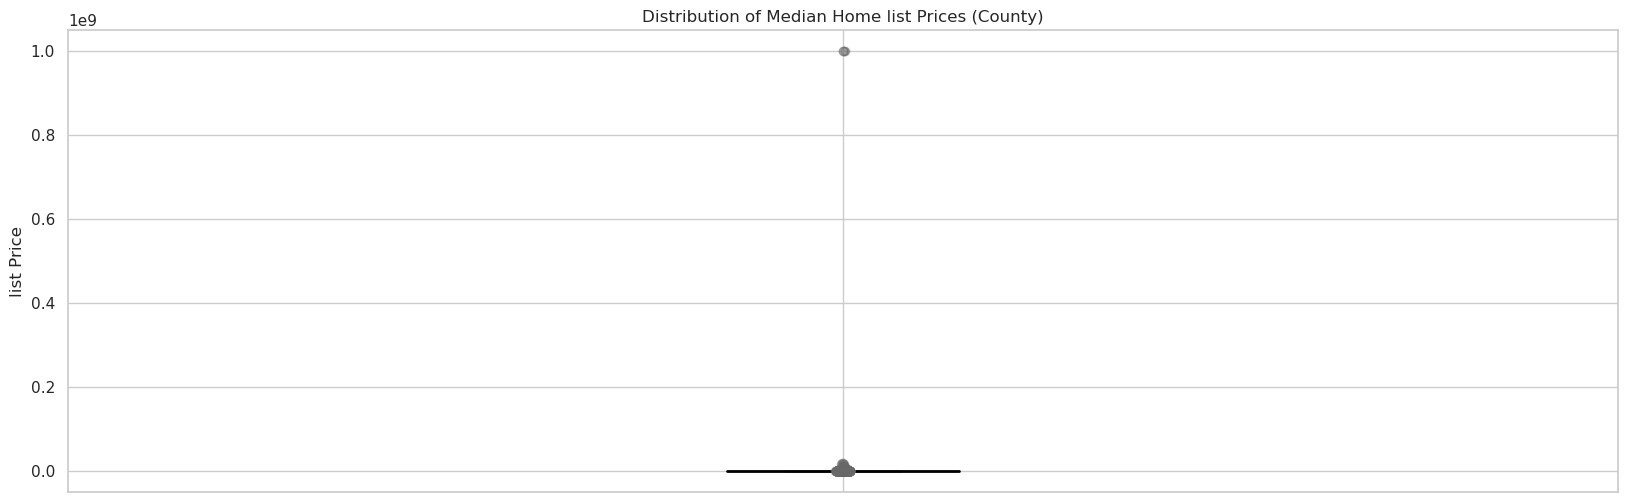

In [48]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.median_list_price, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Home list Prices (County)")
axes.set_ylabel("list Price")
x = np.random.normal(1, 0.001, size=len(county_analysis.median_list_price))
axes.plot(x, county_analysis.median_list_price, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

As we saw before, we see the extreme outlier which prevents us from visualizing the overall distribution. Let's look at counties with median list prices between 0 and 1 million instead:

Freeman Diaconis:  3152


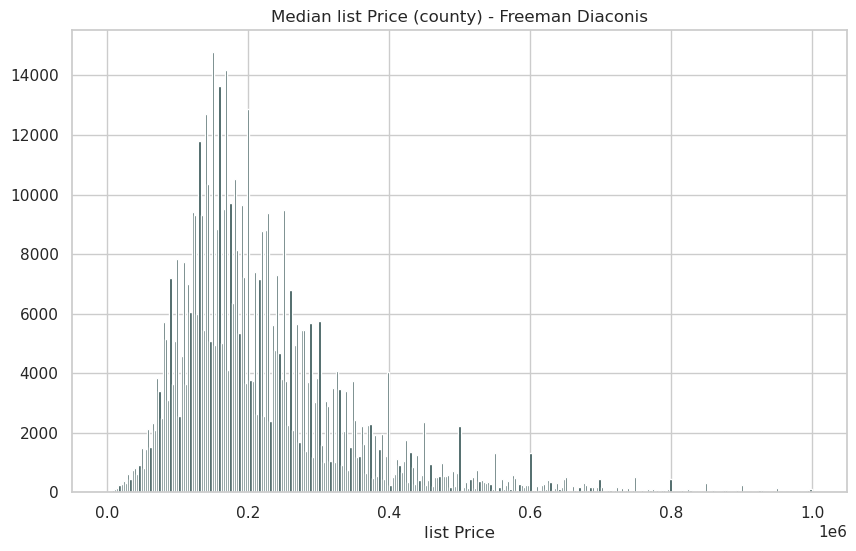

In [49]:
county_median_list = county_analysis.median_list_price[(county_analysis.median_list_price < 1000000) & (county_analysis.median_list_price > 0)]

h = freeman_diaconis(county_median_list)
print("Freeman Diaconis: ", h)
mn = int(county_median_list.min())
mx = int(county_median_list.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_median_list,bins=bins, color="darkslategray")
axes.set_title("Median list Price (county) - Freeman Diaconis")
axes.set_xlabel("list Price")

plt.show()
plt.close()

For median list prices between 0 and 1 million, which is a majority of counties in our data, we note a positively skewed distribution, as expected. 

<a id="h"></a>
#### median_ppsf

[Back to Contents](#NC)

The median ppsf, or price per square foot, is a numerical variable that should follow the trends we saw in median sale price. Let's start with the national data:

In [50]:
national_analysis.median_ppsf.describe()

count   1364.00
mean     150.65
std       39.42
min       68.00
25%      122.00
50%      145.10
75%      171.00
max      305.00
Name: median_ppsf, dtype: float64

The median ppsf on a national level ranged from \\$68.00 per $ft^{2}$ to \\$305 per $ft^{2}$, with a mean of \\$150.65 per $ft^{2}$. Since the mean is greater than the median, we can expect a slightly right skewed distribution, but not to a significant degree, which is expected based on what we saw with the median sale price. Let's visualize the distribution:

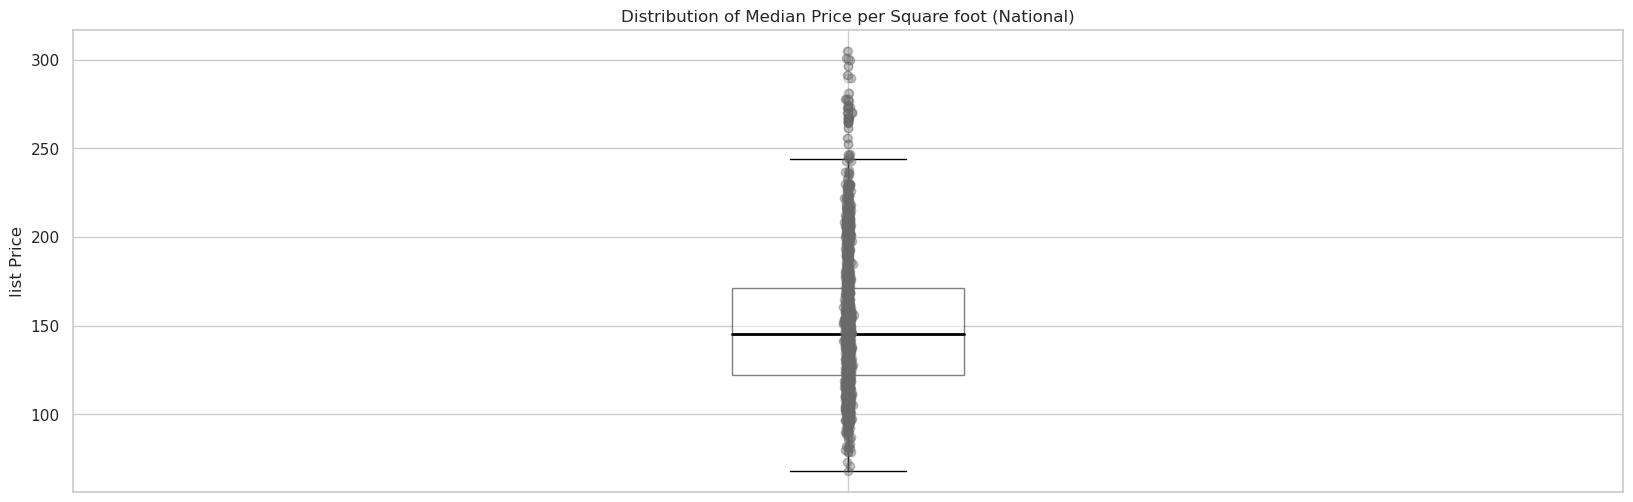

In [51]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.median_ppsf, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Price per Square foot (National)")
axes.set_ylabel("list Price")
x = np.random.normal(1, 0.001, size=len(national_analysis.median_ppsf))
axes.plot(x, national_analysis.median_ppsf, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The median ppsf box plot looks very similar to the median sale price, with a small cohort of values sitting beyond the upper whisker.

Freeman Diaconis:  9


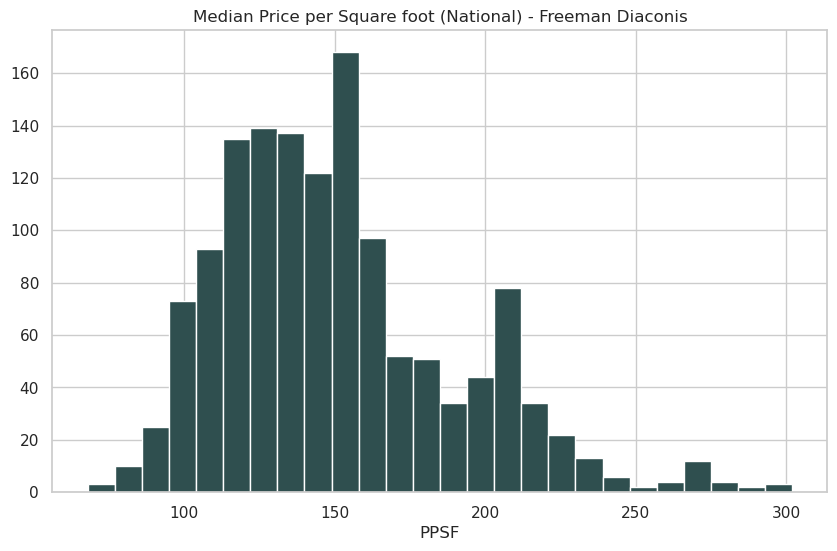

In [52]:
h = freeman_diaconis(national_analysis.median_ppsf)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.median_ppsf.min())
mx = int(national_analysis.median_ppsf.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.median_ppsf,bins=bins, color="darkslategray")
axes.set_title("Median Price per Square foot (National) - Freeman Diaconis")
axes.set_xlabel("PPSF")

plt.show()
plt.close()

Like the median sale price for the national data, we see a small cohort of values that form their own "distribution" near the higher prices. Since the median ppsf is consistent with the median sale price so far, we can assume that these values are true. As a reminder, this cohort is not evident on the state or county levels for median sale price. Is the same true for median ppsf? 

In [53]:
state_analysis.median_ppsf.describe()

count   28739.00
mean      152.70
std       211.72
min         0.00
25%        94.00
50%       125.00
75%       171.00
max     29585.00
Name: median_ppsf, dtype: float64

The median ppsf ranged from \\$0.00 per $ft^{2}$ to \\$29,585.00 per $ft^{2}$, with a mean of \\$152.70 per $ft^{2}$. As we saw with median sale price, we note that the mean increases slightly but the max value is much higher, since we start to see more outliers/large values related to expensive states that were not evident in overall averages. Also like median sale price, we expect a more right skewed distribution, as a result:

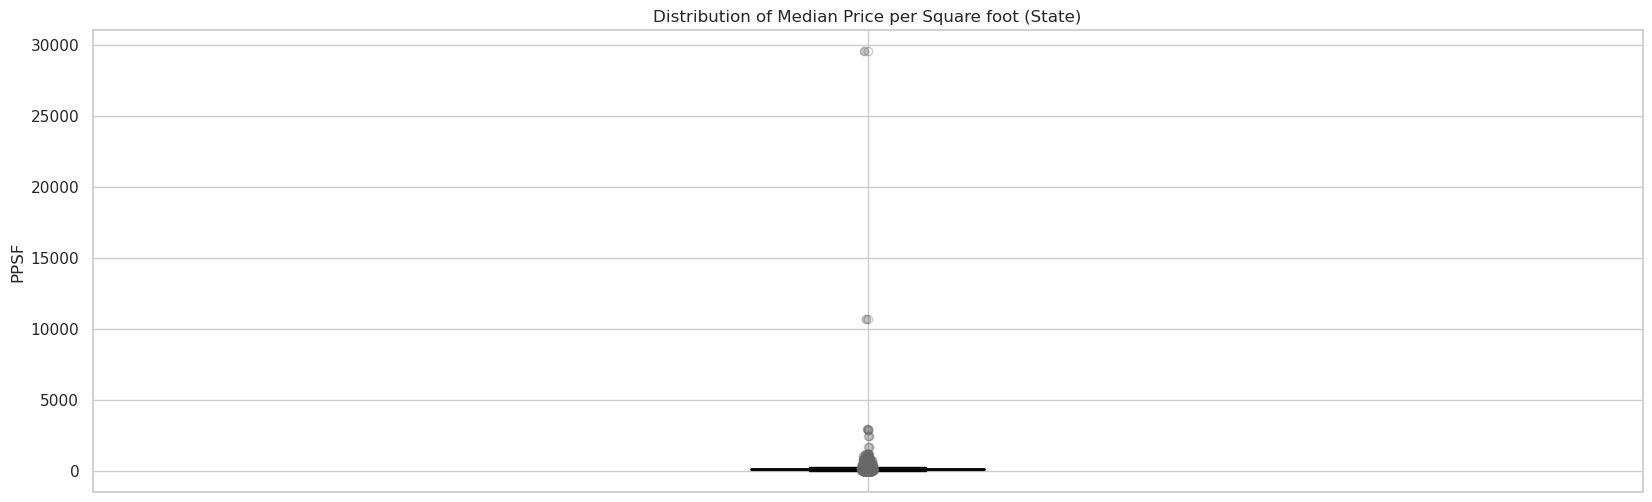

In [54]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.median_ppsf, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Price per Square foot (State)")
axes.set_ylabel("PPSF")
x = np.random.normal(1, 0.001, size=len(state_analysis.median_ppsf))
axes.plot(x, state_analysis.median_ppsf, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The box plot reveals several outlier states that had very high prices per square foot during certain time periods. Therefore, we can visualize all data points under \\$1,000 per $ft^{2}$, which is a majority of homes in the data: 

Freeman Diaconis:  6


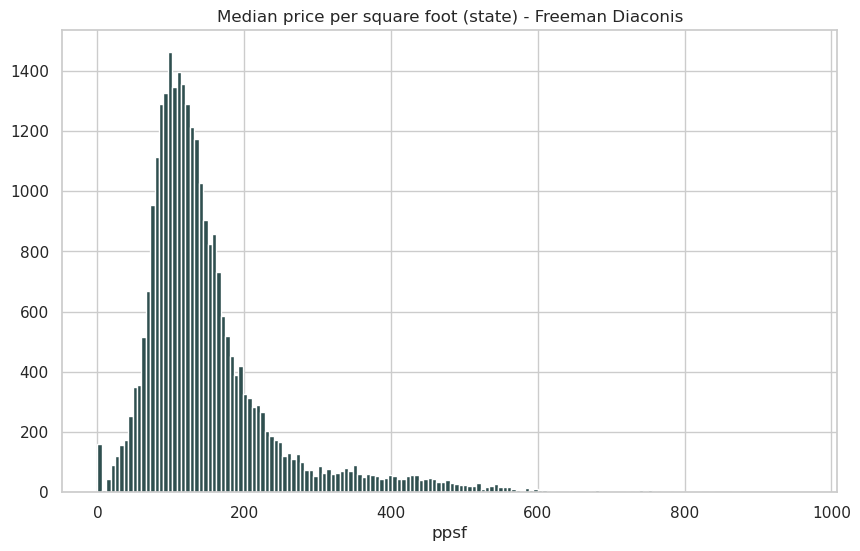

In [55]:
state_median_ppsf = state_analysis.median_ppsf[state_analysis.median_ppsf < 1000]

h = freeman_diaconis(state_median_ppsf)
print("Freeman Diaconis: ", h)
mn = int(state_median_ppsf.min())
mx = int(state_median_ppsf.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_median_ppsf, bins = bins, color="darkslategray")
axes.set_title("Median price per square foot (state) - Freeman Diaconis")
axes.set_xlabel("ppsf")

plt.show()
plt.close()

As expected, we see a right skewed distribution on the state level. The cohort around higher prices that is present in median sale price and median ppsf on the national level is not present on the state level, possibly because we needed to cut these values out to be able to visualize the data at all on a histogram. Finally, we can look at the county data:

In [56]:
county_analysis.median_ppsf.describe()

count       640957.00
mean          1708.71
std        1249157.76
min              0.00
25%             69.77
50%             98.11
75%            136.30
max     1000000000.00
Name: median_ppsf, dtype: float64

We are seeing an abnormally large county, which is unrealistic since this would be greater than the most expensive home in our data. Therefore, we will drop this row after we look at the specific row data:

In [57]:
curs.execute('SELECT * FROM County_analysis \
              WHERE median_ppsf > 999999999;');

pd.DataFrame(curs.fetchall(), columns = county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,438578,2020-08-01,2020-08-31,30,county,2239,"Union County, OH",Ohio,OH,Multi-Family (2-4 Unit),1000000000.00,0.00,1000000000.00,0.00,1.00,0.00,0.00,0,0.00,0.00,1.00,0.00,0.00


In addition to this outlier, we can note that the mean is a bit high. Should we remove other abnormally high median ppsf's? Let's check rows where the median ppsf is greater than $10,000.

In [58]:
curs.execute('SELECT * FROM County_analysis \
              WHERE median_ppsf > 10000;');

pd.DataFrame(curs.fetchall(), columns = county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,17819,2012-08-01,2012-08-31,30,county,1315,"Carroll County, MD",Maryland,MD,Condo/Co-op,140000.00,269000.00,81547.10,146.42,5.00,4.00,5.00,46,9.20,329.00,0.91,0.13,0.50
1,27619,2012-09-01,2012-09-30,30,county,1615,"Cape Girardeau County, MO",Missouri,MO,Condo/Co-op,170000.00,0.00,56666.70,0.00,1.00,0.00,0.00,3,3.00,116.00,0.97,0.00,0.00
2,31526,2014-02-01,2014-02-28,30,county,1608,"Bollinger County, MO",Missouri,MO,Single Family Residential,143000.00,45000.00,14825.70,82.57,2.00,0.00,1.00,11,5.50,378.00,0.96,0.00,0.00
3,31678,2012-04-01,2012-04-30,30,county,1608,"Bollinger County, MO",Missouri,MO,Single Family Residential,52900.00,64900.00,23000.00,59.00,3.00,2.00,1.00,13,4.30,61.00,1.01,0.00,0.00
4,32178,2012-01-01,2012-01-31,30,county,1608,"Bollinger County, MO",Missouri,MO,Single Family Residential,92000.00,74900.00,15544.30,53.02,2.00,0.00,4.00,16,8.00,170.00,0.91,0.00,0.00
5,45093,2013-01-01,2013-01-31,30,county,1825,"Lancaster County, NE",Nebraska,NE,Multi-Family (2-4 Unit),132000.00,145000.00,27784.80,85.03,2.00,2.00,5.00,35,17.50,12.00,0.99,0.00,1.00
6,55694,2020-03-01,2020-03-31,30,county,1120,"Boyle County, KY",Kentucky,KY,Multi-Family (2-4 Unit),130000.00,169250.00,115010.00,99.23,2.00,1.00,1.00,2,1.00,142.00,0.87,0.00,0.00
7,62598,2019-01-01,2019-01-31,30,county,1315,"Carroll County, MD",Maryland,MD,Condo/Co-op,168000.00,325000.00,168000.00,154.41,1.00,1.00,3.00,6,6.00,70.00,0.95,0.17,0.00
8,87290,2012-04-01,2012-04-30,30,county,1608,"Bollinger County, MO",Missouri,MO,All Residential,52900.00,64900.00,23000.00,59.00,3.00,2.00,1.00,13,4.30,61.00,1.01,0.00,0.00
9,95262,2014-02-01,2014-02-28,30,county,1608,"Bollinger County, MO",Missouri,MO,All Residential,143000.00,45000.00,14825.70,82.57,2.00,0.00,1.00,11,5.50,378.00,0.96,0.00,0.00


When compared to the median list ppsf, which we will look at next, these median ppsf's seem unrealistic. We expect these two variables, like median price and median list price, to be similar. Therefore, let's drop these rows from our sql database:

In [59]:
curs.execute('DELETE FROM County_analysis \
              WHERE median_ppsf > 10000;');

Let's check the updated mean to see if it now makes sense based on our expectations:

In [60]:
curs.execute('SELECT AVG(median_ppsf) \
              FROM County_analysis;');

pd.DataFrame(curs.fetchall(), columns=['Average median ppsf'])

,Average median ppsf
0,117.27


This mean is much more sensible. Now we can visualize the data:

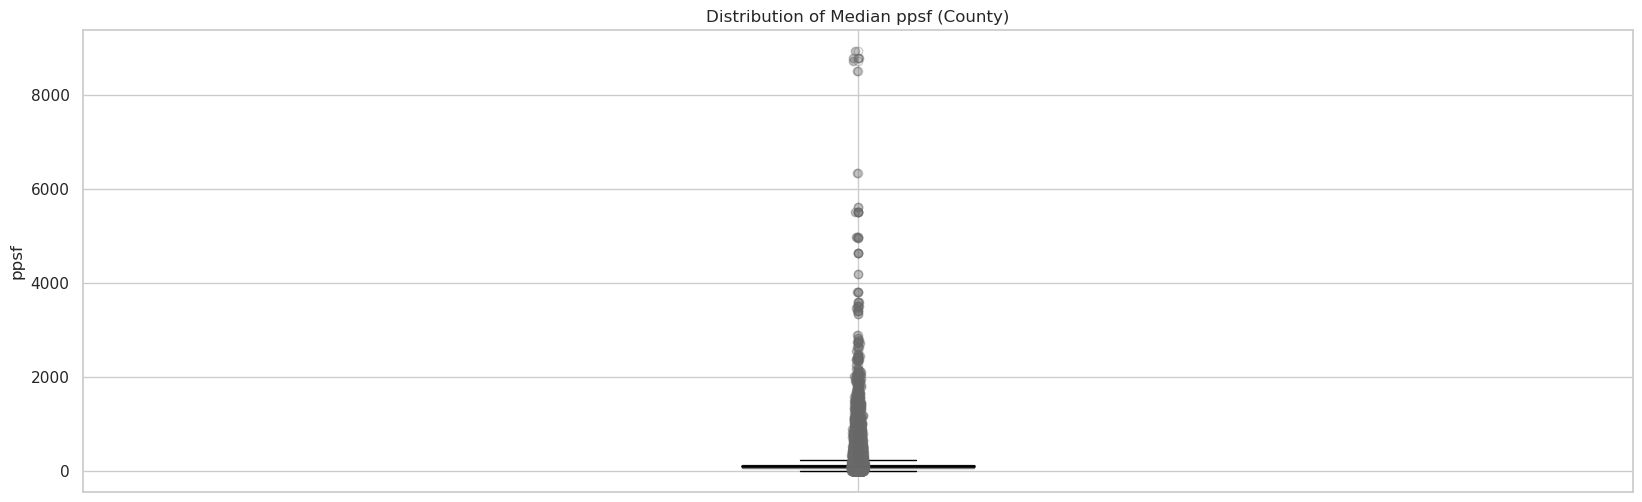

In [61]:
county_median_ppsf = county_analysis.median_ppsf[county_analysis.median_ppsf < 10000]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_median_ppsf, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median ppsf (County)")
axes.set_ylabel("ppsf")
x = np.random.normal(1, 0.001, size=len(county_median_ppsf))
axes.plot(x, county_median_ppsf, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Once again, we have some large values which will make the histogram difficult to visualize. We will look at median ppsf's under \\$1,000.00 per $ft^{2}$:

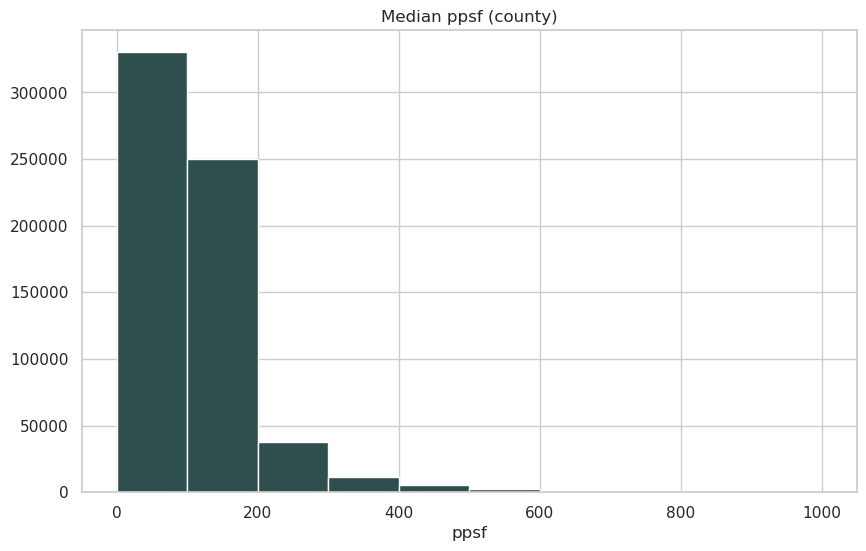

In [62]:
county_median_ppsf = county_analysis.median_ppsf[county_analysis.median_ppsf < 1000]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_median_ppsf, color="darkslategray")
axes.set_title("Median ppsf (county)")
axes.set_xlabel("ppsf")

plt.show()
plt.close()

On a county level, the distribution for median ppsf appears exponential, or heavily right skewed. This aligns with what we would expect, since most homes will have a lower price with occasional large prices. We should also note that there were large outliers affecting the mean, since the original mean is not representative of the histogram.

<a id="i"></a>
#### median_list_ppsf

[Back to Contents](#NC)

Like median ppsf, we expect median list ppsf to follow the trends seen in the median list price variable. We can start with the basic statistics for the national data:

In [63]:
national_analysis.median_list_ppsf.describe()

count   1364.00
mean     157.25
std       40.99
min       77.00
25%      127.00
50%      150.50
75%      179.00
max      312.00
Name: median_list_ppsf, dtype: float64

The median list ppsf ranges from \\$77.00 per $ft^{2}$ to \\$312.00 per $ft^{2}$, with a mean of \\$157.25 per $ft^{2}$. On a national level, the median list ppsf is higher than the median ppsf, indicating that homes sold for a lower ppsf than the average listed price per square foot. 

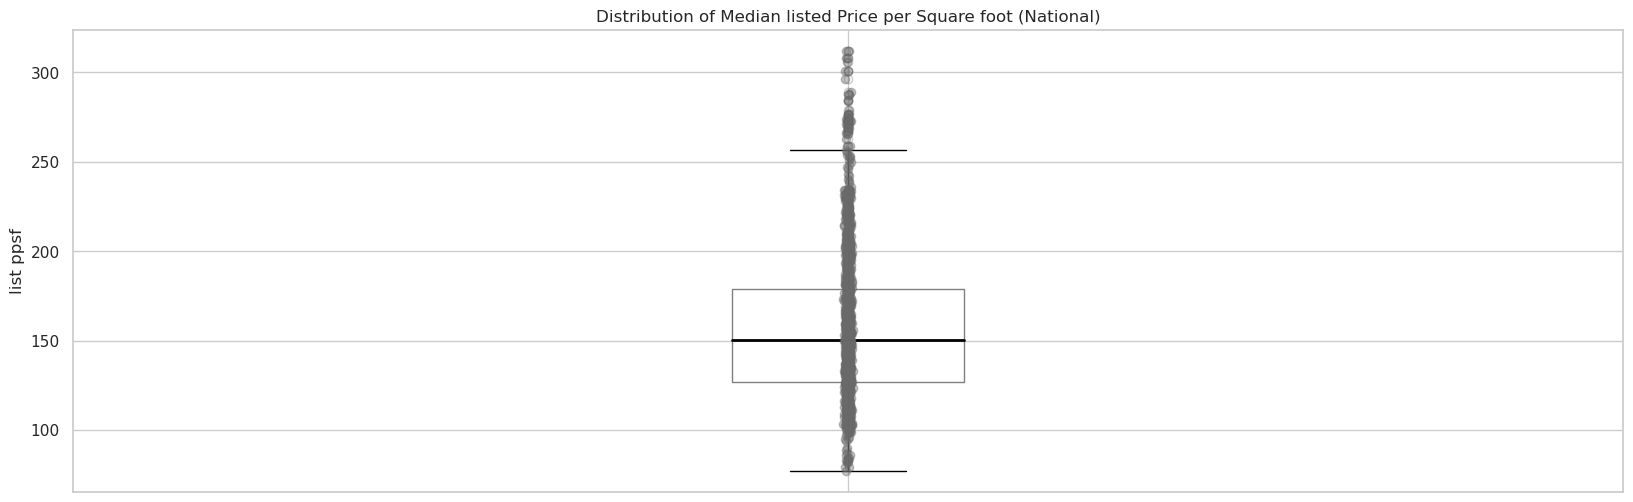

In [64]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.median_list_ppsf, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median listed Price per Square foot (National)")
axes.set_ylabel("list ppsf")
x = np.random.normal(1, 0.001, size=len(national_analysis.median_list_ppsf))
axes.plot(x, national_analysis.median_list_ppsf, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Similar to all the price variables so far, we are seeing a right skewed distribution which is less apparent in the national data.

Freeman Diaconis:  10


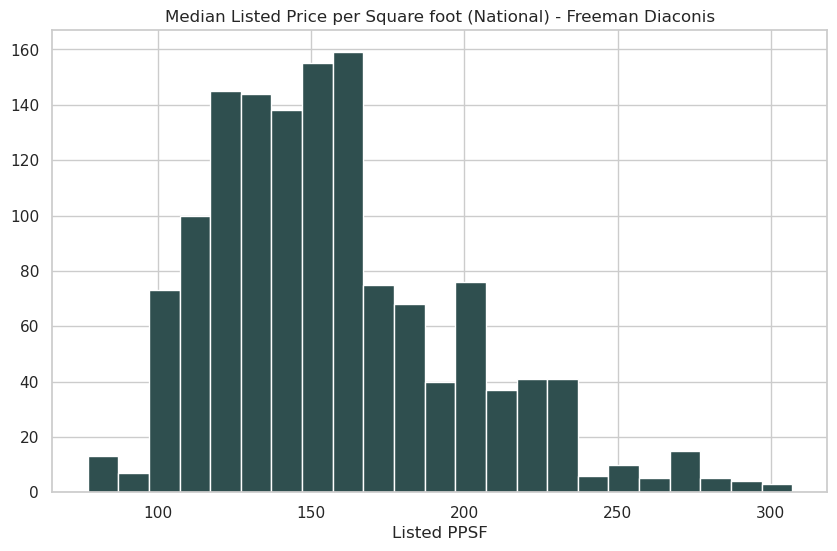

In [65]:
h = freeman_diaconis(national_analysis.median_list_ppsf)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.median_list_ppsf.min())
mx = int(national_analysis.median_list_ppsf.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.median_list_ppsf,bins=bins, color="darkslategray")
axes.set_title("Median Listed Price per Square foot (National) - Freeman Diaconis")
axes.set_xlabel("Listed PPSF")

plt.show()
plt.close()

The smaller cohort is less evident in the median list ppsf compared to the median ppsf, but overall, we are seeing a similarly shaped distribution, so there isn't any new findings. Let's move on to the state data:

In [66]:
state_analysis.median_list_ppsf.describe()

count   28739.00
mean      162.41
std        97.75
min         0.00
25%       107.00
50%       134.00
75%       177.00
max      1281.00
Name: median_list_ppsf, dtype: float64

The median list ppsf ranges from \\$0.00 per $ft^{2}$ to \\$1281.00 per $ft^{2}$, with a mean of \\$162.41 per $ft^{2}$, which indicates a right skewed distribution. This range is much more narrow compared to the median ppsf, which ranged from \\$0.00 per $ft^{2}$ to \\$29,585.00 per $ft^{2}$, with a mean of \\$152.70 per $ft^{2}$. This could potentially be an outlier in the median ppsf variable, since the mean for the median list ppsf is still higher than the median ppsf on a state level. Let's look at any row where the median ppsf is greater than the highest median list ppsf to see if anything stands out:

In [67]:
curs.execute('SELECT * FROM State_analysis \
              WHERE median_ppsf > 1281;');

pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,477,2017-11-01,2017-11-30,30,state,34,Tennessee,Tennessee,TN,Multi-Family (2-4 Unit),153200.00,220400.00,29585.00,127.00,40.00,23.00,43.00,134,3.40,58.00,0.94,0.10,0.19
1,11339,2019-07-01,2019-07-31,30,state,34,Tennessee,Tennessee,TN,Multi-Family (2-4 Unit),164900.00,238500.00,2884.00,131.00,49.00,47.00,71.00,157,3.20,57.00,0.95,0.15,0.19
2,23179,2019-01-01,2019-01-31,30,state,12,New Jersey,New Jersey,NJ,Townhouse,199300.00,268900.00,2954.00,169.00,455.00,380.00,851.00,2740,6.00,72.00,0.96,0.22,0.22
3,23265,2017-02-01,2017-02-28,30,state,36,Texas,Texas,TX,Multi-Family (2-4 Unit),209600.00,245100.00,2459.00,123.00,198.00,179.00,286.00,621,3.10,45.00,0.98,0.12,0.41
4,25922,2013-01-01,2013-01-31,30,state,6,Nebraska,Nebraska,NE,Multi-Family (2-4 Unit),93000.00,146000.00,10710.00,83.00,6.00,3.00,13.00,80,13.30,30.00,0.97,0.00,0.38
5,28645,2012-03-01,2012-03-31,30,state,18,North Carolina,North Carolina,NC,Multi-Family (2-4 Unit),134900.00,222400.00,1701.00,107.00,11.00,6.00,16.00,78,7.10,73.00,0.90,0.00,0.04


Something isn't adding up. We would expect the median ppsf and median list ppsf to be similar, at least to some extent. Therefore, these are likely outliers and can be dropped. Since we cannot be sure that homes that sold for several thousand per square foot are innacurate, we will only drop the obvious outliers, which are over \\$10,000 per $ft^{2}$.

In [68]:
curs.execute('DELETE FROM State_analysis \
              WHERE median_ppsf > 10000;');

Now, let's visualize the data:

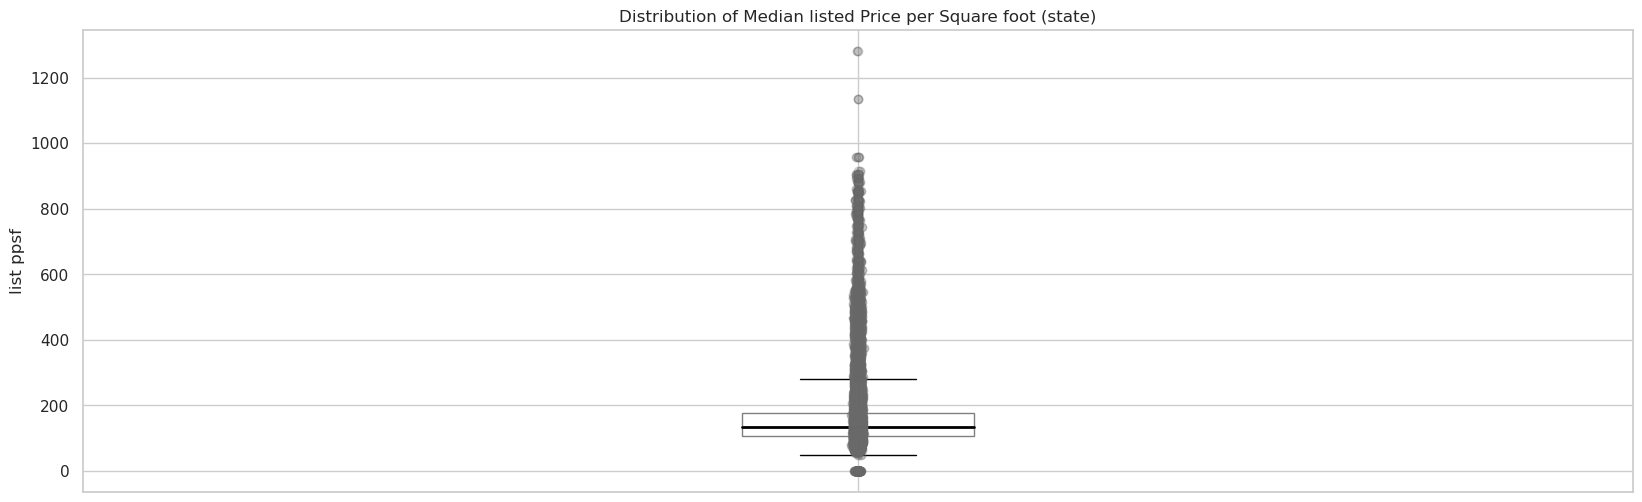

In [69]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.median_list_ppsf, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median listed Price per Square foot (state)")
axes.set_ylabel("list ppsf")
x = np.random.normal(1, 0.001, size=len(state_analysis.median_list_ppsf))
axes.plot(x, state_analysis.median_list_ppsf, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

We are seeing a right skewed distribution with a decent amount of data points beyond the upper quartile/whisker. How does that histogram look?

Freeman Diaconis:  5


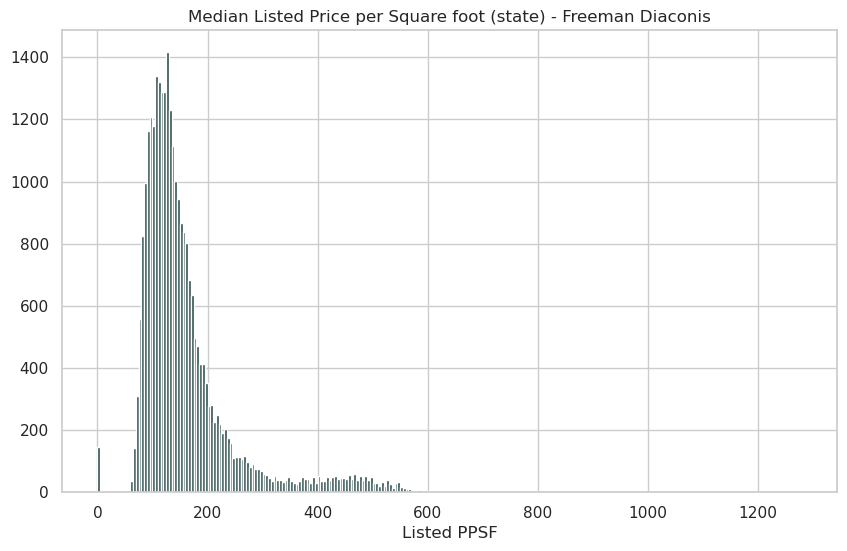

In [70]:
h = freeman_diaconis(state_analysis.median_list_ppsf)
print("Freeman Diaconis: ", h)
mn = int(state_analysis.median_list_ppsf.min())
mx = int(state_analysis.median_list_ppsf.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_analysis.median_list_ppsf,bins=bins, color="darkslategray")
axes.set_title("Median Listed Price per Square foot (state) - Freeman Diaconis")
axes.set_xlabel("Listed PPSF")

plt.show()
plt.close()

The distribution is positively skewed but the number of points sitting beyond the mean aren't as significant as the box plot depicted. They extend to a larger maximum value but the number of points is not as major as the box plot depicted. We can continue with the county data:

In [71]:
county_analysis.median_list_ppsf.describe()

count       640957.00
mean          3243.49
std        1766445.28
min              0.00
25%             76.18
50%            104.25
75%            141.66
max     1000000000.00
Name: median_list_ppsf, dtype: float64

The median list ppsf ranges from \\$0.00 per $ft^{2}$ to \\$1000000000.00 per $ft^{2}$, with a mean of \\$3243.25 per $ft^{2}$. This is very different to the state data results and is a similar issue to the median ppsf for the county data. This row was likely removed from the MySQL database already when we dropped outliers stating 1 billion earlier, but let's look more closely at values above the mean to see if this row(s) can be dropped:

In [72]:
curs.execute('SELECT * FROM County_analysis \
              WHERE median_list_ppsf >3243.49;');

pd.DataFrame(curs.fetchall(), columns = county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,123471,2012-07-01,2012-07-31,30,county,1608,"Bollinger County, MO",Missouri,MO,Single Family Residential,24000.00,29700.00,31.54,9900.00,1.00,0.00,1.00,8,8.00,301.00,0.86,0.00,0.00
1,138453,2012-05-01,2012-05-31,30,county,1608,"Bollinger County, MO",Missouri,MO,Single Family Residential,62500.00,117450.00,63.45,15027.20,3.00,0.00,2.00,10,3.30,133.00,0.97,0.00,0.00
2,164168,2014-07-01,2014-07-31,30,county,2225,"Pike County, OH",Ohio,OH,Single Family Residential,87500.00,52900.00,44.64,26450.00,2.00,0.00,1.00,7,3.50,43.00,1.10,0.00,0.00
3,173699,2012-07-01,2012-07-31,30,county,1608,"Bollinger County, MO",Missouri,MO,All Residential,24000.00,29700.00,31.54,9900.00,1.00,0.00,1.00,8,8.00,301.00,0.86,0.00,0.00
4,190926,2013-01-01,2013-01-31,30,county,400,"Mesa County, CO",Colorado,CO,All Residential,125000.00,134900.00,52.70,134900.00,1.00,1.00,1.00,20,20.00,70.00,0.98,0.00,0.00
5,194186,2014-07-01,2014-07-31,30,county,2225,"Pike County, OH",Ohio,OH,All Residential,87500.00,52900.00,44.64,26450.00,2.00,0.00,1.00,7,3.50,43.00,1.10,0.00,0.00
6,196408,2012-02-01,2012-02-29,30,county,1608,"Bollinger County, MO",Missouri,MO,All Residential,68500.00,90000.00,34.50,24000.00,2.00,2.00,3.00,17,8.50,43.00,0.91,0.00,0.00
7,206121,2016-01-01,2016-01-31,30,county,308,"Colusa County, CA",California,CA,All Residential,265000.00,18500000.00,131.25,4033.14,2.00,0.00,1.00,8,4.00,0.00,0.97,0.00,0.00
8,235652,2012-05-01,2012-05-31,30,county,1608,"Bollinger County, MO",Missouri,MO,All Residential,62500.00,117450.00,63.45,15027.20,3.00,0.00,2.00,10,3.30,133.00,0.97,0.00,0.00
9,265670,2019-06-01,2019-06-30,30,county,2359,"Wheeler County, OR",Oregon,OR,Single Family Residential,2159000.00,110000.00,431.80,110000.00,1.00,1.00,1.00,3,3.00,518.00,0.94,0.67,1.00


Out of over 1,000 entries, there are only 30 rows where the listed ppsf is higher than the mean. Let's check the average from the more updated MySQL table:

In [73]:
curs.execute('SELECT AVG(median_list_ppsf) \
              FROM County_analysis;');

pd.DataFrame(curs.fetchall(), columns=['Average median list ppsf'])

,Average median list ppsf
0,122.93


This makes much more sense. We can rest assured that the updated MySQL database is close to accurate, but we should drop any rows where the median list ppsf is over 10,000, similar to what we did for median ppsf, since these rows are wildly greater than the median ppsf which does not make logical sense. 

*Keep in mind, I am refraining from updating or recreating the pandas dataframe due to memory demands since we are updating the MySQL database as we explore the variables. Instead, we will index the pandas dataframe as needed and create a new dataframe in later notebooks with the cleaned data in MySQL.*

In [74]:
curs.execute('DELETE FROM County_analysis \
              WHERE median_list_ppsf > 10000;');

Now, we can visualize the data where the median list ppsf is less than 10000, which will match the sql database:

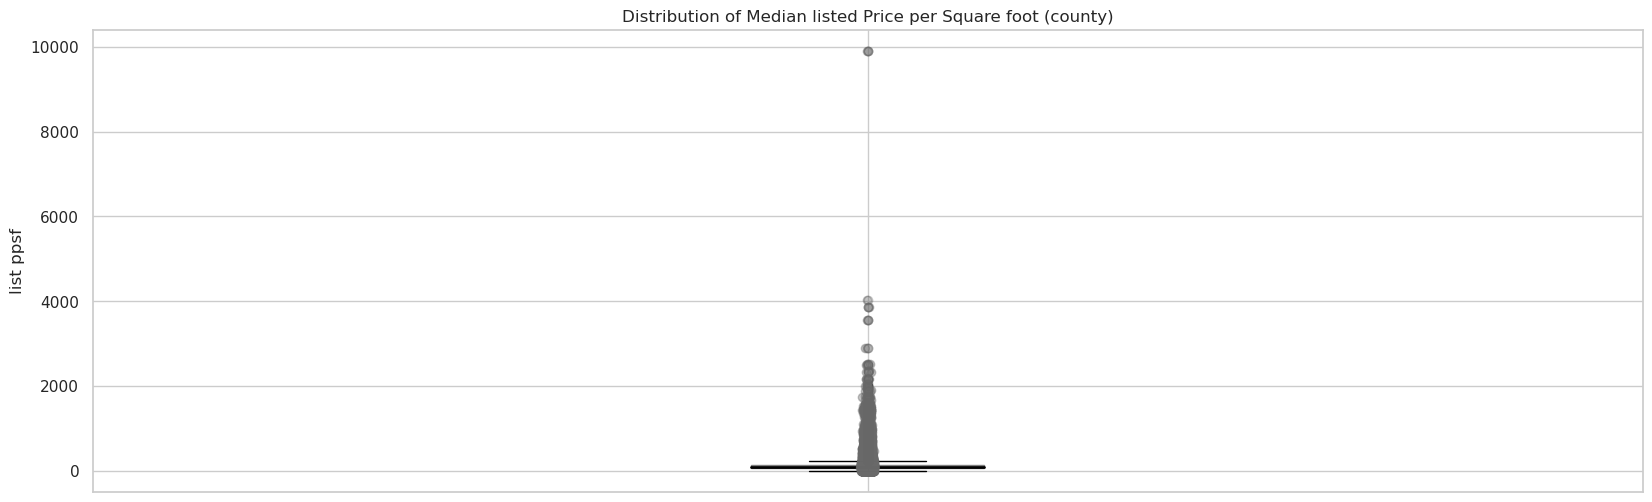

In [75]:
county_median_list_ppsf = county_analysis.median_list_ppsf[county_analysis.median_list_ppsf < 10000]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_median_list_ppsf, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median listed Price per Square foot (county)")
axes.set_ylabel("list ppsf")
x = np.random.normal(1, 0.001, size=len(county_median_list_ppsf))
axes.plot(x, county_median_list_ppsf, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

There is a right skewed distribution, but we can note that some of the values are still large outliers. Let's plot the histogram with values under 1000:

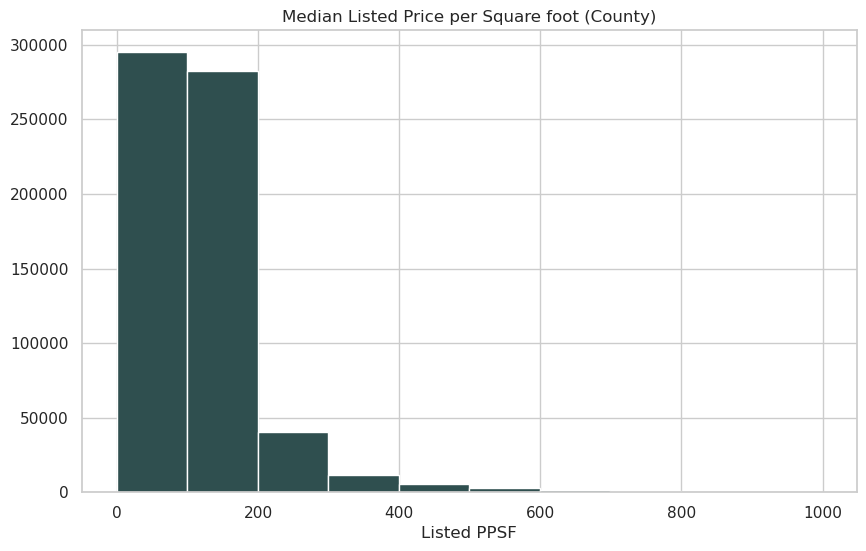

In [76]:
county_median_list_ppsf = county_analysis.median_list_ppsf[county_analysis.median_list_ppsf < 1000]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_median_list_ppsf, color="darkslategray")
axes.set_title("Median Listed Price per Square foot (County)")
axes.set_xlabel("Listed PPSF")

plt.show()
plt.close()

We see a similar shape to the variable median ppsf, which is expected. The distribution is skewed heavily to the right since a majority of homes sit around the mean of $119, with few outliers that have much larger median list ppsf's.

<a id="j"></a>
#### homes_sold

[Back to Contents](#NC)

Based on common domain knowledge, we would expect the homes sold variable to increase during strong periods in the economy and decrease during recessions. We also expect this variable to closely relate to the inventory variable, since higher inventory would mean more potential home sales. We will begin with basic statistics:

In [77]:
national_analysis.homes_sold.describe()

count     1364.00
mean    273890.71
std     222731.19
min       6198.00
25%      49283.03
50%     332292.50
75%     478581.00
max     734128.00
Name: homes_sold, dtype: float64

On a national scale, the number of homes sold in a 30-day duration ranged from 6,198 and 734,128 homes, with a mean of about 273,890 homes. The mean is lower than the median, which indicates a left skewed distribution. Let's try visualizing the data:

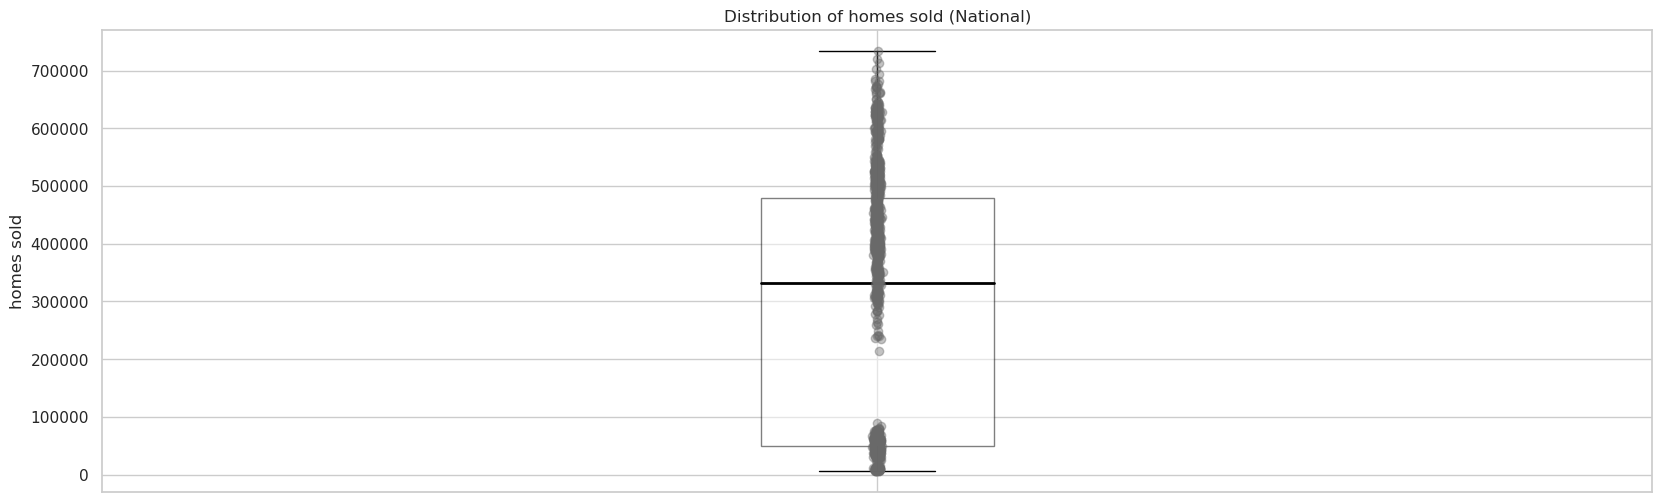

In [78]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.homes_sold, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of homes sold (National)")
axes.set_ylabel("homes sold")
x = np.random.normal(1, 0.001, size=len(national_analysis.homes_sold))
axes.plot(x, national_analysis.homes_sold, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

There seems to be a gap in the data around 100,000 and 200,000 homes. However, the mean and minimum implies that there should be some homes around this range. The standard deviation hints to this gap since it is so large. This gap is also influencing the mean and median, so we may not actually have a left skewed distribution. We can try looking for rows that had 100,000 and 200,000 homes sold to see if these points exist at all, or extend the range slightly to see values around it:

In [79]:
curs.execute('SELECT * FROM National_analysis \
              WHERE homes_sold BETWEEN 80000 AND 220000;');

pd.DataFrame(curs.fetchall(), columns=national_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,804,2021-04-01,2021-04-30,30,national,1400,National,U.S.,US,Condo/Co-op,300860.00,308149.00,265.00,274.00,83660.00,76929.00,92820.00,131243,1.57,29.00,1.00,0.08,0.49
1,872,2021-05-01,2021-05-31,30,national,1400,National,U.S.,US,Condo/Co-op,300261.00,310811.00,265.00,273.00,80291.00,76666.00,87308.00,128714,1.60,25.00,1.00,0.08,0.50
2,1085,2021-06-01,2021-06-30,30,national,1400,National,U.S.,US,Condo/Co-op,303706.00,306192.00,267.00,274.00,88582.00,76873.00,92224.00,130743,1.48,23.00,1.01,0.09,0.48
3,1250,2012-01-01,2012-01-31,30,national,1400,National,U.S.,US,Single Family Residential,164937.00,189941.00,87.00,99.00,214217.00,144535.00,367441.00,1589904,7.42,96.00,0.96,0.06,0.26


It seems like most time periods had under 100,000 homes sold, with another cohort at the higher numbers. We can try visualizing the data in a histogram as follows:

Freeman Diaconis:  77431


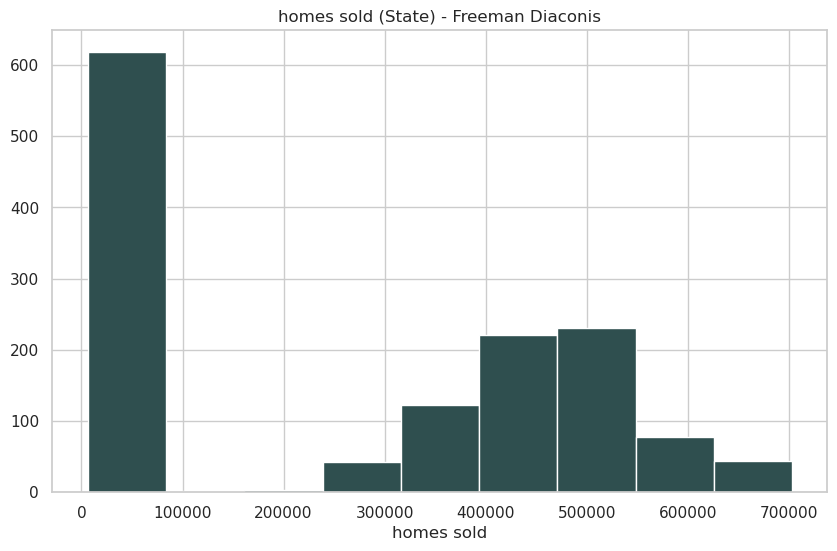

In [80]:
h = freeman_diaconis(national_analysis.homes_sold)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.homes_sold.min())
mx = int(national_analysis.homes_sold.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.homes_sold,bins=bins, color="darkslategray")
axes.set_title("homes sold (State) - Freeman Diaconis")
axes.set_xlabel("homes sold")

plt.show()
plt.close()

As discussed, most time duration's had under 100,000 homes sold. Perhaps, the time periods with more homes sold are from times of economic growth and the times with low homes sold are from high demand/limited inventory (i.e pandemic?). This will be more evident when we look at any time series analysis later on. We can continue to the state data to see if this variable is usable and if the gap makes sense:

In [81]:
state_analysis.homes_sold.describe()

count   28739.00
mean     2496.85
std      4834.95
min         1.00
25%        86.00
50%       535.00
75%      2718.00
max     51158.00
Name: homes_sold, dtype: float64

On a state scale, the number of homes sold in a 30-day duration ranged from 1 and 51,158 homes, with a mean of about 28,739 homes. The mean is greater than the median, which indicates a right skewed distribution. Let's try visualizing the data:

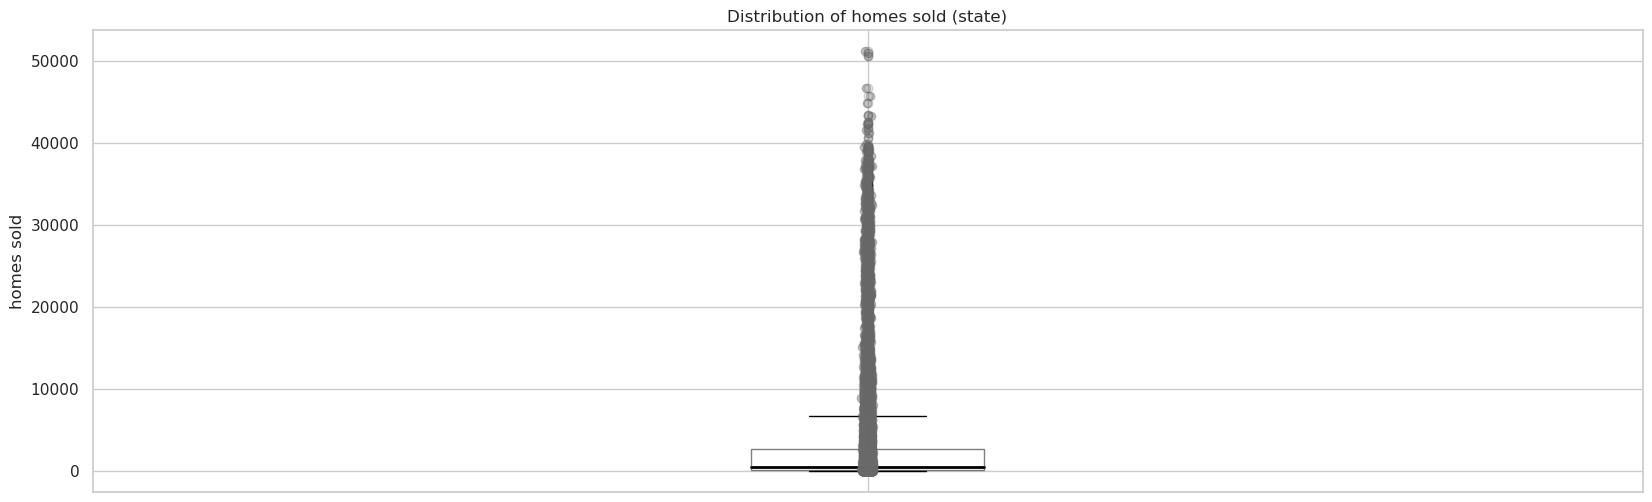

In [82]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.homes_sold, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of homes sold (state)")
axes.set_ylabel("homes sold")
x = np.random.normal(1, 0.001, size=len(state_analysis.homes_sold))
axes.plot(x, state_analysis.homes_sold, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

It's difficult to tell when looking at all the data, but it does not seem like there is any gaps. The distribution does follow expectations since its positively skewed. Let's see how many rows are over 20,000 homes sold:

In [83]:
curs.execute('SELECT * FROM State_analysis \
              WHERE homes_sold > 20000 \
              ORDER BY homes_sold ASC;');

pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,14026,2015-04-01,2015-04-30,30,state,36,Texas,Texas,TX,Single Family Residential,211800.00,231900.00,100.00,107.00,20034.00,19790.00,29243.00,57927,2.90,34.00,0.98,0.18,0.42
1,7169,2017-10-01,2017-10-31,30,state,19,Florida,Florida,FL,Single Family Residential,249800.00,246300.00,141.00,149.00,20083.00,15423.00,26107.00,79518,4.00,60.00,0.97,0.20,0.34
2,24741,2013-09-01,2013-09-30,30,state,36,Texas,Texas,TX,All Residential,181200.00,185300.00,88.00,91.00,20089.00,15935.00,21718.00,69737,3.50,43.00,0.98,0.18,0.27
3,15482,2013-01-01,2013-01-31,30,state,9,California,California,CA,All Residential,344100.00,386200.00,223.00,244.00,20112.00,19474.00,25506.00,37168,1.80,28.00,1.00,0.18,0.55
4,13356,2014-05-01,2014-05-31,30,state,19,Florida,Florida,FL,Single Family Residential,199600.00,189400.00,107.00,113.00,20113.00,15240.00,22730.00,83106,4.10,85.00,0.96,0.21,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,4980,2022-03-01,2022-03-31,30,state,19,Florida,Florida,FL,All Residential,388100.00,420300.00,244.00,261.00,45683.00,42593.00,48913.00,53050,1.20,24.00,1.00,0.16,0.56
573,16441,2021-05-01,2021-05-31,30,state,19,Florida,Florida,FL,All Residential,332000.00,351100.00,200.00,214.00,46663.00,41389.00,48391.00,69518,1.50,30.00,0.99,0.13,0.51
574,3306,2021-06-01,2021-06-30,30,state,19,Florida,Florida,FL,All Residential,341000.00,351500.00,205.00,215.00,50579.00,42043.00,49439.00,69501,1.40,28.00,0.99,0.15,0.50
575,28280,2021-04-01,2021-04-30,30,state,19,Florida,Florida,FL,All Residential,326200.00,345600.00,196.00,209.00,50887.00,42103.00,49885.00,70276,1.40,32.00,0.99,0.13,0.51


Only 577 rows contains over 20,000 homes sold, so this is something to consider if we create a cut off for visualization purposes (there are a total of nearly 30,000 rows in the state table). Let's try generating a histogram for up to 20,000 homes sold, since this is a majority of the data points.

Freeman Diaconis:  156


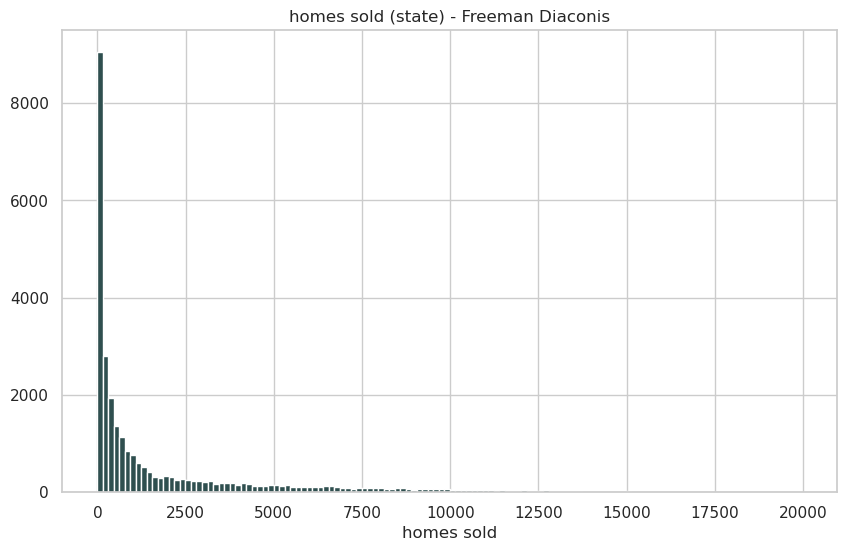

In [84]:
state_homes_sold = state_analysis.homes_sold[state_analysis.homes_sold < 20000]

h = freeman_diaconis(state_homes_sold)
print("Freeman Diaconis: ", h)
mn = int(state_homes_sold.min())
mx = int(state_homes_sold.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_homes_sold,bins=bins, color="darkslategray")
axes.set_title("homes sold (state) - Freeman Diaconis")
axes.set_xlabel("homes sold")

plt.show()
plt.close()

Most states/time periods had less than 10,000 homes sold, which makes sense when we remember the results from the National table. Like previous variables, the National table tends to have smaller cohorts at large values since it is a median overall. We expect the county data to have a similar positive skew, like the states data:

In [85]:
county_analysis.homes_sold.describe()

count   640957.00
mean       113.89
std        334.62
min          0.00
25%          3.00
50%         17.00
75%         73.00
max       9240.00
Name: homes_sold, dtype: float64

On a county scale, the number of homes sold in a 30-day duration ranged from 0 and 9,240 homes, with a mean of about 114 homes. The mean is greater than the median, which indicates a right skewed distribution. Let's try visualizing the data:

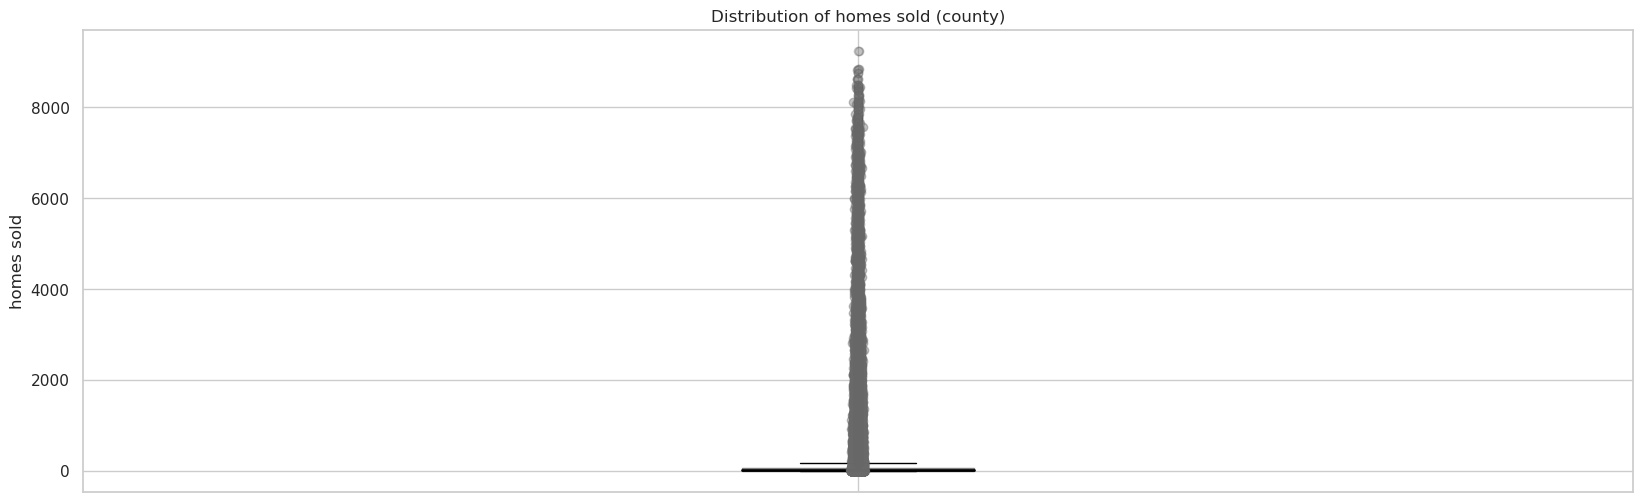

In [86]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.homes_sold, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of homes sold (county)")
axes.set_ylabel("homes sold")
x = np.random.normal(1, 0.001, size=len(county_analysis.homes_sold))
axes.plot(x, county_analysis.homes_sold, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Once again, it's difficult to tell when looking at all the data but it does not seem like there is any gaps. The distribution does follow expectations since its positively skewed but its hard to tell where most of the values sit. Based on the maximum and the mean, we can try estimating a value to cut off the data for visualization. Let's see how many rows are over 1,000 homes sold:

In [87]:
curs.execute('SELECT * FROM County_analysis \
              WHERE homes_sold > 1000 \
              ORDER BY homes_sold ASC;');

pd.DataFrame(curs.fetchall(), columns=county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,633760,2020-03-01,2020-03-31,30,county,1695,"St. Louis County, MO",Missouri,MO,Single Family Residential,196000.00,219000.00,139.40,145.20,1001.00,0.00,1307.00,2094,2.10,33.00,0.98,0.22,0.53
1,575478,2020-11-01,2020-11-30,30,county,1165,"Jefferson County, KY",Kentucky,KY,Single Family Residential,225250.00,199900.00,121.80,124.34,1001.00,869.00,871.00,1463,1.50,21.00,0.99,0.21,0.39
2,598762,2013-08-01,2013-08-31,30,county,547,"DeKalb County, GA",Georgia,GA,All Residential,169900.00,149900.00,104.03,90.48,1001.00,755.00,1172.00,3265,3.30,38.00,0.99,0.37,0.30
3,603045,2015-10-01,2015-10-31,30,county,1324,"Montgomery County, MD",Maryland,MD,All Residential,385000.00,527000.00,215.55,227.70,1001.00,1292.00,1655.00,3668,3.70,48.00,0.98,0.34,0.56
4,617121,2014-05-01,2014-05-31,30,county,1050,"Johnson County, KS",Kansas,KS,Single Family Residential,233250.00,230000.00,105.86,107.25,1001.00,0.00,1270.00,0,3.70,62.00,0.00,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13543,102471,2021-03-01,2021-03-31,30,county,220,"Maricopa County, AZ",Arizona,AZ,All Residential,380000.00,399000.00,216.18,223.19,8631.00,8283.00,8907.00,8111,0.90,25.00,1.01,0.13,0.47
13544,122807,2021-06-01,2021-06-30,30,county,727,"Cook County, IL",Illinois,IL,All Residential,320000.00,309000.00,209.12,203.41,8753.00,7532.00,10367.00,15546,1.80,10.00,1.00,0.24,0.57
13545,196475,2018-05-01,2018-05-31,30,county,220,"Maricopa County, AZ",Arizona,AZ,All Residential,277000.00,283000.00,155.00,157.28,8818.00,7194.00,8812.00,17830,2.00,40.00,0.98,0.27,0.29
13546,28915,2020-07-01,2020-07-31,30,county,220,"Maricopa County, AZ",Arizona,AZ,All Residential,330000.00,340465.00,182.57,190.97,8845.00,7304.00,8384.00,11552,1.30,40.00,0.99,0.18,0.37


Only a little over 13,000 rows contains over 1,000 homes sold, so this is something to consider if we create a cut off for visualization purposes (there are a total of nearly 650,000 rows in the county table). We can try generating a histogram for up to 1,000 homes sold, since this is a majority of the data points.

Freeman Diaconis:  2


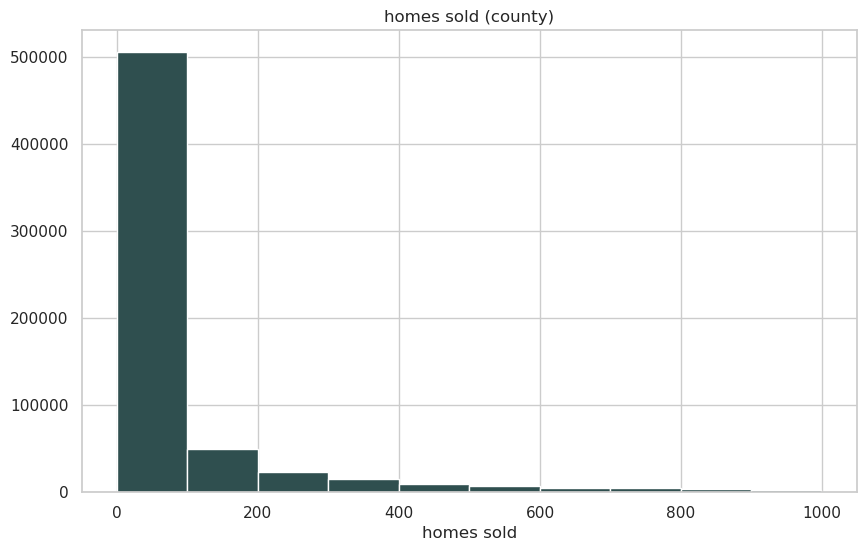

In [88]:
county_homes_sold = county_analysis.homes_sold[county_analysis.homes_sold < 1000]

h = freeman_diaconis(county_homes_sold)
print("Freeman Diaconis: ", h)
mn = int(county_homes_sold.min())
mx = int(county_homes_sold.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_homes_sold, color="darkslategray")
axes.set_title("homes sold (county)")
axes.set_xlabel("homes sold")

plt.show()
plt.close()

Overall, most counties had about 100 homes sold per month, over a decade. The distribution aligns with what we expect based on the trends seen in the national and state data; mainly, the heavy right skew explains the gap seen in the national data since outliers are less obvious with more data points that separate parts of the nation. 

<a id="k"></a>
#### pending_sales

[Back to Contents](#NC)

Using common domain knowledge, we would expect the pending sales to increase during stronger market conditions and decrease during recessions or supply shortages. The pending sales should align with the homes sold variable, at least to some extent. As usual, we will look at the basic statistics, starting with the national data:

In [89]:
national_analysis.pending_sales.describe()

count     1364.00
mean    226518.55
std     190672.27
min       4841.00
25%      41808.40
50%     244673.00
75%     394378.00
max     682886.00
Name: pending_sales, dtype: float64

On a national scale, the number of pending sales in each month duration ranged from 4,841 and 682,886 sales, with a mean of 226,518.55 sales. This aligns with what we saw in the homes sold variable; in addition, the mean is less than the median but may not actually indicate a left skewed distribution if we see the same gap. Let's try visualizing the data:

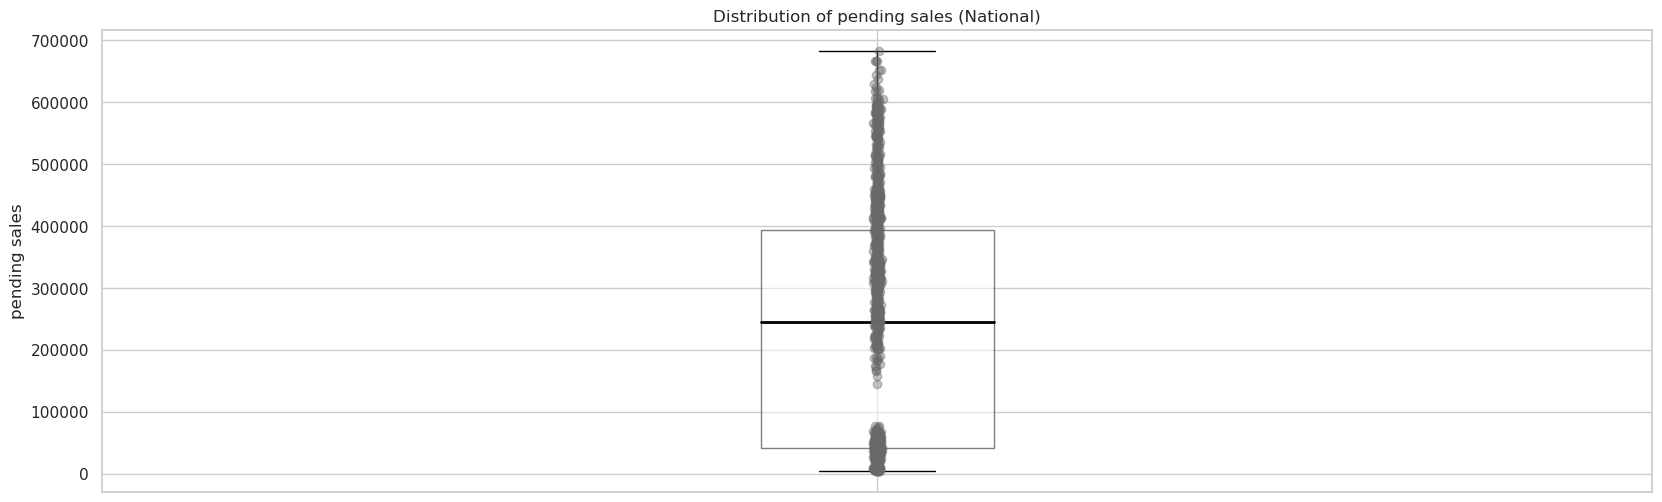

In [90]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.pending_sales, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of pending sales (National)")
axes.set_ylabel("pending sales")
x = np.random.normal(1, 0.001, size=len(national_analysis.pending_sales))
axes.plot(x, national_analysis.pending_sales, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Similar to the homes sold variable, we see a gap since most homes were under 100,000 pending sales with a separate cohort of time periods with greater pending sales. We found previously that the heavy right skew is more obvious in the state and county data, since the outliers are less obvious with more data points that separate parts of the nation and the gap is only present in the national data. Let's plot the histogram to confirm that the pending sales is behaving the same as the home sales, in regards to the gap:

Freeman Diaconis:  63599


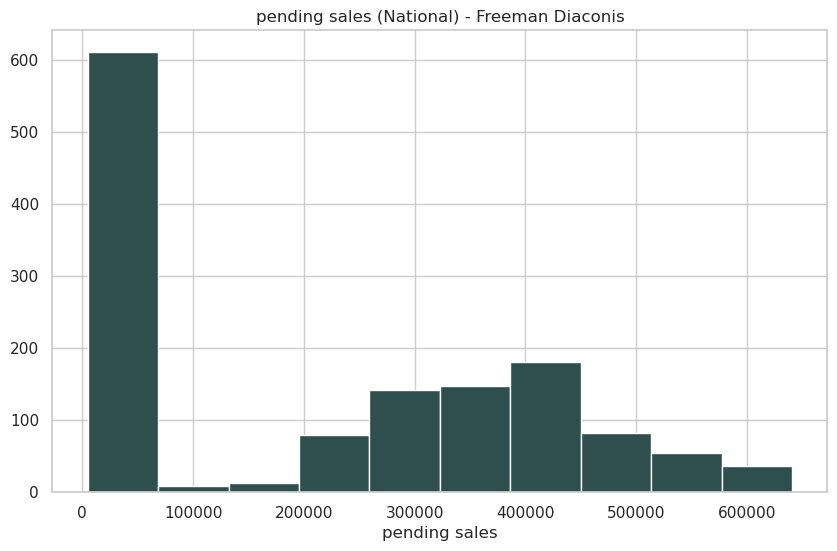

In [91]:
h = freeman_diaconis(national_analysis.pending_sales)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.pending_sales.min())
mx = int(national_analysis.pending_sales.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.pending_sales,bins=bins, color="darkslategray")
axes.set_title("pending sales (National) - Freeman Diaconis")
axes.set_xlabel("pending sales")

plt.show()
plt.close()

As expected, when we look at the national data, we see two "groups": the majority of time periods have under 100,000 pending sales but a second group has a distribution of pending sales from 100,000 to a little under 700,000 pending sales. These are likely outlier time periods that include very active states or counties. Let's continue to the state data:

In [92]:
state_analysis.pending_sales.describe()

count   28739.00
mean     1923.49
std      4063.84
min         0.00
25%        54.00
50%       376.00
75%      1763.50
max     45512.00
Name: pending_sales, dtype: float64

On a state scale, the number of pending sales in each month duration ranged from 0 and 45,412 sales, with a mean of 1,923.49 sales. The mean is also greater than median, so we expect a right skewed distribution. Let's try visualizing the data:

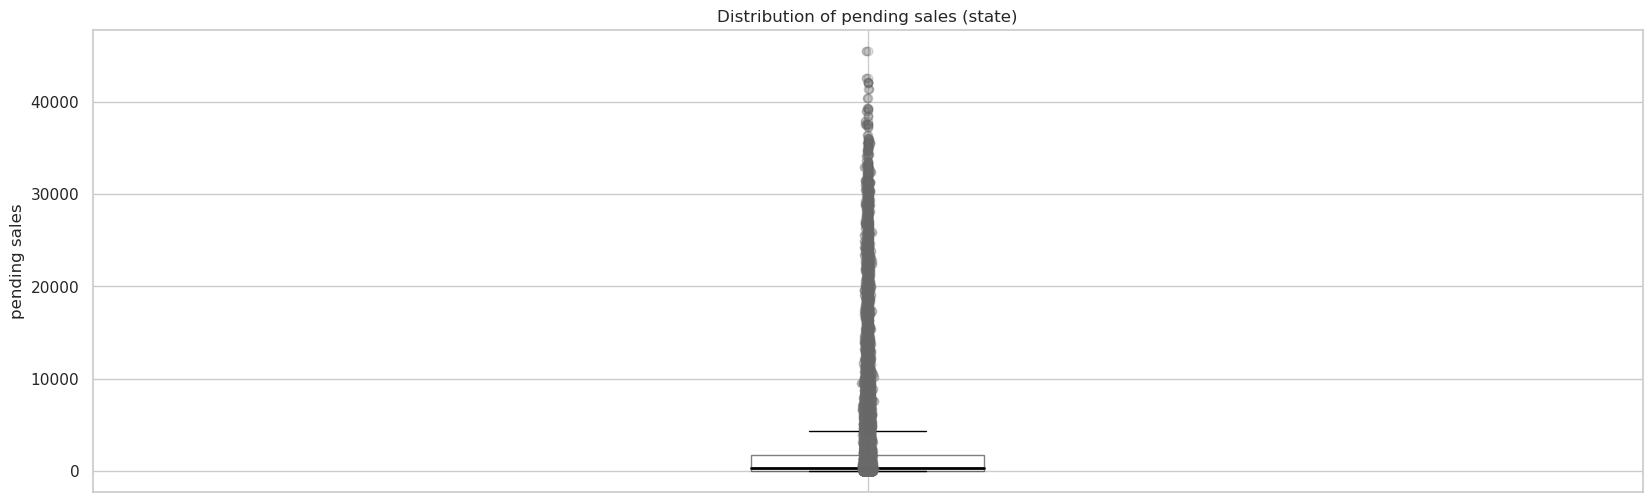

In [93]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.pending_sales, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of pending sales (state)")
axes.set_ylabel("pending sales")
x = np.random.normal(1, 0.001, size=len(state_analysis.pending_sales))
axes.plot(x, state_analysis.pending_sales, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

We have a heavily right skewed distribution which will make visualizing the data difficult. We can determine a possible cut off by finding the number of homes with under 20,000 pending sales, as we did with the homes sold variable. 

In [94]:
curs.execute('SELECT COUNT(*) FROM State_analysis \
              WHERE pending_sales > 20000 \
              ORDER BY pending_sales ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,403


Only 403 out of nearly 30,000 rows in the state data have over 20,000 pending sales. Therefore, we can visualize the state data with under 20,000 pending sales, which is the majority of the data, in order to make the histogram *readable*:

Freeman Diaconis:  103


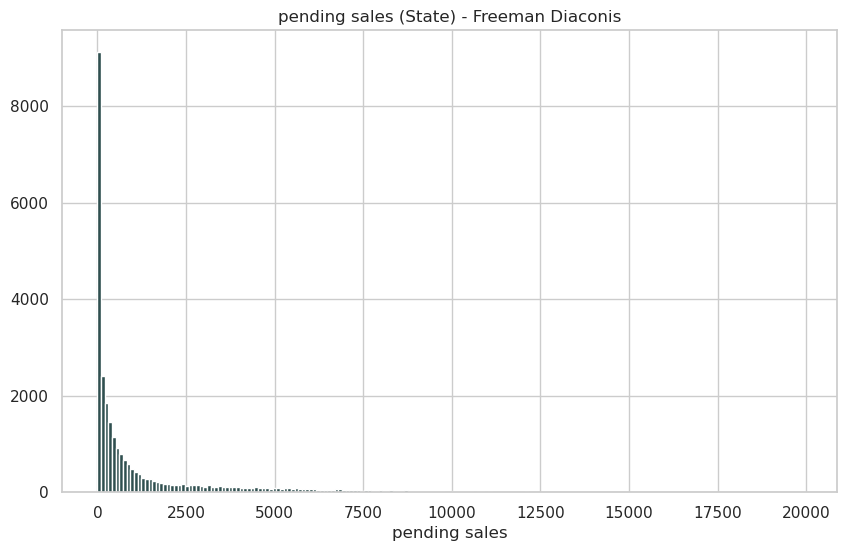

In [95]:
state_pending_sales = state_analysis.pending_sales[state_analysis.pending_sales < 20000]

h = freeman_diaconis(state_pending_sales)
print("Freeman Diaconis: ", h)
mn = int(state_pending_sales.min())
mx = int(state_pending_sales.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_pending_sales,bins=bins, color="darkslategray")
axes.set_title("pending sales (State) - Freeman Diaconis")
axes.set_xlabel("pending sales")

plt.show()
plt.close()

As expected, we have a heavily right skewed distribution which mimics the patterns we saw with the home sales variable. Since everything is as expected so far, we can move on to the county data:

In [96]:
county_analysis.pending_sales.describe()

count   640957.00
mean        87.35
std        289.41
min          0.00
25%          2.00
50%          9.00
75%         46.00
max       8283.00
Name: pending_sales, dtype: float64

On a county scale, the number of pending sales in each month duration ranged from 0 and 8,283 sales, with a mean of 87.35 sales. The mean is also greater than median, so we expect a right skewed distribution. Let's try visualizing the data:

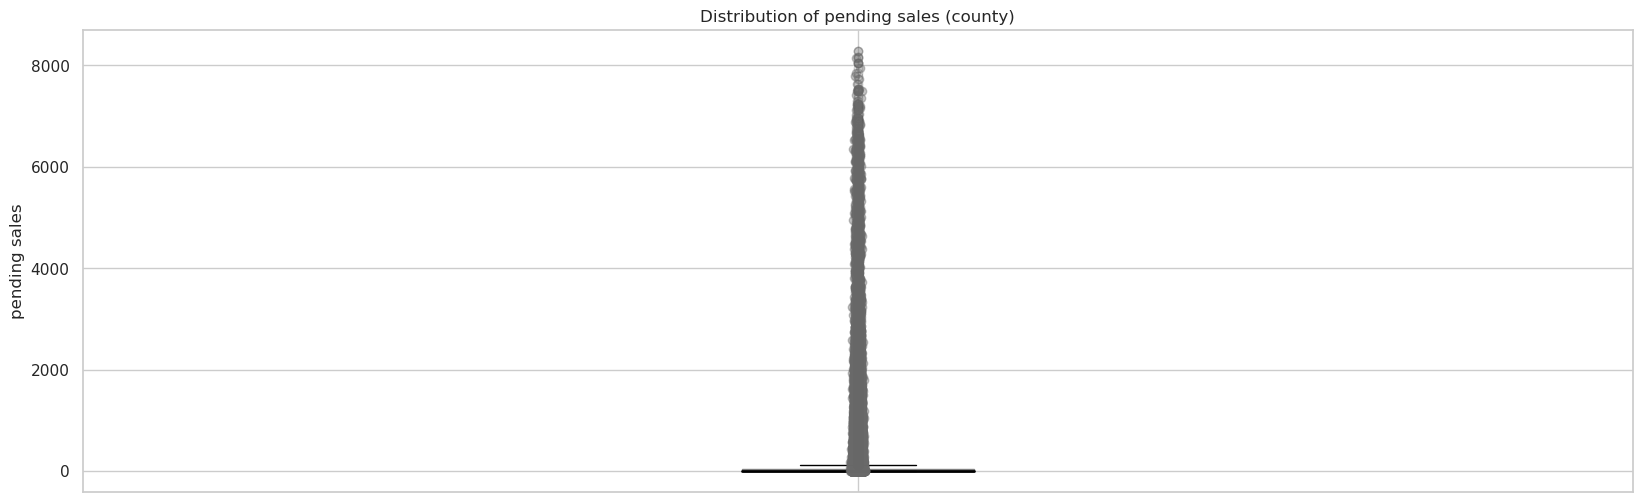

In [97]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.pending_sales, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of pending sales (county)")
axes.set_ylabel("pending sales")
x = np.random.normal(1, 0.001, size=len(county_analysis.pending_sales))
axes.plot(x, county_analysis.pending_sales, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

We have a heavily right skewed distribution which will make visualizing the data difficult. We can determine a possible cut off by finding the number of homes with under 1,000 pending sales, as we did with the homes sold variable when we looked at the county data. 

In [98]:
curs.execute('SELECT COUNT(*) FROM County_analysis \
              WHERE pending_sales > 1000 \
              ORDER BY pending_sales ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,9829


Only 9,829 out of nearly 650,000 rows in the county data have over 1,000 pending sales. Therefore, we can visualize the county data with under 1,000 pending sales, which is the majority of the data, in order to make the histogram *readable*:

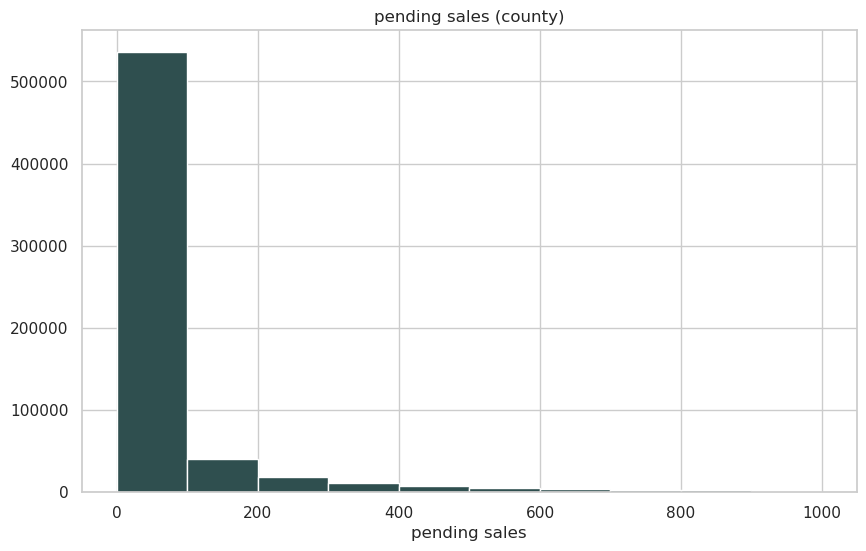

In [99]:
county_pending_sales = county_analysis.pending_sales[county_analysis.pending_sales < 1000]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_pending_sales,  color="darkslategray")
axes.set_title("pending sales (county)")
axes.set_xlabel("pending sales")

plt.show()
plt.close()

Once again, we have a similar pattern to the home sales variable where we have a heavily right skewed distribution of pending sales. Overall, most time periods had a total number of pending sales (or homes sold) that sat "closer to zero". We will not remove the values we dropped for visualizations from the MySql database since these are still "possible" values, but we will see how the data performs as is when we build the forecasting model since they are not the majority. 

<a id="l"></a>
#### new_listings

[Back to Contents](#NC)

Similar to homes sold and pending sales, we expect the new listings variable to behave similarly since these variables likely interact with one another. Let's begin with the national data:

In [100]:
national_analysis.new_listings.describe()

count     1364.00
mean    324731.17
std     263006.70
min       7520.00
25%      59527.20
50%     395683.50
75%     574937.50
max     841597.00
Name: new_listings, dtype: float64

On a national scale, the number of new listings varied from 7,520 to 841,597 listings, with a mean of 324,731.17 listings. In this case, the median is greater than the mean which hints at a left skewed distribution. However, the standard deviation is high, meaning we could be dealing with outliers or missing values (the gap seen previously) causing this skew. Let's visualize the box plot:

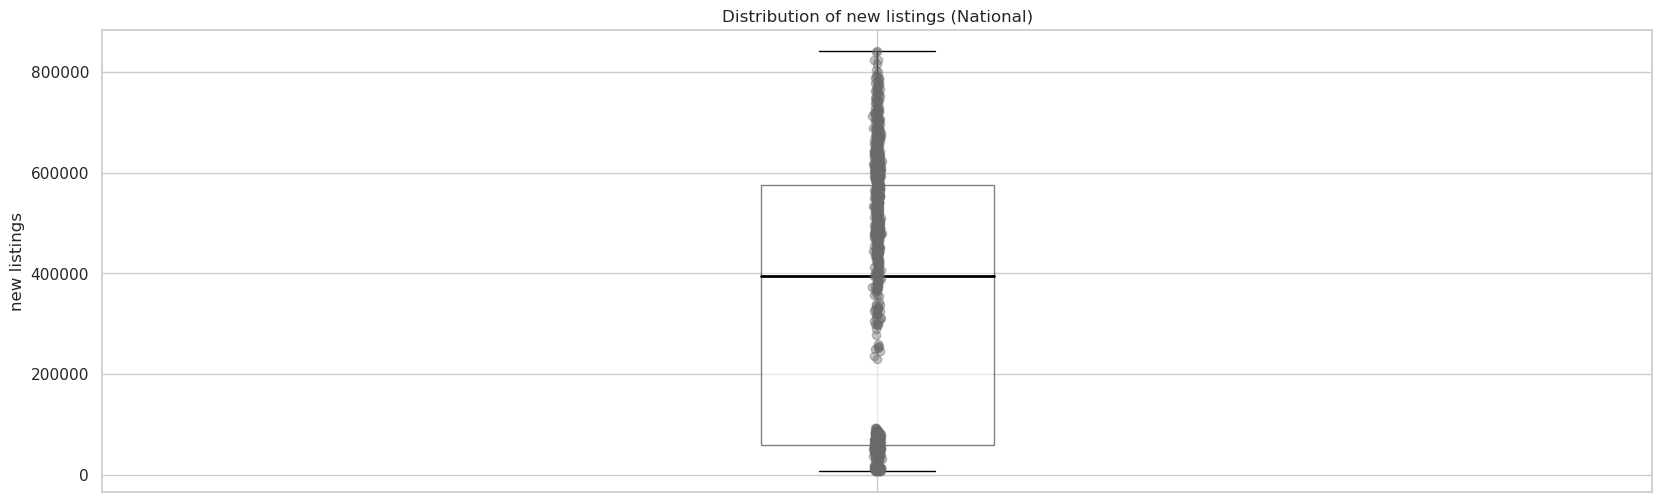

In [101]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.new_listings, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of new listings (National)")
axes.set_ylabel("new listings")
x = np.random.normal(1, 0.001, size=len(national_analysis.new_listings))
axes.plot(x, national_analysis.new_listings, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

As seen in the previous variables (i.e. homes sold), there is a gap separating two cohorts of time periods. This is only present in the National data, as explained with other variables, so we can look at the histogram to better visualize the two groups and move on to the other tables of data.

Freeman Diaconis:  92959


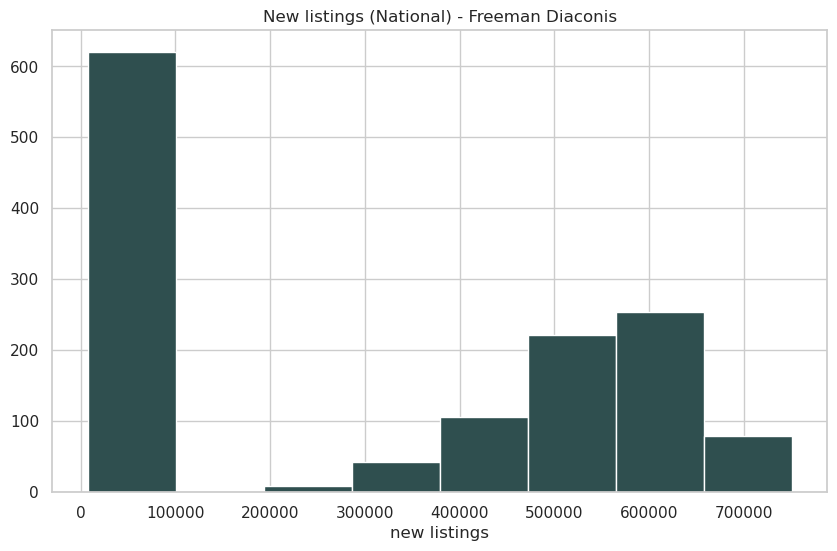

In [102]:
h = freeman_diaconis(national_analysis.new_listings)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.new_listings.min())
mx = int(national_analysis.new_listings.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.new_listings,bins=bins, color="darkslategray")
axes.set_title("New listings (National) - Freeman Diaconis")
axes.set_xlabel("new listings")

plt.show()
plt.close()

When we look at the national data, the majority of time periods have under 100,000 new listings but a second group has a distribution of new listings from 200,000 to a little over 700,000 pending sales. These are likely outlier time periods that include very active states or counties. Let's continue to the state data:

In [103]:
state_analysis.new_listings.describe()

count   28739.00
mean     2920.16
std      5714.26
min         0.00
25%        96.00
50%       653.00
75%      2942.00
max     50151.00
Name: new_listings, dtype: float64

On a state scale, the number of new listings in each month duration ranged from 0 and 50,151 listings, with a mean of 2,920.16 listings. The mean is nearly equal to the median, which would indicate a more "normal" distribution, but the mean and median sit very close to the minimum. Therefore, we are likely still dealing with a right skewed distribution. Let's try visualizing the data:

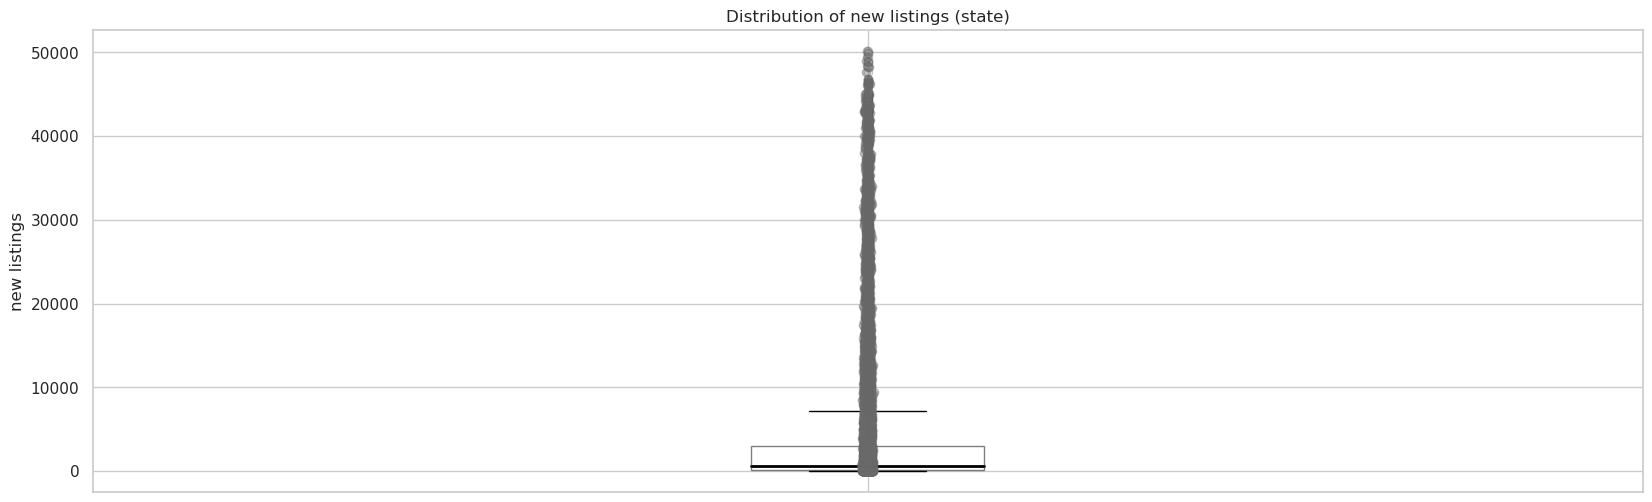

In [104]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.new_listings, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of new listings (state)")
axes.set_ylabel("new listings")
x = np.random.normal(1, 0.001, size=len(state_analysis.pending_sales))
axes.plot(x, state_analysis.new_listings, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

We have a heavily right skewed distribution which could make visualizing the data difficult. We can determine a possible cut off by finding the number of homes with under 20,000 new listings, as we did with the homes sold and pending sales variables.

In [105]:
curs.execute('SELECT COUNT(*) FROM State_analysis \
              WHERE new_listings > 20000 \
              ORDER BY new_listings ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,690


Only 690 out of nearly 30,000 rows in the state data have over 20,000 new listings. Therefore, we can visualize the state data with under 20,000 new listings, which is the majority of the data, in order to make the histogram *readable*:

Freeman Diaconis:  165


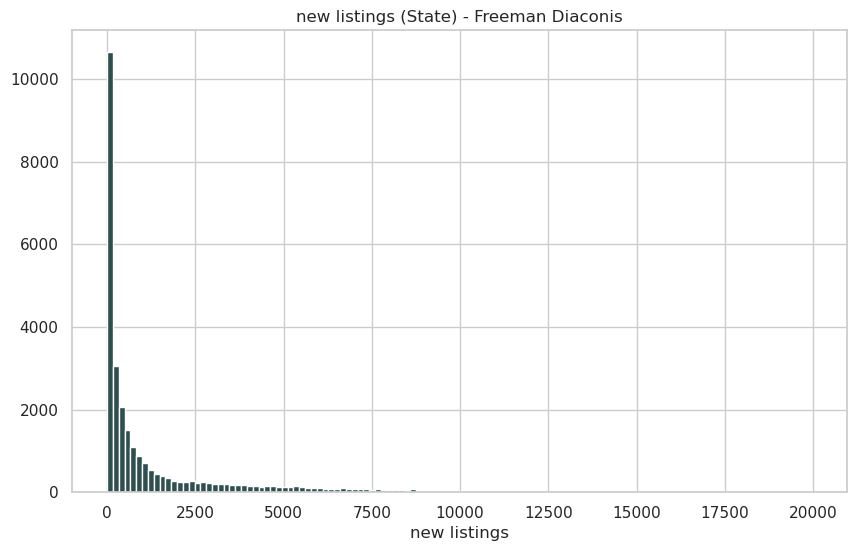

In [106]:
state_new_listings = state_analysis.new_listings[state_analysis.new_listings < 20000]

h = freeman_diaconis(state_new_listings)
print("Freeman Diaconis: ", h)
mn = int(state_pending_sales.min())
mx = int(state_pending_sales.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_pending_sales,bins=bins, color="darkslategray")
axes.set_title("new listings (State) - Freeman Diaconis")
axes.set_xlabel("new listings")

plt.show()
plt.close()

As expected, we have a heavily right skewed distribution which mimics the patterns we saw with the home sales and pending sales variables. Let's move on to the county data:

In [107]:
county_analysis.new_listings.describe()

count   640957.00
mean       133.31
std        399.38
min          0.00
25%          4.00
50%         20.00
75%         85.00
max      10367.00
Name: new_listings, dtype: float64

On a county scale, the number of new listings in each month duration ranged from 0 and 10,367 listings, with a mean of 133.31 listings. The mean is greater than median and these values sit closer to the minimum, so we expect a right skewed distribution. Let's try visualizing the data:

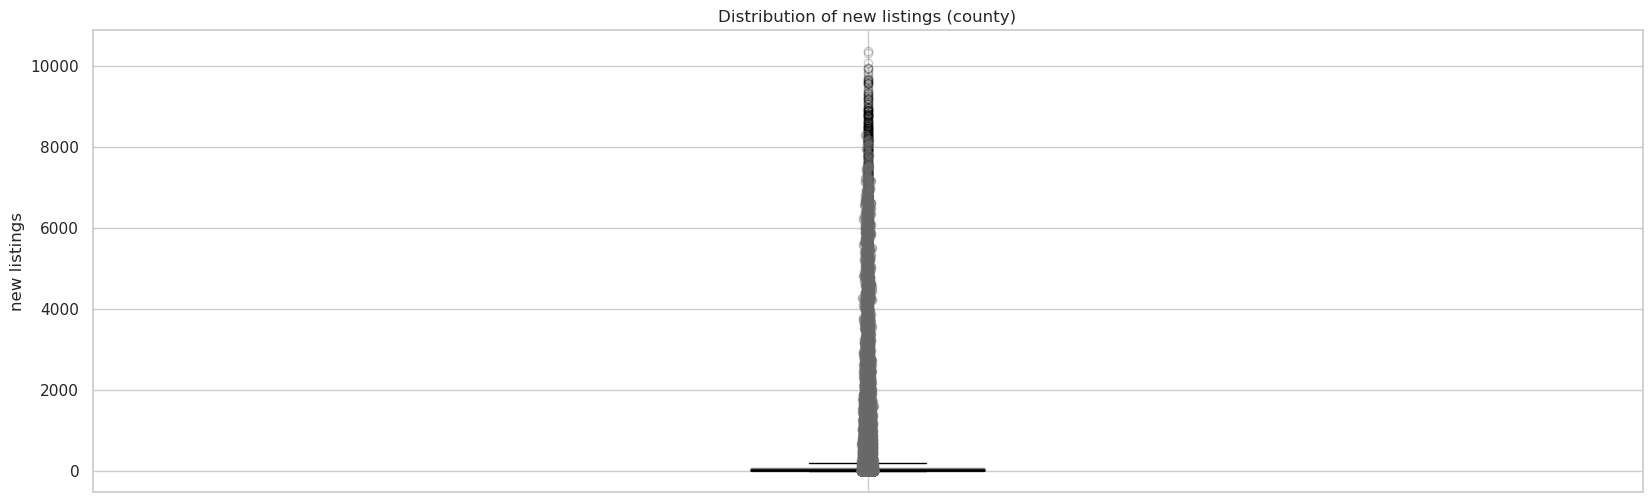

In [108]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.new_listings, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of new listings (county)")
axes.set_ylabel("new listings")
x = np.random.normal(1, 0.001, size=len(county_analysis.new_listings))
axes.plot(x, county_analysis.pending_sales, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Since the distribution is very positively skewed, we need to determine a cut off again. We can determine a possible cut off by finding the number of homes with under 1,000 new listings, as we did with the previous two variables when we looked at the county data. 

In [109]:
curs.execute('SELECT COUNT(*) FROM County_analysis \
              WHERE new_listings > 1000 \
              ORDER BY new_listings ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,17747


17,747 out of nearly 650,000 rows in the county data have over 1,000 new listings, which is about 2% of the data. This is a bit more instances than previous variables but still is a small minority of data points. Therefore, we can visualize the county data with under 1,000 new listings in order to make the histogram *readable*:

Freeman Diaconis:  2


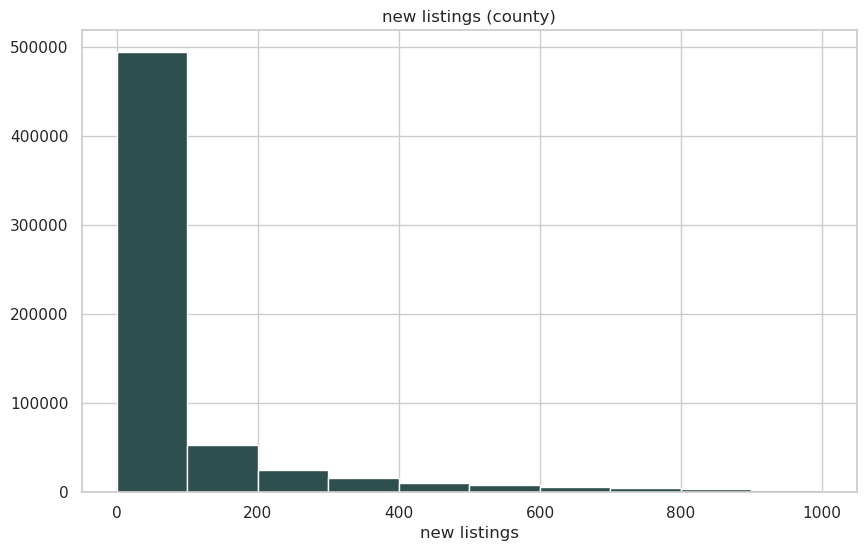

In [110]:
county_new_listings = county_analysis.new_listings[county_analysis.new_listings < 1000]

h = freeman_diaconis(county_new_listings)
print("Freeman Diaconis: ", h)
mn = int(county_new_listings.min())
mx = int(county_new_listings.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_new_listings, color="darkslategray")
axes.set_title("new listings (county)")
axes.set_xlabel("new listings")

plt.show()
plt.close()

Once again, we have a similar pattern to the home sales and pending sales variables where we have a heavily right skewed distribution of new listings. Overall, most time periods had a total number of new listings that sat "closer to zero". Like the previous variables, we will not remove the values we dropped for visualizations from the MySql database since these are still "possible" values, but we will see how the data performs as is when we build the forecasting model since they are not the majority. 

<a id="m"></a>
#### inventory

[Back to Contents](#NC)

Since inventory is based on active homes on the market, we expect this variable to align with trends seen in the last few variables (homes sold, pending sales, new listings). We can begin with basic statistics for the national data:

In [111]:
national_analysis.inventory.describe()

count      1364.00
mean     855536.00
std      728075.89
min       24323.00
25%      138646.00
50%      753189.00
75%     1559503.75
max     2249755.00
Name: inventory, dtype: float64

On a national scale, the inventory varied from 24,323 to 2,249,755 homes, with a mean of 855,536 homes. The median is less than the mean which hints at a right skewed distribution. The standard deviation is high,so we likely have a gap in the data again resulting from the cohorts we saw previously. Let's visualize the box plot:

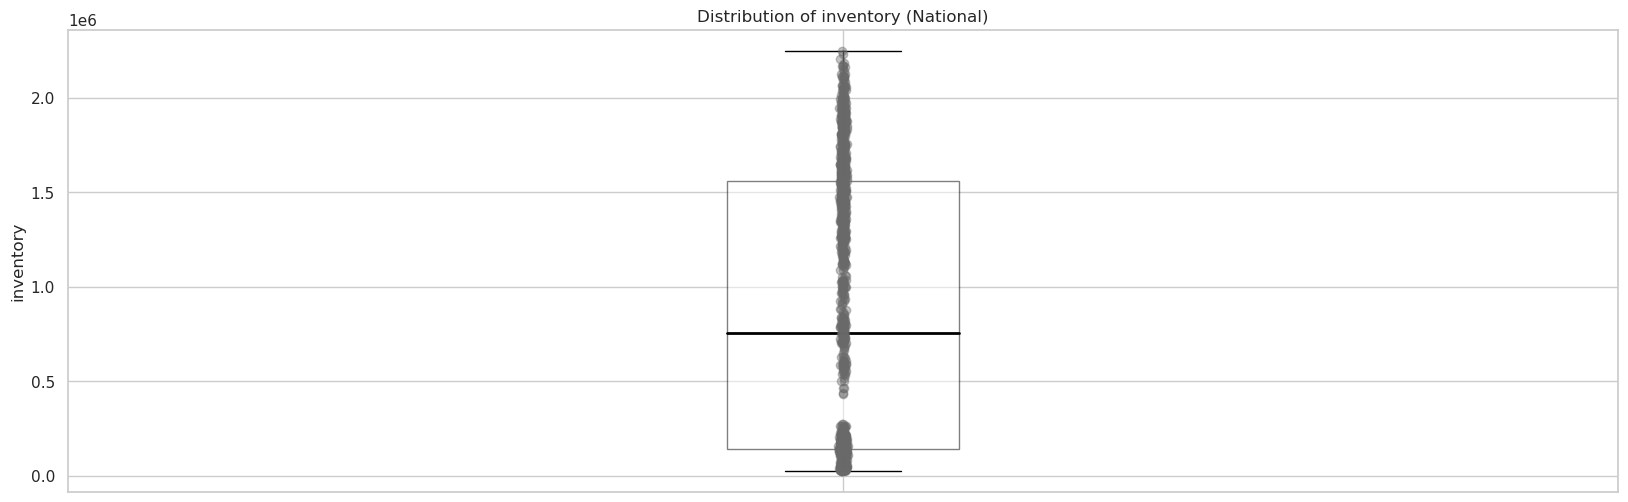

In [112]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.inventory, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of inventory (National)")
axes.set_ylabel("inventory")
x = np.random.normal(1, 0.001, size=len(national_analysis.inventory))
axes.plot(x, national_analysis.inventory, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Once again, we see the gap separating two cohorts of data points, where the second cohort likely consists of very active states or counties with larger inventories. We can visualize a histogram, as we did with the previous variables:

Freeman Diaconis:  256304


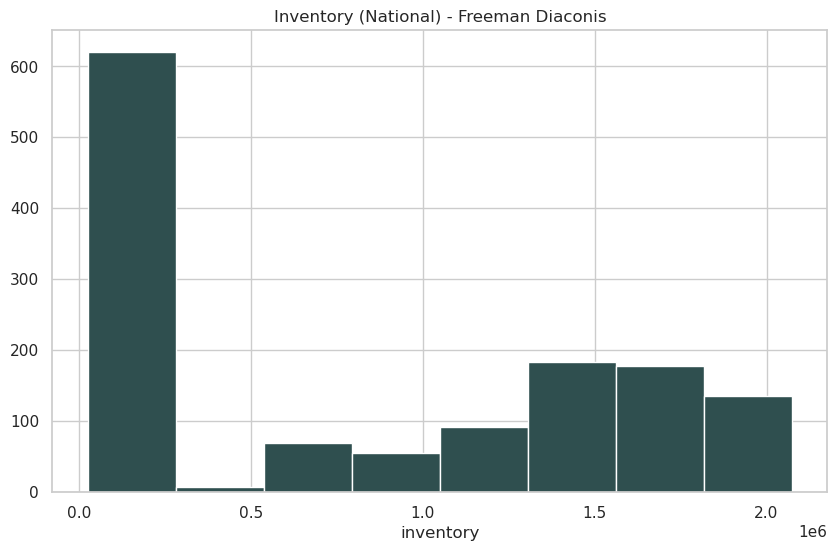

In [113]:
h = freeman_diaconis(national_analysis.inventory)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.inventory.min())
mx = int(national_analysis.inventory.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.inventory,bins=bins, color="darkslategray")
axes.set_title("Inventory (National) - Freeman Diaconis")
axes.set_xlabel("inventory")

plt.show()
plt.close()

When we look at the national data, the majority of time periods have under 500,000 homes making up the inventory but a second group has a distribution of inventory counts from slightly under 500,000 to a little over 2 million homes. Let's continue with the state data:

In [114]:
state_analysis.inventory.describe()

count    28739.00
mean      8218.51
std      15645.65
min          0.00
25%        288.00
50%       1791.00
75%       8677.50
max     150738.00
Name: inventory, dtype: float64

On a state scale, the inventory in each month duration ranged from 0 and 150,738 homes, with a mean of 8,218.51 homes. The mean is only slightly less than the median, which would indicate a more "normal" distribution, but the mean and median sit very close to the minimum. Therefore, we are likely still dealing with a right skewed distribution. Let's try visualizing the data:

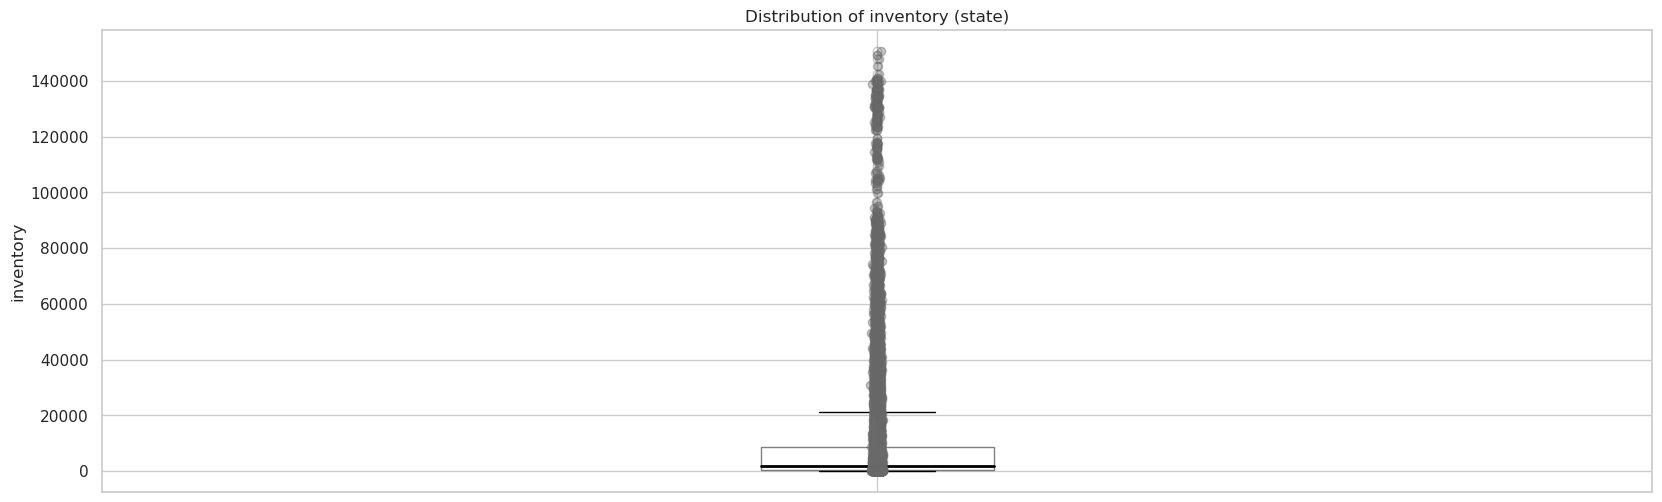

In [115]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.inventory, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of inventory (state)")
axes.set_ylabel("inventory")
x = np.random.normal(1, 0.001, size=len(state_analysis.inventory))
axes.plot(x, state_analysis.inventory, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The right skewed distribution is similar to previous variables, which could make visualizing the data difficult again. We can determine a cut off by looking at the instances where the inventory is over or under 20,000 homes:

In [116]:
curs.execute('SELECT COUNT(*) FROM State_analysis \
              WHERE inventory > 20000 \
              ORDER BY inventory ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,3659


3,659 out of nearly 30,000 rows in the state data have an inventory with over 20,000 homes. This may be a bit too large so let's try a different cut off. 

In [117]:
curs.execute('SELECT COUNT(*) FROM State_analysis \
              WHERE inventory > 50000 \
              ORDER BY inventory ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,851


851 out of nearly 30,000 rows in the state data have an inventory with over 50,000 homes. Therefore, we can visualize the state data points with inventories under 50,000 homes, which is the majority of the data, in order to make the histogram *readable*:

Freeman Diaconis:  469


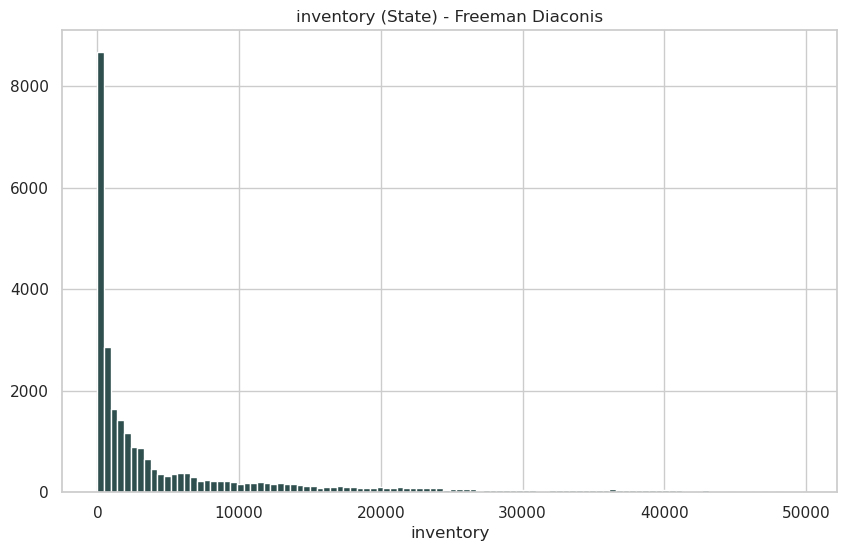

In [118]:
state_inventory = state_analysis.inventory[state_analysis.inventory < 50000]

h = freeman_diaconis(state_inventory)
print("Freeman Diaconis: ", h)
mn = int(state_inventory.min())
mx = int(state_inventory.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_inventory,bins=bins, color="darkslategray")
axes.set_title("inventory (State) - Freeman Diaconis")
axes.set_xlabel("inventory")

plt.show()
plt.close()

As expected, we have a heavily right skewed distribution which mimics the patterns we saw with the previous few variables. Let's move on to the county data:

In [119]:
county_analysis.inventory.describe()

count   640957.00
mean       378.14
std       1053.09
min          0.00
25%         15.00
50%         70.00
75%        284.00
max      28865.00
Name: inventory, dtype: float64

On a county scale, the inventory in each month duration ranged from 0 and 28,865 homes, with a mean of 378.14 homes. The mean is greater than median and these values sit closer to the minimum, so we expect a right skewed distribution. Let's try visualizing the data:

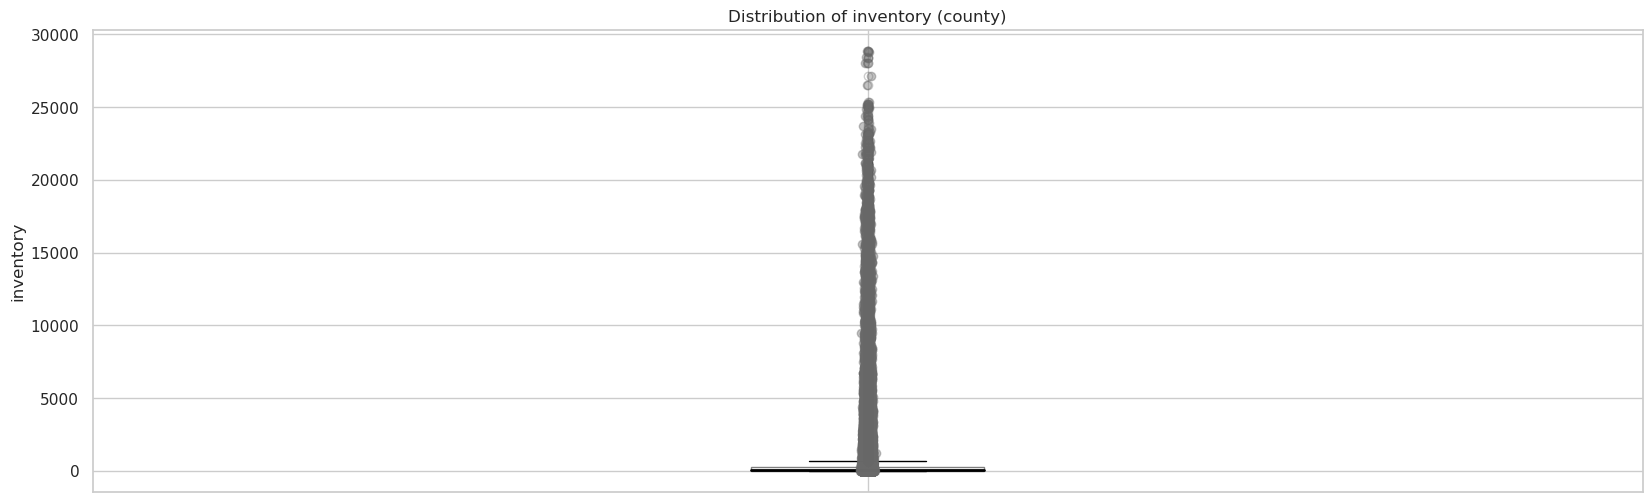

In [120]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.inventory, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of inventory (county)")
axes.set_ylabel("inventory")
x = np.random.normal(1, 0.001, size=len(county_analysis.inventory))
axes.plot(x, county_analysis.inventory, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Since the distribution is very positively skewed, we need to determine a cut off for visualization purposes. Since we needed a higher cut off for the national data when working with the inventory variable, we can assume it's the same for the state data. Let's modify the cut up from 1,000 to 5,000:

In [121]:
curs.execute('SELECT COUNT(*) FROM County_analysis \
              WHERE inventory > 5000 \
              ORDER BY inventory ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,5847


5,847 out of nearly 650,000 rows in the county data have an inventory with over 10,000 homes. Therefore, we can visualize the county data with under 1,000 new listings in order to make the histogram *readable*:

Freeman Diaconis:  6


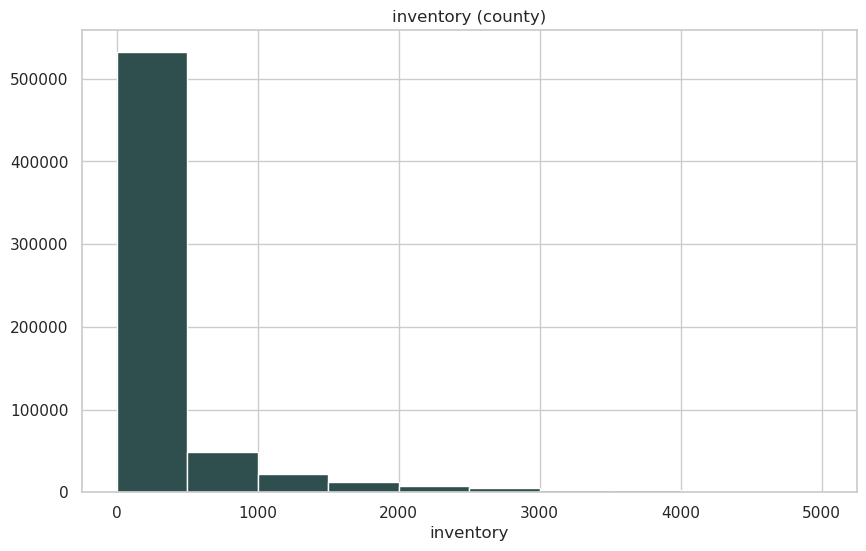

In [122]:
county_inventory = county_analysis.inventory[county_analysis.inventory < 5000]

h = freeman_diaconis(county_inventory)
print("Freeman Diaconis: ", h)
mn = int(county_inventory.min())
mx = int(county_inventory.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_inventory, color="darkslategray")
axes.set_title("inventory (county)")
axes.set_xlabel("inventory")

plt.show()
plt.close()

We have a similar pattern to the home sales, pending sales, and new listings variables where we have a heavily right skewed distribution of inventory counts. Overall, most time periods had a inventory that sat "closer to zero". Like the previous variables, we will not remove the values we dropped for visualizations from the MySql database since these are still "possible" values.

<a id="n"></a>
#### months_of_supply

[Back to Contents](#NC)

We expect the months of supply variable to follow the inventory variable very closely, to the point that multicollinearity may be a factor to consider, since the time that the supply will last is based on the supply itself, or inventory.  Nevertheless, we can begin with the basic statistics for the National data:

In [123]:
national_analysis.months_of_supply.describe()

count   1364.00
mean       3.37
std        1.25
min        0.96
25%        2.64
50%        3.28
75%        4.20
max        8.74
Name: months_of_supply, dtype: float64

For national data, the months of supply ranged from 0.96 to 8.74 months, with a mean of 3.37 months. The mean and median are very similar, and both values sit slightly closer to the minimum, so we expect a mostly normal distribution, with a possible slight right skew. As usual, we can begin with the box plot:

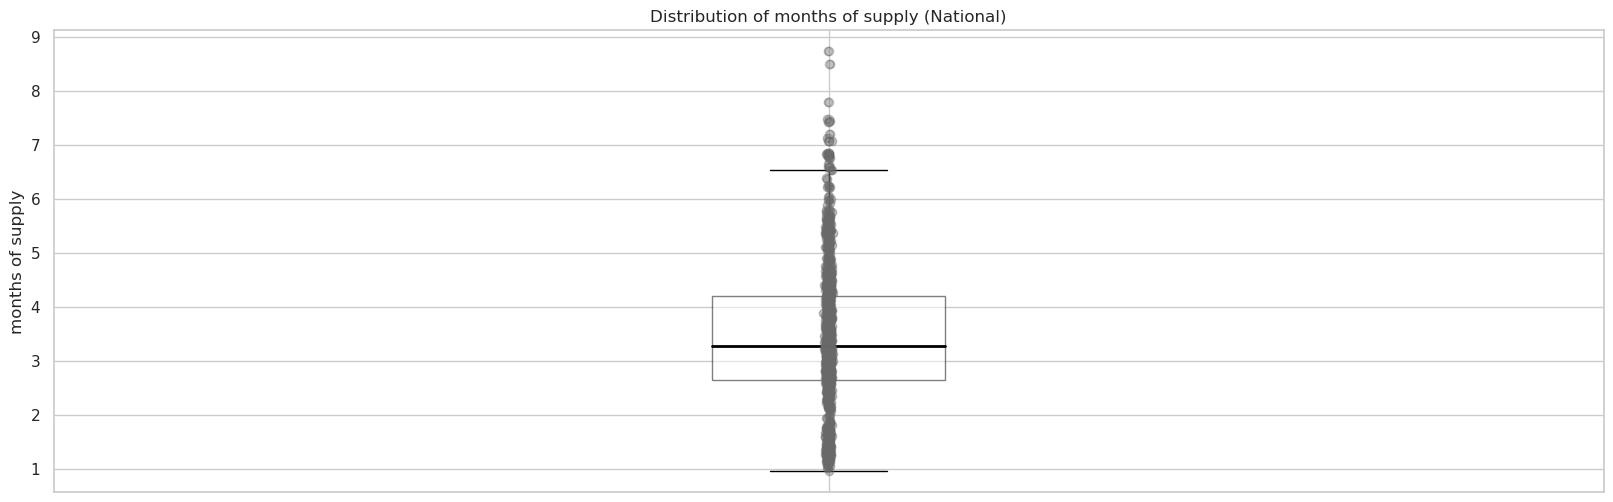

In [124]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.months_of_supply, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of months of supply (National)")
axes.set_ylabel("months of supply")
x = np.random.normal(1, 0.001, size=len(national_analysis.months_of_supply))
axes.plot(x, national_analysis.months_of_supply, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Based on the box plot, we have a relatively normal distribution with a slight right skew. Therefore, no major adjustments are needed to visualize the histogram. We can also note that there are likely two or more variables at play in determining the months of supply, meaning inventory alone is not the determining factor. 

Freeman Diaconis:  1


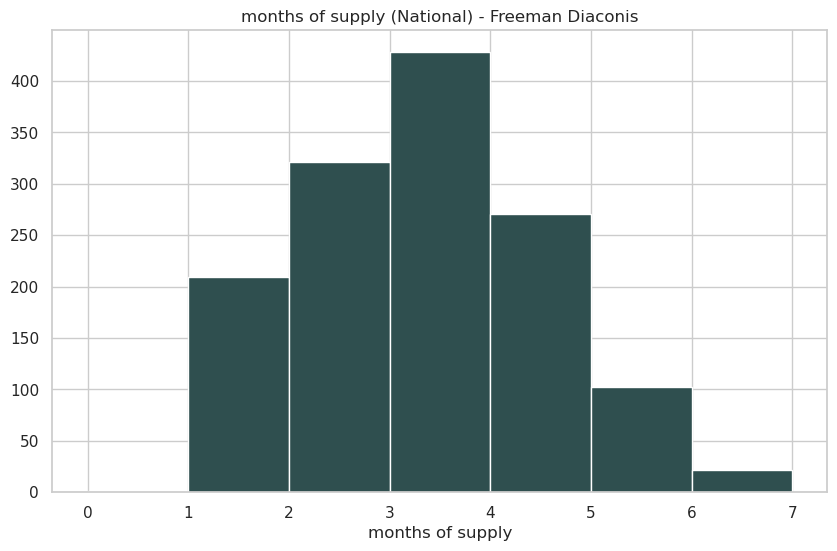

In [125]:
h = freeman_diaconis(national_analysis.months_of_supply)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.months_of_supply.min())
mx = int(national_analysis.months_of_supply.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.months_of_supply,bins=bins, color="darkslategray")
axes.set_title("months of supply (National) - Freeman Diaconis")
axes.set_xlabel("months of supply")

plt.show()
plt.close()

The right skew is evident in the histogram, although it's not very strong. Once again, inventory likely plays a role in addition to the variable containing the average time between list to sale. During periods where inventory is high and time to sell is slow (buyers market), the months of supply is likely higher, and vice versa for sellers markets. 

We can continue with the state data:

In [126]:
state_analysis.months_of_supply.describe()

count   28739.00
mean        4.03
std         2.83
min         0.00
25%         2.20
50%         3.50
75%         5.10
max        58.00
Name: months_of_supply, dtype: float64

On a state scale, the months of supply ranged from 0 to 58 months, with a mean of 4.03 months. The mean is slightly greater than the median, which would indicate a more "normal" distribution, but the mean and median sit very close to the minimum. Therefore, we are likely still dealing with a right skewed distribution, like we saw with the national data. Let's try visualizing the data:

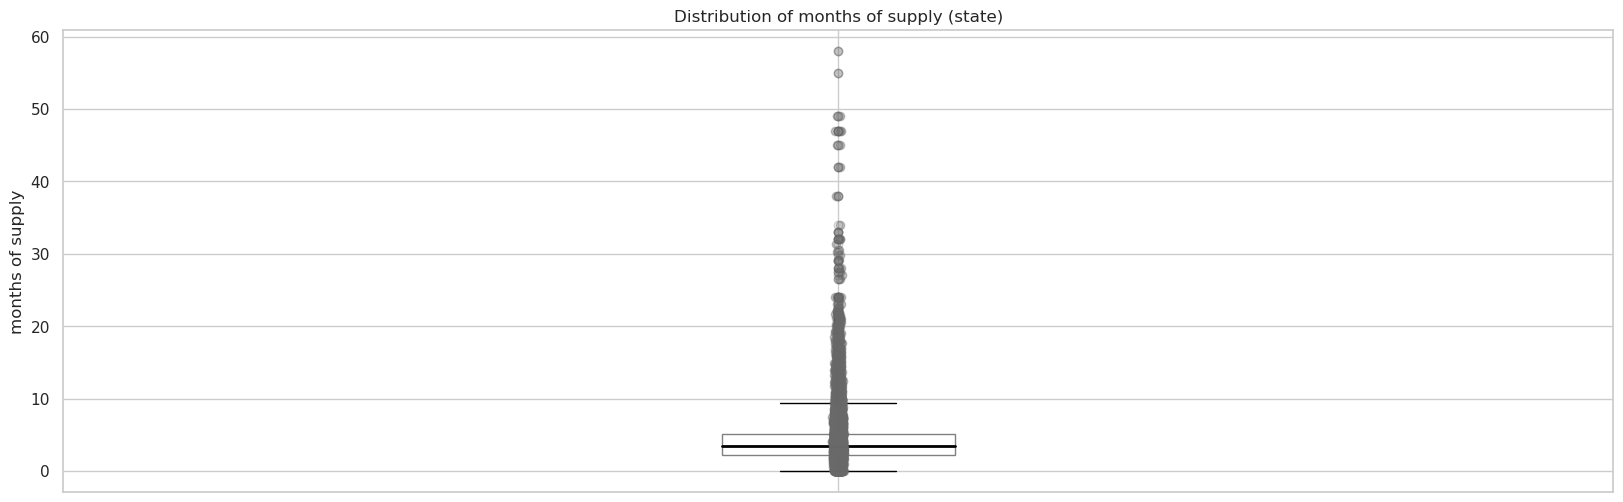

In [127]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.months_of_supply, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of months of supply (state)")
axes.set_ylabel("months of supply")
x = np.random.normal(1, 0.001, size=len(state_analysis.months_of_supply))
axes.plot(x, state_analysis.months_of_supply, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The distribution is right skewed, as expected, but it does not seem major enough to need any modifications for visualization purposes. Therefore, we can go ahead and generate the histogram:

Freeman Diaconis:  1


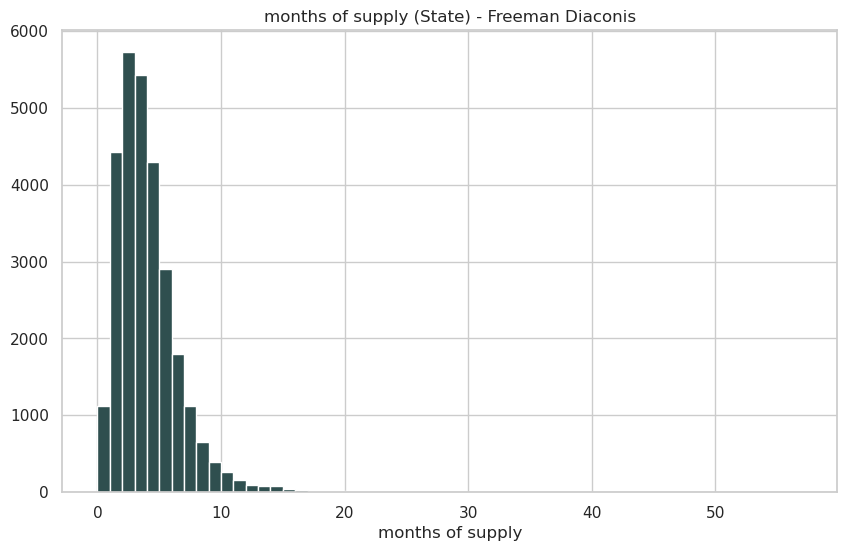

In [128]:
h = freeman_diaconis(state_analysis.months_of_supply)
print("Freeman Diaconis: ", h)
mn = int(state_analysis.months_of_supply.min())
mx = int(state_analysis.months_of_supply.max())
bins = [i for i in range( mn, mx, h)]

figure= plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_analysis.months_of_supply, bins=bins, color="darkslategray")
axes.set_title("months of supply (State) - Freeman Diaconis")
axes.set_xlabel("months of supply")

plt.show()
plt.close()

There is a slight right skew, as stated, but the distribution appears relatively "normal". Let's move on to the county data:

In [129]:
county_analysis.months_of_supply.describe()

count   640957.00
mean         5.57
std          6.28
min          0.00
25%          2.30
50%          4.10
75%          6.90
max        451.00
Name: months_of_supply, dtype: float64

On a county scale, the months of supply ranged from 0 and 451 months, with a mean of 5.57 months. The mean is greater than median and these values sit closer to the minimum, so we expect a right skewed distribution. Let's try visualizing the data:

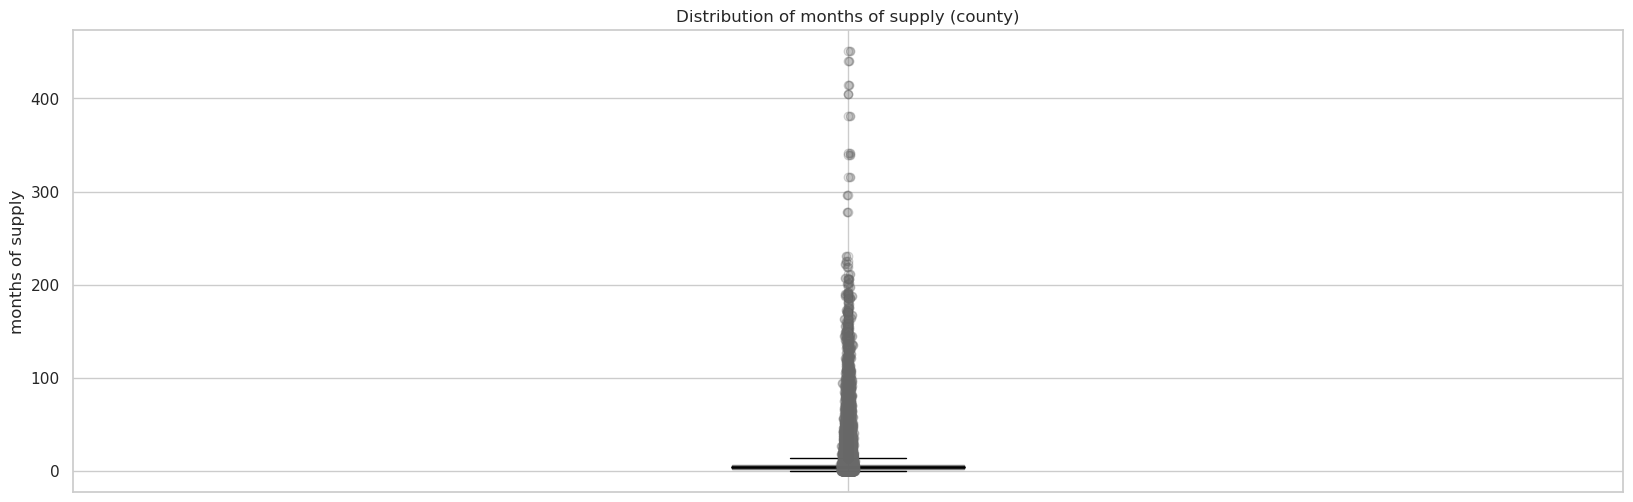

In [130]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.months_of_supply, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of months of supply (county)")
axes.set_ylabel("months of supply")
x = np.random.normal(1, 0.001, size=len(county_analysis.months_of_supply))
axes.plot(x, county_analysis.months_of_supply, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Since the distribution is very positively skewed, we need to determine a cut off for visualization purposes. Based on what we saw on a state level, as well as the mean for the county data, most instances will have less than 50 months:

In [131]:
curs.execute('SELECT COUNT(*) FROM County_analysis \
              WHERE months_of_supply > 50 \
              ORDER BY months_of_supply ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,1225


Only 1,225 out of nearly 650,000 rows in the county data have more than 50 months of supply. Therefore, we can visualize the county data with under 50 months in order to make the histogram *readable*:

Freeman Diaconis:  1


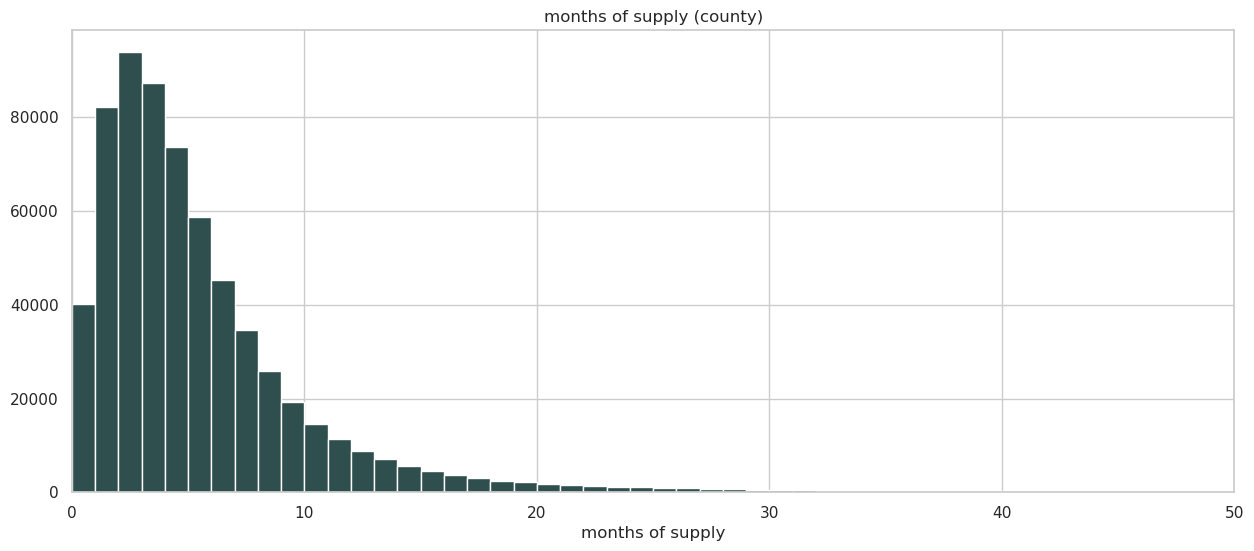

In [132]:
county_months_of_supply = county_analysis.months_of_supply[county_analysis.months_of_supply < 50]

h = freeman_diaconis(county_months_of_supply)
print("Freeman Diaconis: ", h)
mn = int(county_months_of_supply.min())
mx = int(county_months_of_supply.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(15, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_months_of_supply, bins=bins, color="darkslategray")
axes.set_xlim([0, 50])
axes.set_title("months of supply (county)")
axes.set_xlabel("months of supply")

plt.show()
plt.close()

The county level data is starting to look similar to the inventory variable, which is interesting since the distribution appeared more normal on the national and state level. We can keep this in mind for when we look at the average sale to list variable, but for now, we can hypothesize that the county data is much more vast and, therefore, includes more instances with longer months of supply (counties with little incoming traffic of buyers due to poor school systems, high taxes, etc). 

<a id="o"></a>
#### median_dom

[Back to Contents](#NC)

The median days on the market is expected to follow trends seen in months of supply, since greater median dom should contribute to greater months of supply. We can begin with the basic statistics for the national data:

In [133]:
national_analysis.median_dom.describe()

count   1364.00
mean      48.07
std       16.66
min       14.00
25%       37.00
50%       46.00
75%       59.00
max      102.00
Name: median_dom, dtype: float64

On a national level, the median days on the market varied from 14 days to 102 days, with a mean of 48.07 days. The mean is about 10 days less than the median, and both the median and mean sit in the middle of the range of values. Therefore, we would expect the distribution to be relatively normal. Let's start with the box plot:

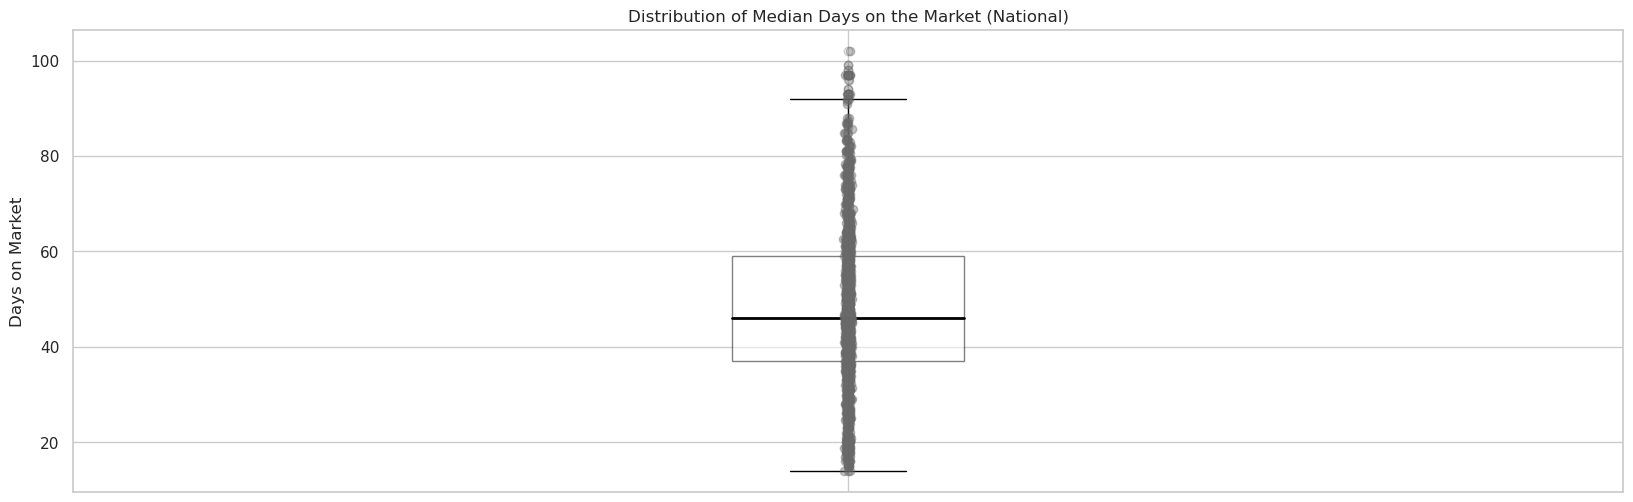

In [134]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.median_dom, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Median Days on the Market (National)")
axes.set_ylabel("Days on Market")
x = np.random.normal(1, 0.001, size=len(national_analysis.median_dom))
axes.plot(x, national_analysis.median_dom, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The median DOM appears to be normally distributed, with an emphasis on word *appears*. There may be a slight positive skew, but nothing that seems significant. Let's try plotting the histogram:

Freeman Diaconis:  4


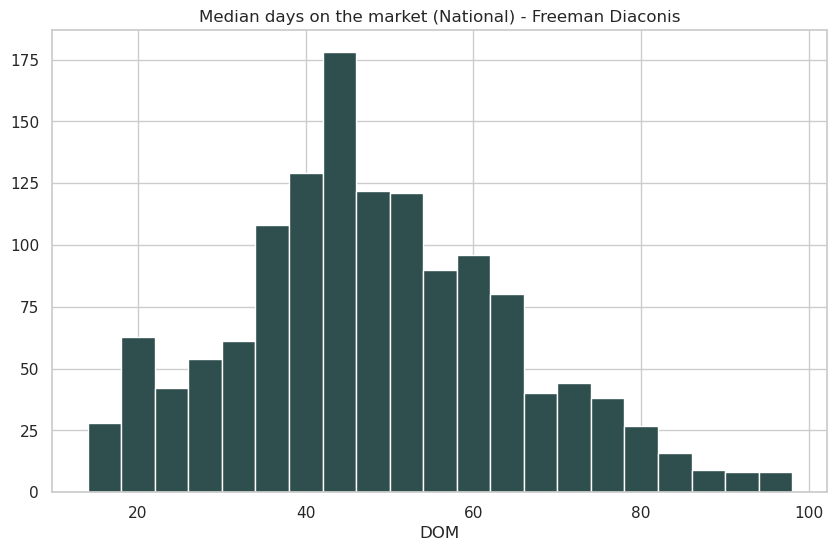

In [135]:
h = freeman_diaconis(national_analysis.median_dom)
print("Freeman Diaconis: ", h)
mn = int(national_analysis.median_dom.min())
mx = int(national_analysis.median_dom.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.median_dom,bins=bins, color="darkslategray")
axes.set_title("Median days on the market (National) - Freeman Diaconis")
axes.set_xlabel("DOM")

plt.show()
plt.close()

So far, the median DOM seems to follow the trends seen in months of supply which makes *some* sense, since the more days on the market, the more months of supply of homes are available at any given time. However, we noted that the months of supply was slightly skewed in the state data and heavily right skewed in the county data; does the same hold true for median DOM? Let's continue to the state data:

In [136]:
state_analysis.median_dom.describe()

count   28739.00
mean       72.36
std        62.57
min         0.00
25%        38.00
50%        60.00
75%        92.00
max      2786.00
Name: median_dom, dtype: float64

On a state scale, the median days on the market ranged from 0 to 2,786 days, with a mean of 72.36 days. The mean is slightly greater than the median, which would indicate a more "normal" distribution, but the mean and median sit very close to the minimum. Therefore, we are likely still dealing with a right skewed distribution, like we saw with the national data. Let's try visualizing the data:

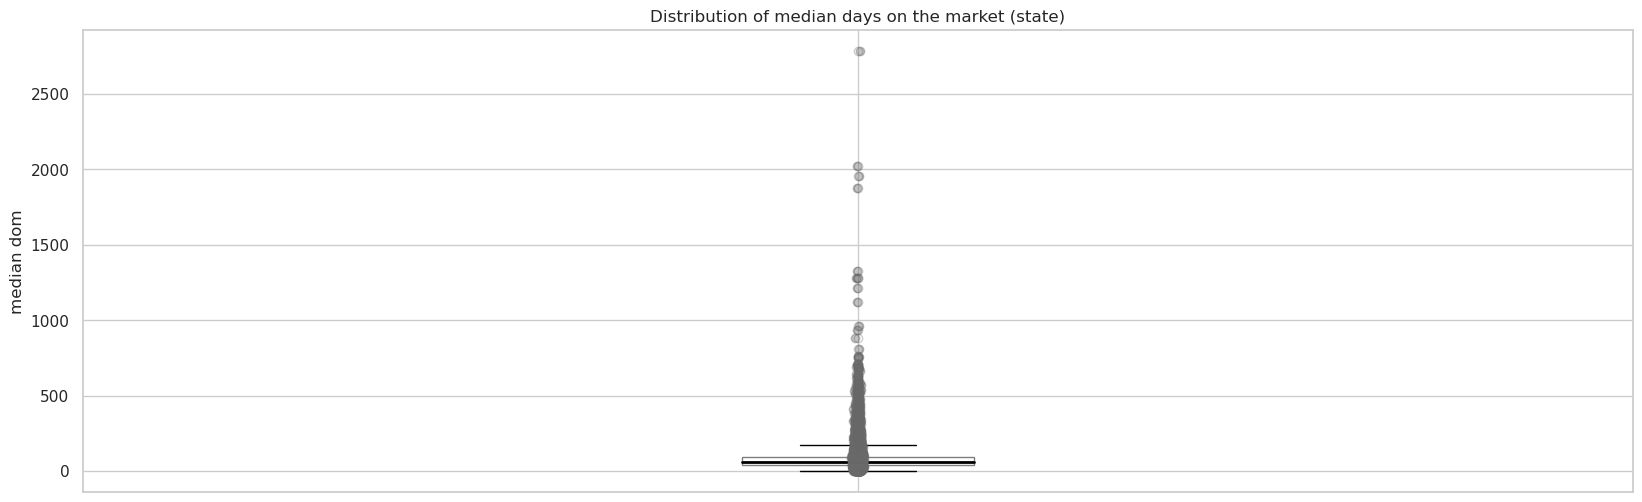

In [137]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.median_dom, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of median days on the market (state)")
axes.set_ylabel("median dom")
x = np.random.normal(1, 0.001, size=len(state_analysis.median_dom))
axes.plot(x, state_analysis.median_dom, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The distribution is right skewed, as expected, and consists of obvious outliers which can affect the histogram. Therefore, we can create a cut off of 500 days which consists of a majority of the data points:

Freeman Diaconis:  4


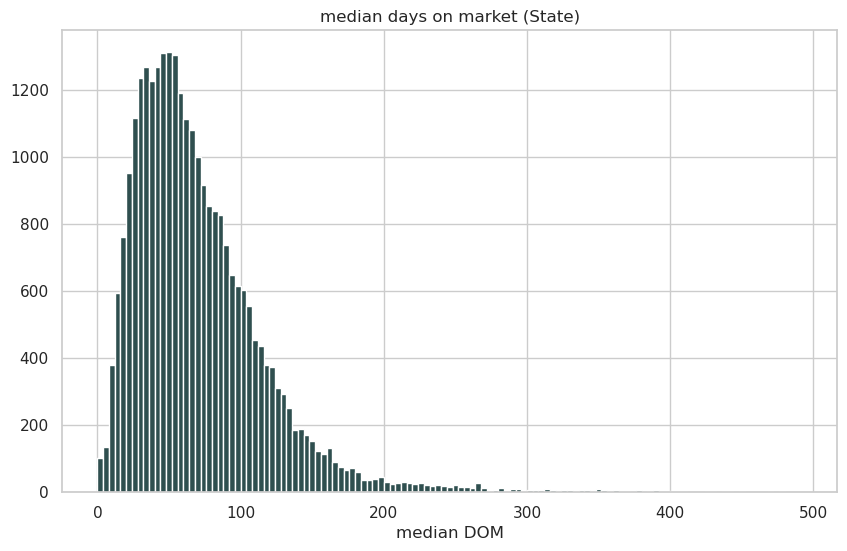

In [138]:
state_dom = state_analysis.median_dom[state_analysis.median_dom < 500]

h = freeman_diaconis(state_dom)
print("Freeman Diaconis: ", h)
mn = int(state_dom.min())
mx = int(state_dom.max())
bins = [i for i in range( mn, mx, h)]

figure= plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_dom, bins=bins, color="darkslategray")
axes.set_title("median days on market (State)")
axes.set_xlabel("median DOM")

plt.show()
plt.close()

There is an evident right skew, as stated, but the overall shape of the distribution is relatively normal. So far, the median DOM variable is behaving similarly to the months of supply variable. For county data, we would expect an even more significant positive skew if this variable continues to behave like months of supply. Let's move on to the county data:

In [139]:
county_analysis.median_dom.describe()

count   640957.00
mean       111.43
std        208.84
min          0.00
25%         40.00
50%         72.00
75%        122.00
max      15811.00
Name: median_dom, dtype: float64

On a county scale, the median DOM ranged from 0 and 15,811 days, with a mean of 111.43 days. The mean is greater than median and these values sit closer to the minimum, so we expect a right skewed distribution, again. Let's try visualizing the data:

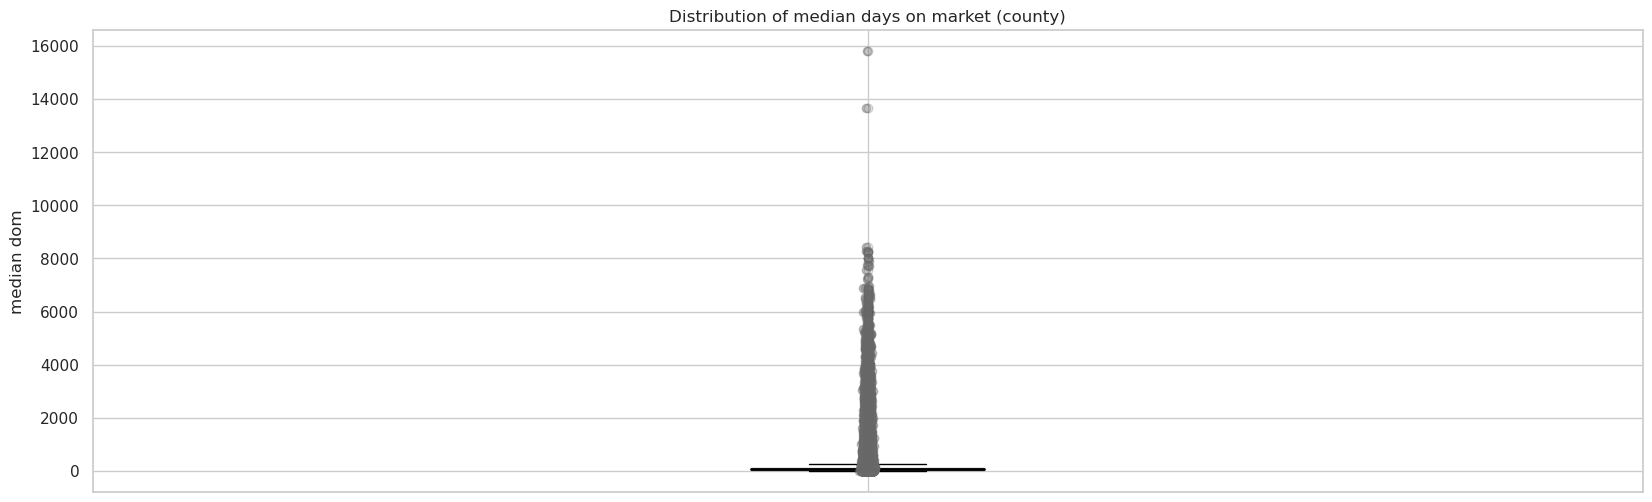

In [140]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.median_dom, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of median days on market (county)")
axes.set_ylabel("median dom")
x = np.random.normal(1, 0.001, size=len(county_analysis.median_dom))
axes.plot(x, county_analysis.median_dom, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Since the distribution is very positively skewed, we need to determine a cut off for visualization purposes. Based on what we saw on a state level, as well as the mean for the county data, most instances will have less than 2000 days, but lets confirm this:

In [141]:
curs.execute('SELECT COUNT(*) FROM County_analysis \
              WHERE median_dom > 2000 \
              ORDER BY median_dom ASC;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,1606


Only 1,606 out of nearly 650,000 rows in the county data have more than 2000 days on the market, or about 5 years. Therefore, we can visualize the county data with under 2000 days on the market in order to make the histogram *readable*:

Freeman Diaconis:  2


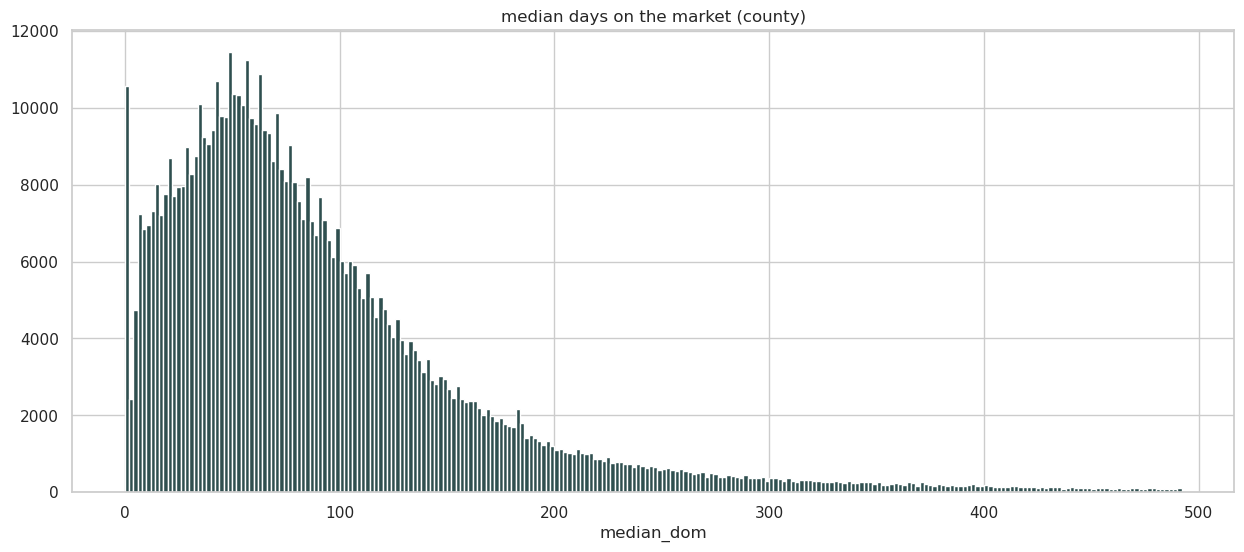

In [142]:
county_median_dom = county_analysis.median_dom[county_analysis.median_dom < 2000]

h = freeman_diaconis(county_median_dom)
print("Freeman Diaconis: ", h)
mn = int(state_dom.min())
mx = int(state_dom.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(15, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_median_dom, bins=bins, color="darkslategray")
axes.set_title("median days on the market (county)")
axes.set_xlabel("median_dom")

plt.show()
plt.close()

The county level data looks vary similar to the months of supply variable, which confirms that both variables behave similarly for all three tables of data. Therefore, we may not need both variables if they depict the same trends and "message", since month's of supply increases and decreases for the same reasons as median days on the market (i.e. buyers or sellers market, housing shortages, etc).

<a id="p"></a>
#### avg_sale_to_list

[Back to Contents](#NC)

The avg sale to list variable is a ratio consisting of the final sale price (what a buyer pays for the home) divided by the last list price expressed as a percentage. Therefore, we would expect a ratio over 1 during sellers markets and less than 1 during buyers markets. Keep in mind that this is unrelated to the home selling overvalue; this is only based on the intended list price vs the sale price, so we may see lower ratios due to negotiations but the home could still be over valued. We would expect this variable to follow trends seen in price drops, since lower avg sale to list ratios may indicate more price drops. We can begin with the national data:

In [143]:
national_analysis.avg_sale_to_list.describe()

count   1364.00
mean       0.98
std        0.01
min        0.93
25%        0.97
50%        0.98
75%        0.99
max        1.03
Name: avg_sale_to_list, dtype: float64

On a national level, the average sale to list ratio ranges from 0.93 to 1.03, with a mean of 0.98. The mean and median are equal and, based on the placement of these values relative to the range, we expect a normal distribution. Let's plot the boxplot:

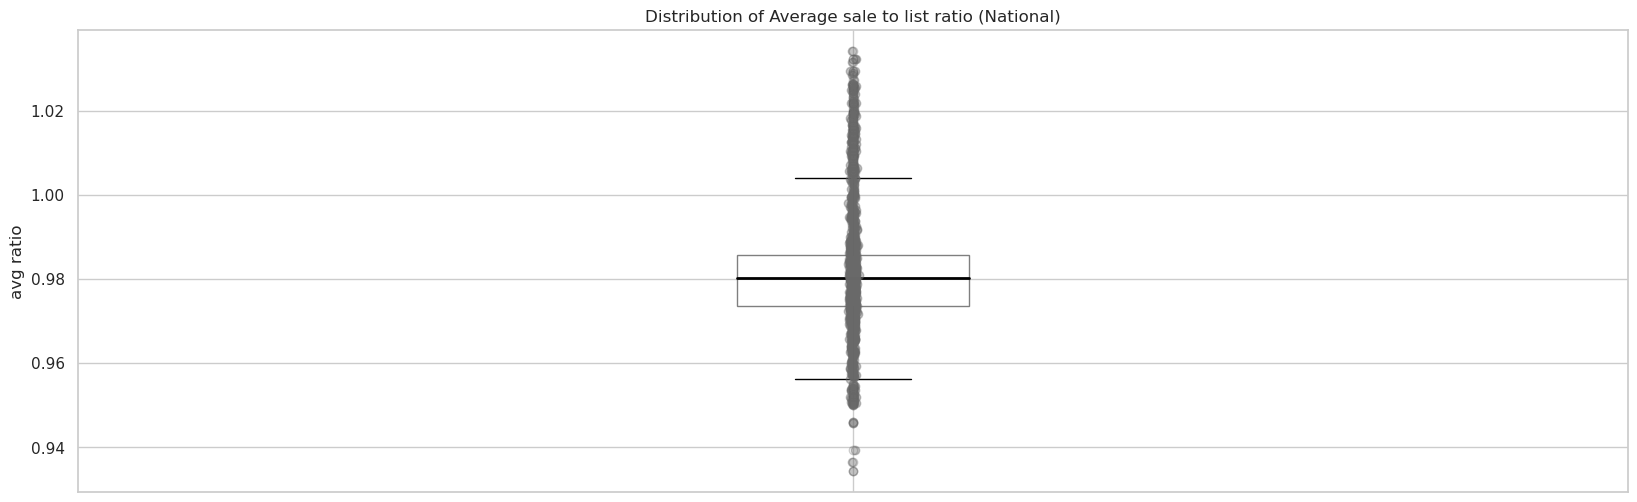

In [144]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.avg_sale_to_list, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Average sale to list ratio (National)")
axes.set_ylabel("avg ratio")
x = np.random.normal(1, 0.001, size=len(national_analysis.avg_sale_to_list))
axes.plot(x, national_analysis.avg_sale_to_list, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

As expected, the distribution is relatively normal. Since we don't see anything surprising so far, we can plot the histogram:

Freeman Diaconis:  1


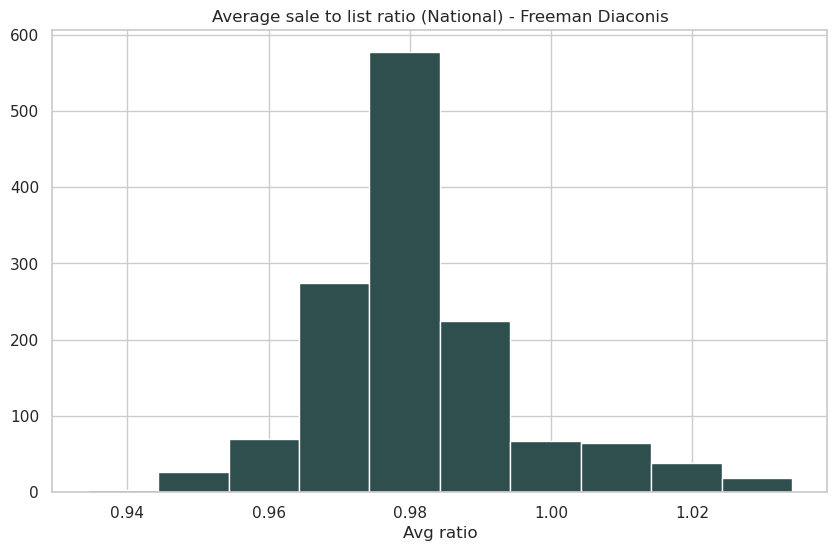

In [145]:
h = freeman_diaconis(national_analysis.avg_sale_to_list)
print("Freeman Diaconis: ", h)
mn = int(state_dom.min())
mx = int(state_dom.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.avg_sale_to_list, color="darkslategray")
axes.set_title("Average sale to list ratio (National) - Freeman Diaconis")
axes.set_xlabel("Avg ratio")

plt.show()
plt.close()

On a national level, most homes sold for about the same price as listed (98% of the total list value). The tail on the higher end is very slightly longer, but so far, it doesn't seem significant. We can continue with the state data as follows:

In [146]:
state_analysis.avg_sale_to_list.describe()

count   28739.00
mean        0.96
std         0.13
min         0.00
25%         0.96
50%         0.98
75%         0.99
max         1.37
Name: avg_sale_to_list, dtype: float64

On a state scale, the average sale to list ratio ranged from 0 to 1.37, with a mean of 0.96. The mean and median are very close, but the values sit closer to the maximum which indicates a left skewed distribution. Is this the true distribution or outliers? Let's try visualizing the data:

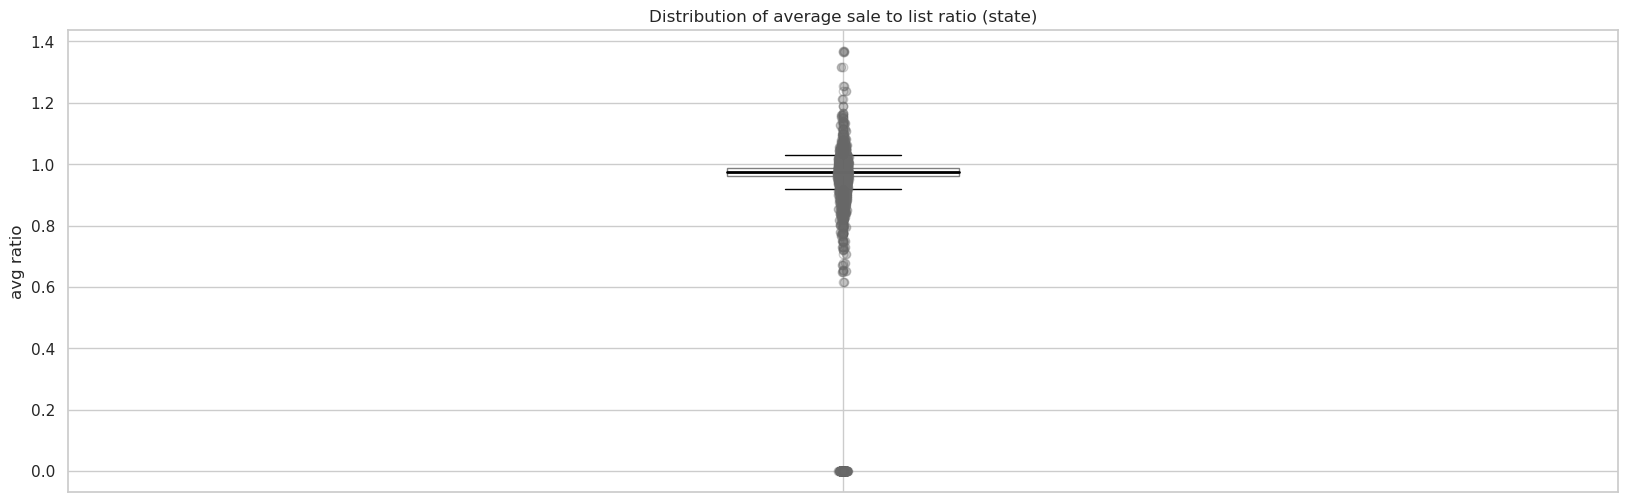

In [147]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.avg_sale_to_list, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of average sale to list ratio (state)")
axes.set_ylabel("avg ratio")
x = np.random.normal(1, 0.001, size=len(state_analysis.avg_sale_to_list))
axes.plot(x, state_analysis.avg_sale_to_list, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Without the outliers on the lower end, we would likely be dealing with a more normal distribution. How many data points make up that cluster at zero? Are they outliers or true values?

In [148]:
curs.execute('SELECT COUNT(*) FROM State_analysis \
              WHERE avg_sale_to_list < 0.4;');

pd.DataFrame(curs.fetchall(), columns=['count'])

,count
0,462


In [149]:
curs.execute('SELECT * FROM State_analysis \
              WHERE avg_sale_to_list < 0.4 \
              ORDER BY avg_sale_to_list ASC \
              LIMIT 20;');

pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,avg_sale_to_list,price_drops,off_market_in_two_weeks
0,793,2014-11-01,2014-11-30,30,state,35,Kansas,Kansas,KS,Townhouse,128700.00,206600.00,82.00,101.00,62.00,0.00,61.00,0,0.00,106.00,0.00,0.00,0.05
1,28595,2021-06-01,2021-06-30,30,state,14,New Mexico,New Mexico,NM,Townhouse,337300.00,517700.00,253.00,282.00,18.00,15.00,18.00,26,1.40,34.00,0.00,0.15,0.52
2,1499,2014-02-01,2014-02-28,30,state,2,Missouri,Missouri,MO,Townhouse,89800.00,137400.00,65.00,82.00,33.00,0.00,47.00,0,0.00,145.00,0.00,0.00,0.00
3,1454,2022-03-01,2022-03-31,30,state,14,New Mexico,New Mexico,NM,Townhouse,434100.00,552800.00,261.00,305.00,16.00,12.00,13.00,11,0.70,27.00,0.00,0.27,0.53
4,1442,2012-10-01,2012-10-31,30,state,2,Missouri,Missouri,MO,Townhouse,84100.00,124700.00,58.00,80.00,49.00,0.00,78.00,0,0.00,125.00,0.00,0.00,0.09
5,1381,2013-07-01,2013-07-31,30,state,2,Missouri,Missouri,MO,Townhouse,81100.00,146100.00,68.00,85.00,63.00,0.00,98.00,0,0.00,119.00,0.00,0.00,0.03
6,1355,2019-01-01,2019-01-31,30,state,2,Missouri,Missouri,MO,Townhouse,126200.00,199900.00,94.00,109.00,48.00,0.00,45.00,0,0.00,54.00,0.00,0.00,0.49
7,1235,2013-04-01,2013-04-30,30,state,14,New Mexico,New Mexico,NM,Multi-Family (2-4 Unit),109900.00,0.00,0.00,0.00,1.00,0.00,0.00,3,3.00,100.00,0.00,0.00,0.00
8,1208,2012-05-01,2012-05-31,30,state,14,New Mexico,New Mexico,NM,Townhouse,249000.00,379500.00,166.00,202.00,9.00,2.00,8.00,38,4.20,126.00,0.00,0.00,0.00
9,1078,2019-09-01,2019-09-30,30,state,35,Kansas,Kansas,KS,Townhouse,183400.00,302200.00,117.00,133.00,76.00,0.00,95.00,0,0.00,17.00,0.00,0.00,0.59


Looking at a few of these, we can note that the avg sale to list value **should not** be zero, since we can easily see the sale and list price for several of these would indicate a ratio below 1 but not zero. Therefore, we will need to pick one of two options: manually calculate the values, drop the missing value rows, or don't use this variable at all since the "information" is already in two other variables in the data. 

For time purposes, I will opt to remove this variable from our analysis data tables. If we choose to use this variable later, we will manually recreate it when generating any transformations on the variables or retrieve it from the original tables in our database. 

In [150]:
curs.execute('ALTER TABLE National_analysis DROP COLUMN avg_sale_to_list;');

curs.execute('ALTER TABLE State_analysis DROP COLUMN avg_sale_to_list;');

curs.execute('ALTER TABLE County_analysis DROP COLUMN avg_sale_to_list;');

In [151]:
conn.commit()

In [152]:
curs.execute("SHOW columns FROM National_analysis")
national_analysis_headers = [column[0] for column in curs.fetchall()]

curs.execute("SHOW columns FROM State_analysis")
state_analysis_headers = [column[0] for column in curs.fetchall()]


curs.execute("SHOW columns FROM County_analysis")
county_analysis_headers = [column[0] for column in curs.fetchall()]

<a id="q"></a>
#### price_drops

[Back to Contents](#NC)

The price drops variable consists of the percent of homes in a time period that had posted price drops in order to attract buyers. Based on domain knowledge, we expect time periods that had higher median days on the market to have more price drops. 

In [153]:
national_analysis.price_drops.describe()

count   1364.00
mean       0.10
std        0.03
min        0.04
25%        0.08
50%        0.10
75%        0.12
max        0.33
Name: price_drops, dtype: float64

On a national scale, the percent of price drops during a time period varied from 0% to 100%, with a mean of 13%. The mean and median are nearly equal, but they both sit closer to the minimum. Therefore, we would expect a positively skewed distribution of price drop percents. 

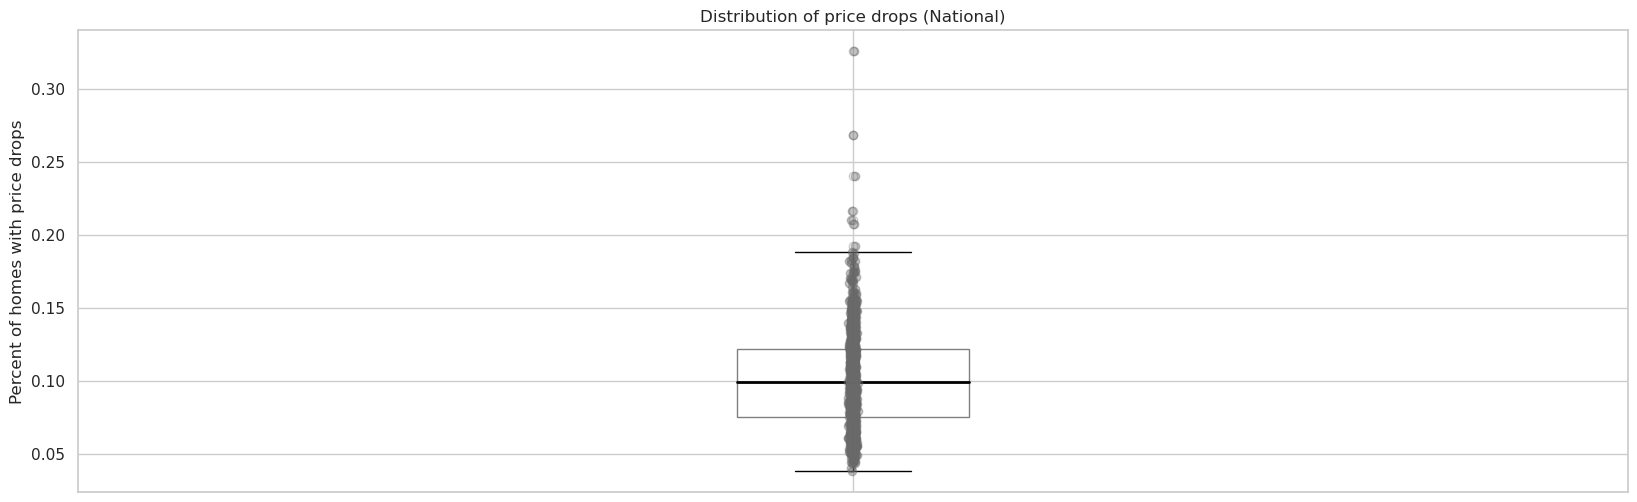

In [154]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.price_drops, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of price drops (National)")
axes.set_ylabel("Percent of homes with price drops")
x = np.random.normal(1, 0.001, size=len(national_analysis.price_drops))
axes.plot(x, national_analysis.price_drops, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Most data points sat between 0 and 20%, with a few outliers at the upper end of the distribution, which results in the right skewed distribution. We can plot the histogram as follows:

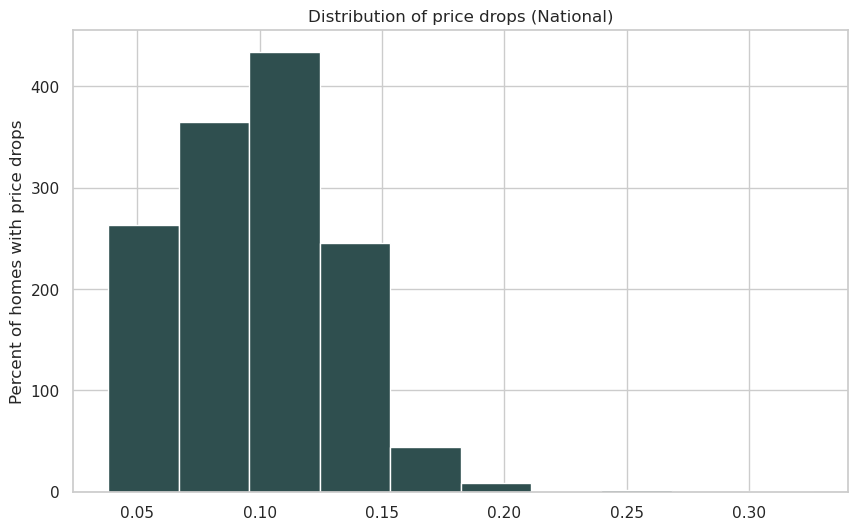

In [155]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.price_drops, color="darkslategray")
axes.set_title("Distribution of price drops (National)")
axes.set_ylabel("Percent of homes with price drops")

plt.show()
plt.close()

Interestingly, the distribution is similar to months of supply. This makes logical sense when we consider that greater months of supply will correlate with a buyers market or situations where homes aren't sold quickly. As a result, price drops will occur to attract buyers. Let's move on to the state data:

In [156]:
state_analysis.price_drops.describe()

count   28739.00
mean        0.13
std         0.10
min         0.00
25%         0.01
50%         0.14
75%         0.20
max         1.00
Name: price_drops, dtype: float64

On a state scale, the percent of price drops varied from 0 to 100%, with a mean of 13%. Similar to the national data, we expect a right skewed distribution since the mean and median sit closer to the minimum.

Let's try visualizing the data:

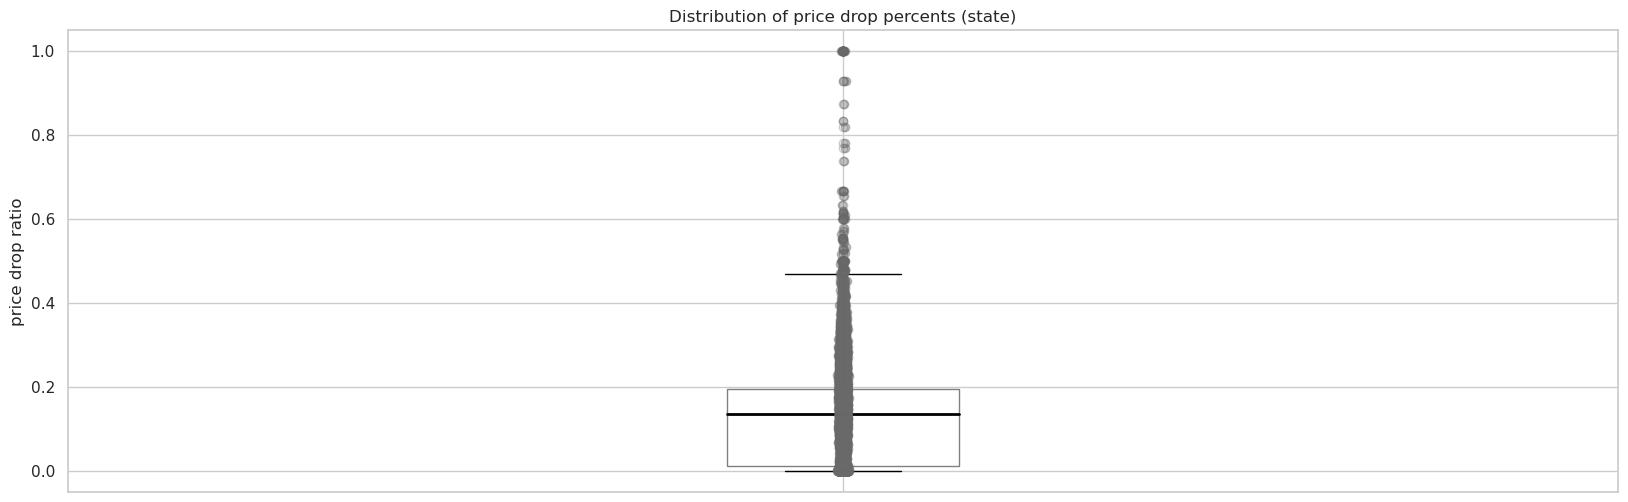

In [157]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.price_drops, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of price drop percents (state)")
axes.set_ylabel("price drop ratio")
x = np.random.normal(1, 0.001, size=len(state_analysis.price_drops))
axes.plot(x, state_analysis.price_drops, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Although the distribution appears as we expected, there seems to be a cluster at 100% instead of tapering off at the higher end of the distribution. Therefore, these could be incorrect values rather than true values. Let's look more closely at rows with 100% price drops:

In [158]:
curs.execute('SELECT * FROM State_analysis \
              WHERE price_drops > 0.99;');

pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops,off_market_in_two_weeks
0,4331,2021-09-01,2021-09-30,30,state,47,Michigan,Michigan,MI,Townhouse,452000.00,0.00,0.00,0.00,5.00,0.00,0.00,1,0.20,56.00,1.00,0.00
1,5128,2020-10-01,2020-10-31,30,state,41,Maine,Maine,ME,Townhouse,379500.00,350000.00,187.00,224.00,2.00,1.00,2.00,2,1.00,7.00,1.00,1.00
2,5251,2016-05-01,2016-05-31,30,state,41,Maine,Maine,ME,Townhouse,136900.00,239000.00,127.00,136.00,1.00,0.00,1.00,1,1.00,3.00,1.00,0.00
3,6255,2021-02-01,2021-02-28,30,state,46,West Virginia,West Virginia,WV,Multi-Family (2-4 Unit),130000.00,0.00,0.00,0.00,2.00,1.00,0.00,1,0.50,35.00,1.00,0.00
4,14840,2022-03-01,2022-03-31,30,state,28,Rhode Island,Rhode Island,RI,Townhouse,193000.00,359500.00,152.00,200.00,1.00,3.00,3.00,1,1.00,68.00,1.00,1.00
5,15878,2016-07-01,2016-07-31,30,state,47,Michigan,Michigan,MI,Townhouse,50000.00,0.00,0.00,0.00,1.00,1.00,0.00,1,1.00,24.00,1.00,0.00
6,16412,2021-01-01,2021-01-31,30,state,46,West Virginia,West Virginia,WV,Multi-Family (2-4 Unit),884500.00,246500.00,40.00,140.00,2.00,4.00,4.00,2,1.00,40.00,1.00,0.75
7,21087,2019-11-01,2019-11-30,30,state,28,Rhode Island,Rhode Island,RI,Townhouse,349900.00,265000.00,222.00,145.00,1.00,0.00,1.00,1,1.00,0.00,1.00,0.00
8,22360,2021-08-01,2021-08-31,30,state,41,Maine,Maine,ME,Townhouse,177800.00,287700.00,175.00,187.00,3.00,2.00,2.00,1,0.30,30.00,1.00,0.50
9,24499,2017-03-01,2017-03-31,30,state,14,New Mexico,New Mexico,NM,Multi-Family (2-4 Unit),134000.00,0.00,0.00,0.00,3.00,1.00,0.00,1,0.30,6.00,1.00,0.00


Based on the number of homes sold, these few data points **could** be true. Only a few homes were sold in these states during these specific time periods, so its possible that 100% of the homes had price drops. Since these are so few points (10 rows out of over 30,000), we won't drop them. We can plot the histogram to further highlight how these points do not make up a majority of the distribution:

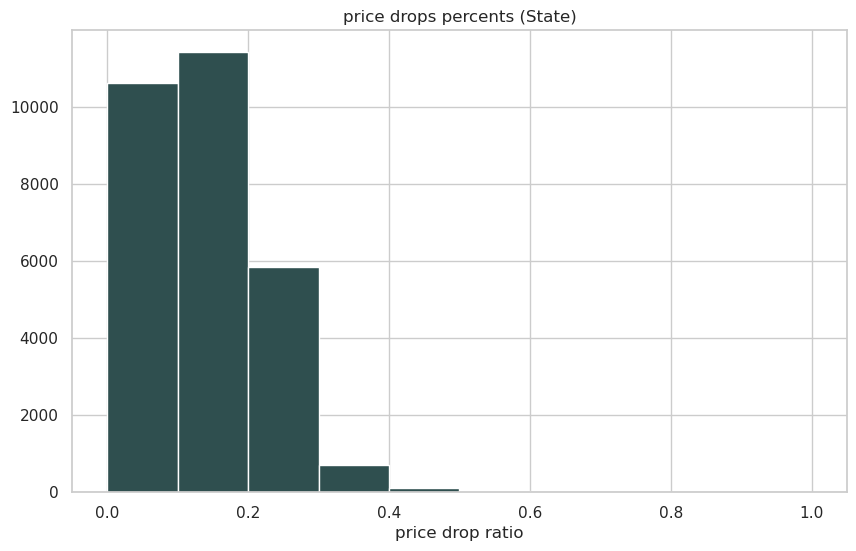

In [159]:
figure= plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_analysis.price_drops, color="darkslategray")
axes.set_title("price drops percents (State)")
axes.set_xlabel("price drop ratio")

plt.show()
plt.close()

As stated, the few rows that have 100% price drops seem insignificant compared to the overall right skewed distribution we expected. Still, we want to keep these rows in mind in case they pose an issue for the county data, i.e. are they true points or missing/incorrect values?

Let's move on to the county data:

In [160]:
county_analysis.price_drops.describe()

count   640957.00
mean         0.11
std          0.13
min          0.00
25%          0.00
50%          0.06
75%          0.19
max          1.00
Name: price_drops, dtype: float64

On a county scale, the percent of price drops ranged from 0 to 100%, with a mean of 11%. The mean is greater than the median and both values sit closer to the minimum; once again, we are dealing with a right skewed distribution.

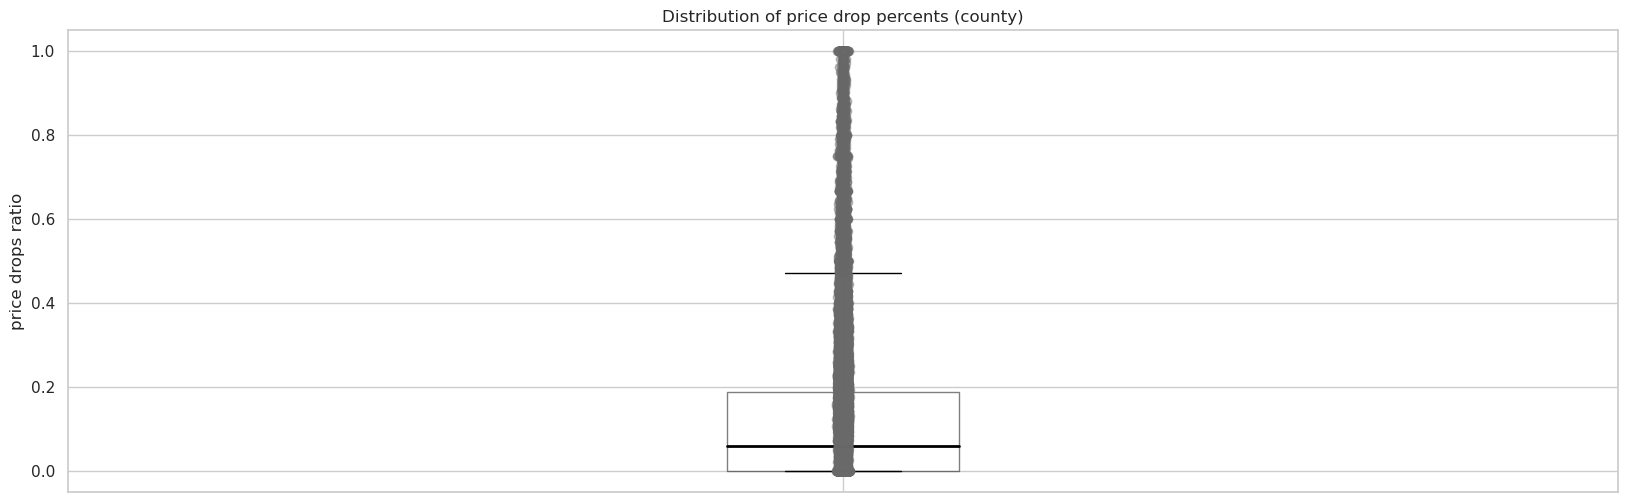

In [161]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.price_drops, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of price drop percents (county)")
axes.set_ylabel("price drops ratio")
x = np.random.normal(1, 0.001, size=len(county_analysis.price_drops))
axes.plot(x, county_analysis.price_drops, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

So far, the distribution appears as expected, though we are seeing a cluster of values again at 100% price drops. We must ask again, are these true values or incorrect/missing values?

In [162]:
curs.execute('SELECT * FROM County_analysis \
              WHERE price_drops > 0.99;');

pd.DataFrame(curs.fetchall(), columns=county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops,off_market_in_two_weeks
0,113,2020-11-01,2020-11-30,30,county,1134,"Clark County, KY",Kentucky,KY,Multi-Family (2-4 Unit),160000.00,169900.00,42.68,108.71,1.00,1.00,1.00,2,2.00,13.00,1.00,0.00
1,221,2017-03-01,2017-03-31,30,county,2188,"Greene County, OH",Ohio,OH,Townhouse,125000.00,0.00,102.29,0.00,1.00,0.00,0.00,1,1.00,1.00,1.00,0.00
2,1559,2021-12-01,2021-12-31,30,county,1432,"Anoka County, MN",Minnesota,MN,Multi-Family (2-4 Unit),272000.00,0.00,158.23,0.00,10.00,8.00,0.00,1,0.10,38.00,1.00,0.25
3,1619,2021-12-01,2021-12-31,30,county,1417,"Ottawa County, MI",Michigan,MI,Multi-Family (2-4 Unit),276000.00,275000.00,0.00,181.41,6.00,4.00,2.00,2,0.30,12.00,1.00,0.75
4,2168,2021-06-01,2021-06-30,30,county,1196,"Montgomery County, KY",Kentucky,KY,Multi-Family (2-4 Unit),190000.00,0.00,0.00,0.00,1.00,1.00,0.00,1,1.00,26.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153,638974,2016-09-01,2016-09-30,30,county,3008,"Prince George County, VA",Virginia,VA,Condo/Co-op,171750.00,0.00,116.52,0.00,2.00,1.00,0.00,1,0.50,6.00,1.00,0.00
2154,639251,2016-04-01,2016-04-30,30,county,2769,"Kendall County, TX",Texas,TX,Townhouse,230000.00,0.00,138.10,0.00,2.00,0.00,0.00,1,0.50,135.00,1.00,0.00
2155,639554,2019-09-01,2019-09-30,30,county,1695,"St. Louis County, MO",Missouri,MO,Multi-Family (2-4 Unit),110000.00,189900.00,77.55,138.79,3.00,0.00,2.00,5,1.70,79.00,1.00,0.00
2156,639782,2021-08-01,2021-08-31,30,county,3211,"Polk County, WI",Wisconsin,WI,Townhouse,225000.00,0.00,177.44,0.00,1.00,0.00,0.00,1,1.00,15.00,1.00,0.00


This cluster is a minority, since it is only 2,159 points out of over 650,000 total rows. In addition, we are seeing the same trend we saw in the state data; these time periods only had a handful of homes sold in total so it is very likely that all the homes incurred price drops to attract buyers or adjust to market conditions. Let's look at the histogram to see if the points appear more or less significant compared to the box plot:

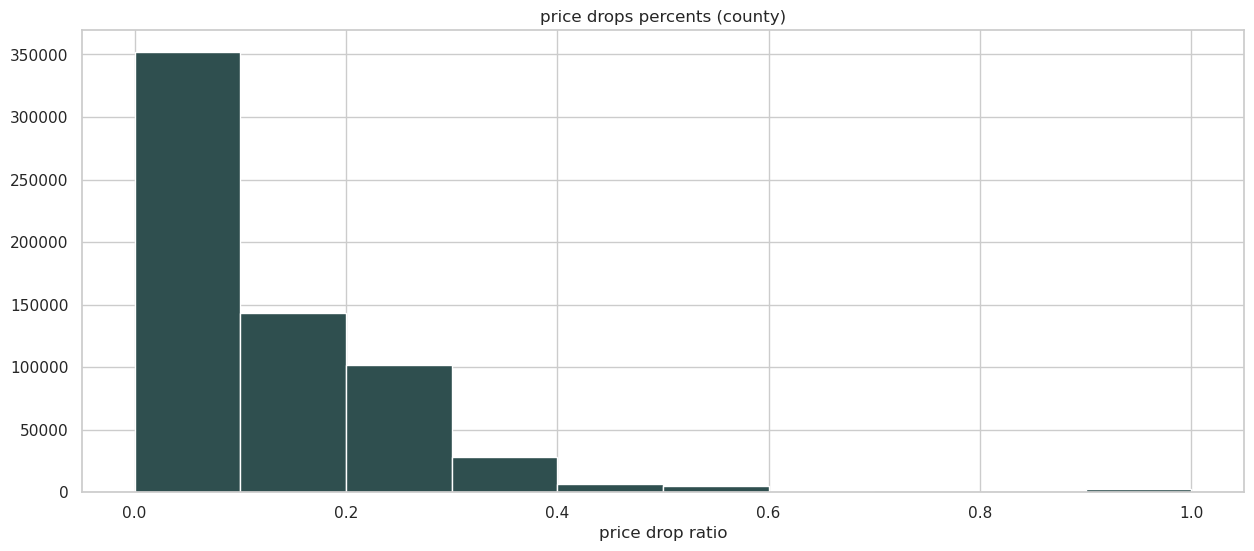

In [163]:
figure = plt.figure(figsize=(15, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_analysis.price_drops, color="darkslategray")
axes.set_title("price drops percents (county)")
axes.set_xlabel("price drop ratio")

plt.show()
plt.close()

The cluster at 100% does not appear significant compared to the overall distribution. Combined with the other variables associated with these rows (homes_sold) and the number of points that make up the cluster, we can leave these data points alone and assume they are true values.

<a id="r"></a>
#### off_market_in_two_weeks

[Back to Contents](#NC)

The off market in two weeks variable consists of the percent of homes for each time period and location that sold/came off the market within two weeks. Based on what we saw with the price drops variable, we expect to see small clusters around 100% for cases where only a few homes were sold at all in a certain location/time period. We can begin with the national data:

In [164]:
national_analysis.off_market_in_two_weeks.describe()

count   1364.00
mean       0.38
std        0.08
min        0.21
25%        0.32
50%        0.37
75%        0.42
max        0.63
Name: off_market_in_two_weeks, dtype: float64

On a national level, 21% to 63% of homes sold within two weeks, with a mean of 38% of homes. Although the mean and median are nearly equal, these values sit slightly closer to the minimum. Therefore, we expect a somewhat positively skewed distribution, which we can confirm through visualization as follows:

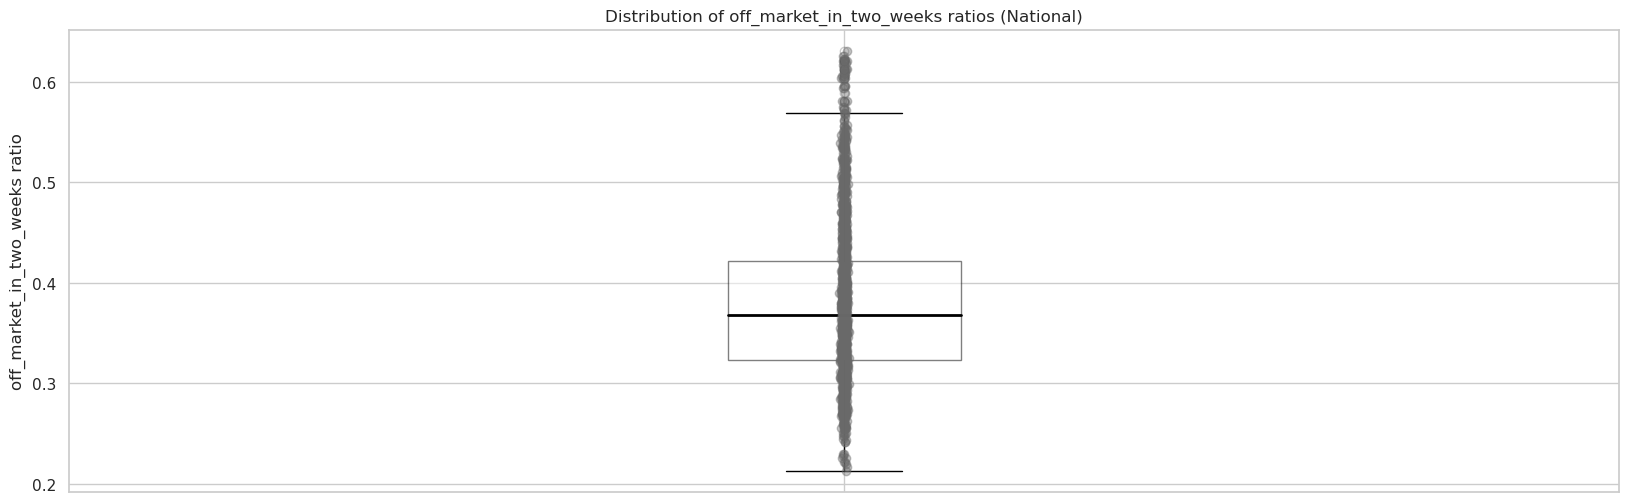

In [165]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(national_analysis.off_market_in_two_weeks, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of off_market_in_two_weeks ratios (National)")
axes.set_ylabel("off_market_in_two_weeks ratio")
x = np.random.normal(1, 0.001, size=len(national_analysis.off_market_in_two_weeks))
axes.plot(x, national_analysis.off_market_in_two_weeks, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The distribution is slightly skewed to the right, so overall, the distribution is as expected. Contrary to expectation, at least on a national level, we do not see a cluster at 100%. It's likely that we won't see this cluster until we look at the state and county data, since more specific locations will include regions where only a handful of homes were sold. For now, let's look at the histogram for this distribution:

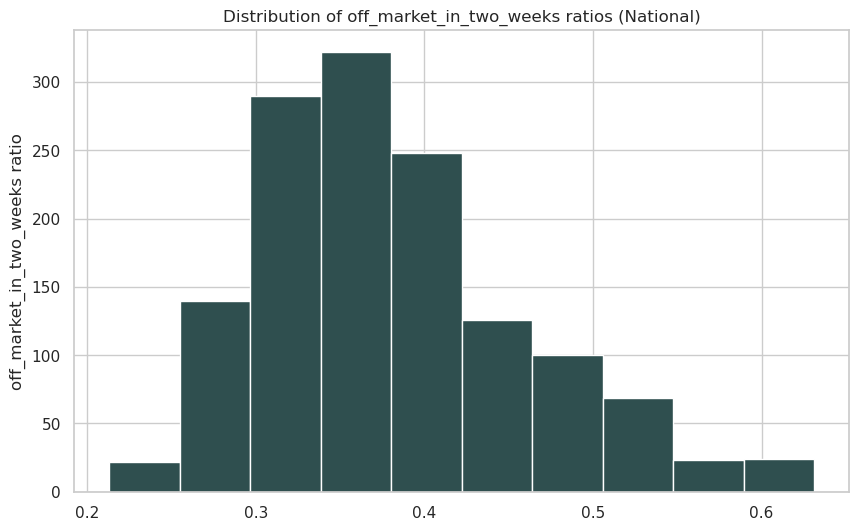

In [166]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(national_analysis.off_market_in_two_weeks, color="darkslategray")
axes.set_title("Distribution of off_market_in_two_weeks ratios (National)")
axes.set_ylabel("off_market_in_two_weeks ratio")

plt.show()
plt.close()

Overall, we do not see anything unexpected or surprising that we did not see in the box plot, so we can move on to the state data:

In [167]:
state_analysis.off_market_in_two_weeks.describe()

count   28739.00
mean        0.30
std         0.19
min         0.00
25%         0.15
50%         0.29
75%         0.42
max         1.00
Name: off_market_in_two_weeks, dtype: float64

On a state scale, the percent of homes that sold within two weeks ranged from 0 to 100%, with a mean of 30%. The mean and median are close to equal but they sit closer to the minimum, signaling a positively skewed distribution again. 

Let's try visualizing the data:

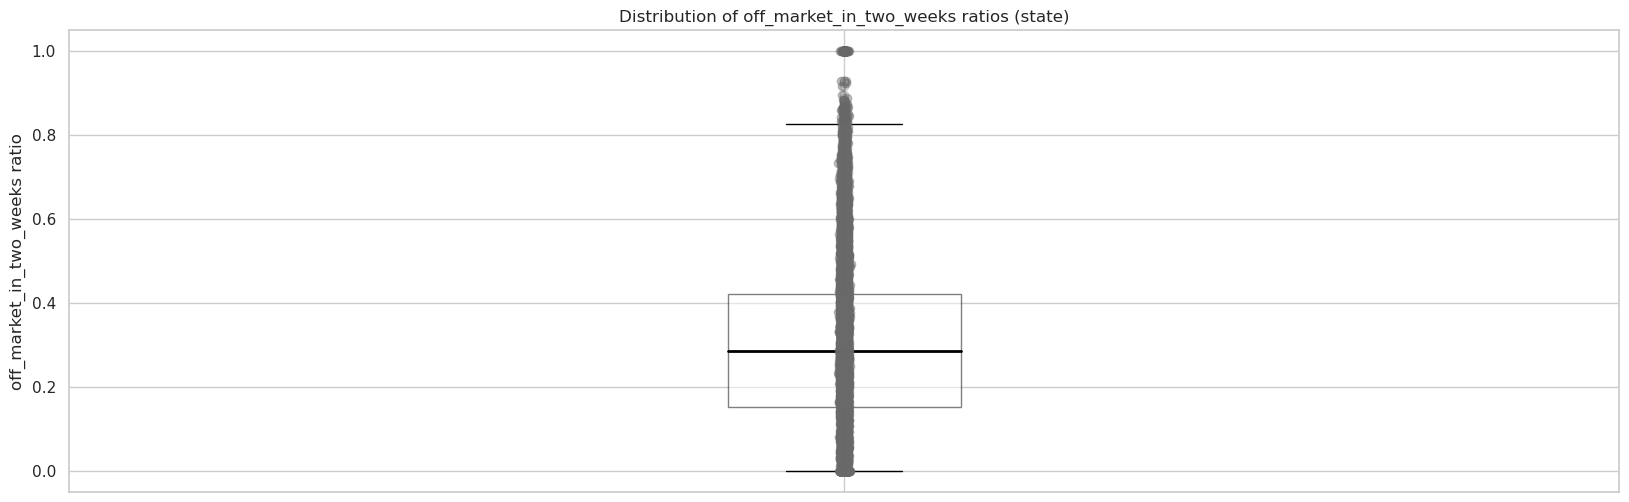

In [168]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(state_analysis.off_market_in_two_weeks, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of off_market_in_two_weeks ratios (state)")
axes.set_ylabel("off_market_in_two_weeks ratio")
x = np.random.normal(1, 0.001, size=len(state_analysis.off_market_in_two_weeks))
axes.plot(x, state_analysis.off_market_in_two_weeks, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The shape of distribution is expected and we also see the cluster at 100%, like we did with the price drops variable. Based on what we saw previously, we can predict that the data points making up these clusters are due to a low number of homes sold, like we saw with price drops, which means the values are true. Let's confirm if this is, in fact, the case for this variable:

In [169]:
curs.execute('SELECT * FROM State_analysis \
              WHERE off_market_in_two_weeks > 0.99;');

pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops,off_market_in_two_weeks
0,3,2018-08-01,2018-08-31,30,state,14,New Mexico,New Mexico,NM,Multi-Family (2-4 Unit),550000.00,419000.00,218.00,225.00,1.00,2.00,3.00,8,8.00,5.00,0.25,1.00
1,298,2018-08-01,2018-08-31,30,state,41,Maine,Maine,ME,Townhouse,185000.00,290000.00,141.00,184.00,1.00,2.00,1.00,3,3.00,4.00,0.00,1.00
2,785,2020-11-01,2020-11-30,30,state,47,Michigan,Michigan,MI,Townhouse,263400.00,260000.00,193.00,167.00,4.00,1.00,1.00,17,4.30,90.00,0.00,1.00
3,1255,2020-06-01,2020-06-30,30,state,15,Delaware,Delaware,DE,Multi-Family (2-4 Unit),115000.00,269900.00,114.00,144.00,3.00,3.00,6.00,15,5.00,219.00,0.07,1.00
4,1423,2019-04-01,2019-04-30,30,state,47,Michigan,Michigan,MI,Townhouse,52500.00,139900.00,57.00,109.00,2.00,1.00,3.00,5,2.50,33.00,0.20,1.00
5,2051,2012-10-01,2012-10-31,30,state,7,Arkansas,Arkansas,AR,Townhouse,165000.00,145900.00,90.00,82.00,3.00,1.00,1.00,28,9.30,129.00,0.00,1.00
6,2129,2014-11-01,2014-11-30,30,state,23,Oklahoma,Oklahoma,OK,Multi-Family (2-4 Unit),139200.00,155000.00,48.00,87.00,29.00,15.00,12.00,40,1.40,9.00,0.00,1.00
7,3364,2012-10-01,2012-10-31,30,state,23,Oklahoma,Oklahoma,OK,Multi-Family (2-4 Unit),110800.00,135000.00,55.00,80.00,36.00,21.00,12.00,37,1.00,5.00,0.00,1.00
8,3801,2017-08-01,2017-08-31,30,state,28,Rhode Island,Rhode Island,RI,Townhouse,201200.00,229900.00,138.00,137.00,2.00,1.00,1.00,1,0.50,9.00,0.00,1.00
9,4929,2020-02-01,2020-02-29,30,state,46,West Virginia,West Virginia,WV,Multi-Family (2-4 Unit),50000.00,210000.00,21.00,116.00,1.00,1.00,8.00,9,9.00,2.00,0.00,1.00


Scanning over the number of homes sold for each of these 62 rows, we can note that the trend is the same as price drops since the number of homes sold is low relative to the mean homes sold for the state data. Therefore, these rows are likely true and can be left alone. Let's look at the histogram:

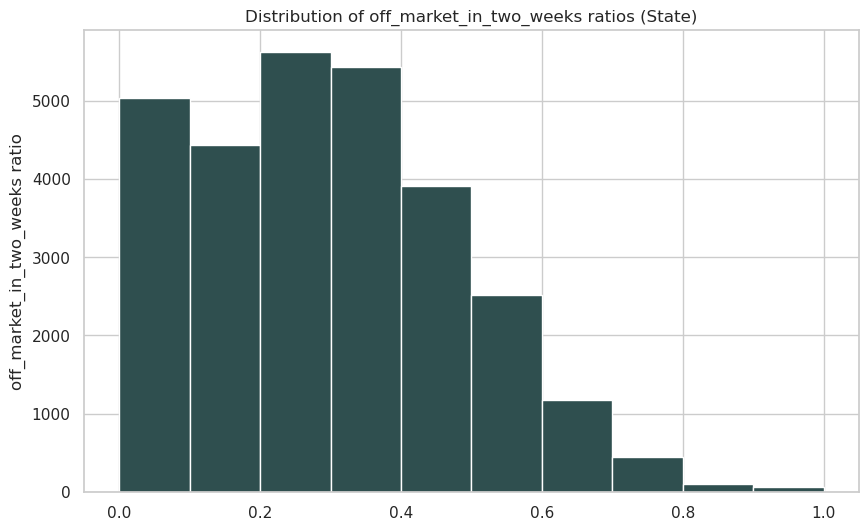

In [170]:
figure= plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(state_analysis.off_market_in_two_weeks, color="darkslategray")
axes.set_title("Distribution of off_market_in_two_weeks ratios (State)")
axes.set_ylabel("off_market_in_two_weeks ratio")

plt.show()
plt.close()

Like the price drops variable, the few rows that have 100% of homes sold within two weeks seem insignificant compared to the overall right skewed distribution we expected. Is the same true for this variable in regards to the county data, like we saw with the price drops variable?

In [171]:
county_analysis.off_market_in_two_weeks.describe()

count   640957.00
mean         0.22
std          0.25
min          0.00
25%          0.00
50%          0.14
75%          0.38
max          1.50
Name: off_market_in_two_weeks, dtype: float64

On a county scale, the percent of homes that came off the market within two weeks ranged from 0 to 150%, with a mean of 22%. Already, we know we may be dealing with incorrect values since over 100% is not possible. Let's plot the box plot to see how many values seem to be incorrect:

Let's try visualizing the data:

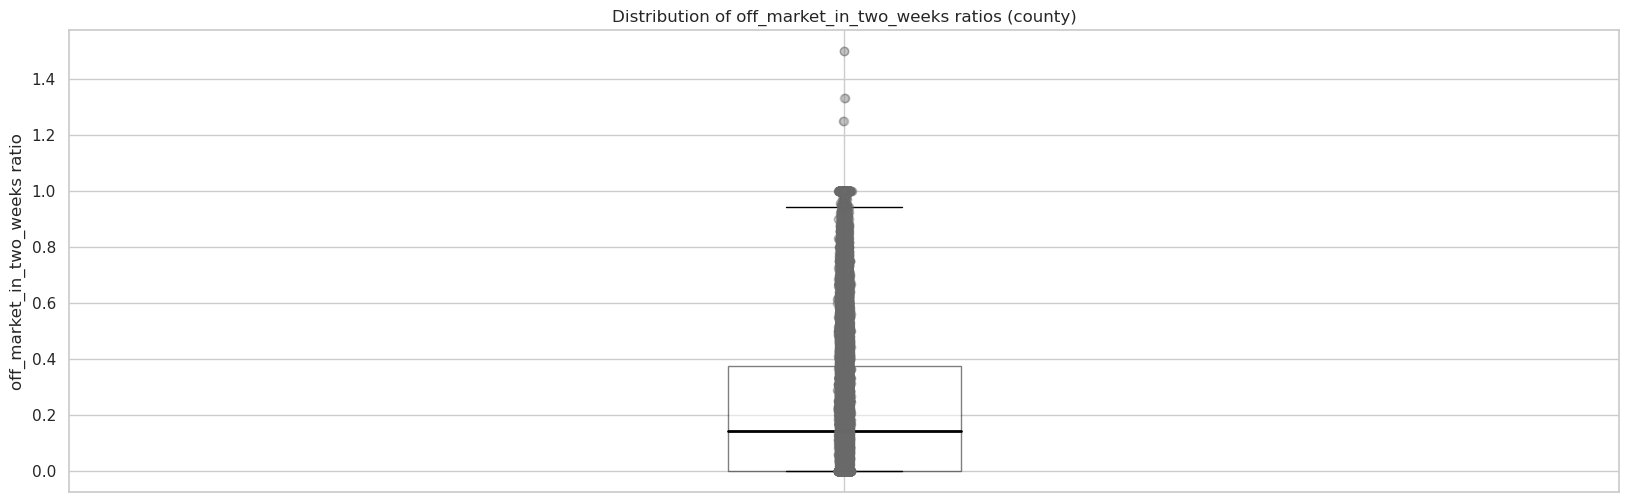

In [172]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(county_analysis.off_market_in_two_weeks, labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of off_market_in_two_weeks ratios (county)")
axes.set_ylabel("off_market_in_two_weeks ratio")
x = np.random.normal(1, 0.001, size=len(county_analysis.off_market_in_two_weeks))
axes.plot(x, county_analysis.off_market_in_two_weeks, 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

In addition to a cluster around 100%, which is likely correct as we saw with the state data, we have three outlier values that are incorrect since over 100% is not possible. Let's drop these rows and confirm that the cluster of values with 100% of homes sold within two weeks are true values:

In [173]:
curs.execute('DELETE FROM County_analysis \
              WHERE off_market_in_two_weeks > 1;');

In [174]:
curs.execute('SELECT * FROM County_analysis \
              WHERE off_market_in_two_weeks > 0.99;');

pd.DataFrame(curs.fetchall(), columns=county_analysis_headers)

,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops,off_market_in_two_weeks
0,16,2017-04-01,2017-04-30,30,county,2548,"Bledsoe County, TN",Tennessee,TN,Single Family Residential,250000.00,79900.00,106.34,57.07,1.00,1.00,1.00,10,10.00,0.00,0.10,1.00
1,34,2020-05-01,2020-05-31,30,county,373,"Costilla County, CO",Colorado,CO,Single Family Residential,110000.00,177000.00,119.05,123.82,5.00,3.00,6.00,24,4.80,296.00,0.04,1.00
2,61,2017-01-01,2017-01-31,30,county,1134,"Clark County, KY",Kentucky,KY,Townhouse,116500.00,138900.00,92.75,85.65,1.00,2.00,2.00,2,2.00,15.00,0.00,1.00
3,115,2015-07-01,2015-07-31,30,county,557,"Evans County, GA",Georgia,GA,Single Family Residential,49400.00,82000.00,31.82,39.40,4.00,1.00,6.00,45,11.30,185.00,0.00,1.00
4,163,2017-01-01,2017-01-31,30,county,3086,"Jefferson County, WA",Washington,WA,Condo/Co-op,222690.00,279000.00,221.16,172.07,2.00,1.00,4.00,10,5.00,34.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16723,640706,2016-11-01,2016-11-30,30,county,3119,"Grant County, WV",West Virginia,WV,Single Family Residential,134900.00,176500.00,69.14,90.87,9.00,1.00,8.00,53,5.90,138.00,0.08,1.00
16724,640741,2017-06-01,2017-06-30,30,county,477,"Marion County, FL",Florida,FL,Townhouse,500000.00,154900.00,249.25,95.43,1.00,1.00,1.00,0,0.00,1.00,0.00,1.00
16725,640825,2017-01-01,2017-01-31,30,county,893,"Tipton County, IN",Indiana,IN,Single Family Residential,113000.00,72450.00,58.70,65.01,7.00,1.00,6.00,33,4.70,67.00,0.18,1.00
16726,640914,2018-04-01,2018-04-30,30,county,3204,"Monroe County, WI",Wisconsin,WI,Multi-Family (2-4 Unit),86000.00,150000.00,60.10,90.48,1.00,1.00,3.00,11,11.00,0.00,0.18,1.00


Out of the ~650,000 rows, nearly 17,000 consist of 100% of homes sold within two weeks in their respective time periods. At face value, it seems like these values are true since the number of homes sold is low. It may be easier to just look at the average homes sold for these rows in order to confirm if the trend seen with the state data holds true here:

In [175]:
curs.execute('SELECT AVG(homes_sold) FROM County_analysis \
              WHERE off_market_in_two_weeks > 0.99;');

pd.DataFrame(curs.fetchall(), columns=['Average Homes sold'])

,Average Homes sold
0,2.99


The average homes sold is only about 3 homes for rows that had 100% of homes sold within two weeks. This is vastly different than the overall mean homes sold (which is over 2,000 homes overall, and over 1,000 homes when we don't factor in rows where over 20,000 homes were sold). Therefore, it's very possible that 100% of homes sold within two weeks in these cases, so the values are likely true. Let's finish our single variable analysis with the final histogram:

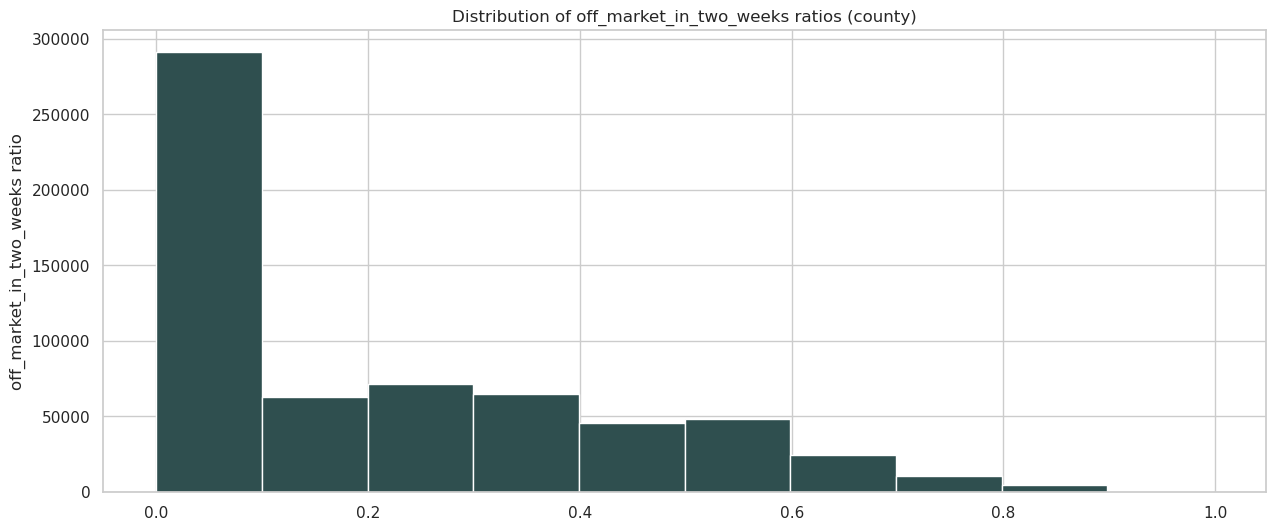

In [176]:
county_off_market_in_two_weeks = county_analysis.off_market_in_two_weeks[county_analysis.off_market_in_two_weeks < 1]

figure = plt.figure(figsize=(15, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(county_off_market_in_two_weeks, color="darkslategray")
axes.set_title("Distribution of off_market_in_two_weeks ratios (county)")
axes.set_ylabel("off_market_in_two_weeks ratio")

plt.show()
plt.close()

We have a heavily right skewed distribution when we remove the outliers, which is expected if we consider the mean of 22% relative to the maximum of 100% and the fact that the mean is greater than the median. Most homes did not sell within two weeks, which hints at the market conditions for most of the time in the last decade. We can predict that rows consisting of over 50% of homes being sold within two weeks are from competitive sellers markets, like we saw during the pandemic. 

In [177]:
conn.commit()

In [178]:
conn.close()